## Cardiac Regulatory Network for CMRG
### CRNC developed by Shulin Cao
### Only for use in CMRG

In [57]:
###------Network Simulator------###
###------Shulin Cao------###
###------CMRG, UC San Diego------###

###import packages###
import pandas as pd
import collections
import timeit
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.mlab as mlab
import statistics
import random
import numpy.linalg
import numpy as np
import sys
from scipy.optimize import minimize
elapsed_time = timeit.default_timer()
from sklearn.linear_model import LinearRegression
from sklearn import cluster
import seaborn as sns
sns.set()
from sklearn import datasets
from sklearn.metrics import r2_score
from matplotlib import pylab
from matplotlib import font_manager
from scipy import stats
import copy
import statsmodels.api as sm
chf = font_manager.FontProperties(fname='arial.ttf')

In [17]:
def get_reactors(reac):
    reac_split = reac.split(' ')
    reactors = []
    for k in reac_split:
        if k != '&' and k!= '=>':
            reactors.append(k)
    return reactors[:-1]


def Hill(reactor, n, EC50):
    B = (EC50**n-1)/(2*EC50**n-1)
    C = (B-1)**(1/n)
    if reactor[0] == '!':
        m = max(globals()['{}'.format(reactor[1:])], 0)
        return (1-B*m**n/(C**n + m**n))
    else:
        m = max(globals()['{}'.format(reactor)], 0)
        return B*m**n/(C**n + m**n)


def OR(reaction_list):
    tera = (-1)**(len(reaction_list)+1)
    for k in reaction_list:
        weight, n, EC50 = reaction_list[k]
        final = weight
        for j in get_reactors(k):
            final *= Hill(j, n, EC50)
        tera *= (final-1)
    tera +=1
    return tera

In [18]:
def inte(state, t, inpu, reaction_dict, count_sig, node_ID):
    for i in range(len(node_ID)):
        globals()['{}'.format(node_ID[i])] = state[i]
    for i in range(count_sig):
        if node_ID[i] == 'Stretch':
            globals()['{}'.format('Stretchd')] = ((inpu-50*Hill('CellArea', 1.4, 0.5))*Ymax[i] - globals()['{}'.format('Stretch')])/tau[i] #0 - 0.47*log(2)*2**(-t/60)/60
        elif len(reaction_dict[node_ID[i]]) == 1:
            reactors = get_reactors(list(reaction_dict[node_ID[i]].keys())[0])
            weight, n, EC50 = reaction_dict[node_ID[i]][list(reaction_dict[node_ID[i]].keys())[0]]
            TF = 1
            for j in reactors:
                TF *= Hill(j, n, EC50)
            globals()['{}'.format(node_ID[i] + 'd')] = (TF*weight*Ymax[i]-globals()['{}'.format(node_ID[i])])/tau[i]
        else:
            TF = OR(reaction_dict[node_ID[i]])
            globals()['{}'.format(node_ID[i] + 'd')] = (TF*Ymax[i]-globals()['{}'.format(node_ID[i])])/tau[i]
    for i in range(count_sig,len(node_ID)):
        reactors = get_reactors(list(reaction_dict[node_ID[i]].keys())[0])
        weight, n, EC50 = reaction_dict[node_ID[i]][list(reaction_dict[node_ID[i]].keys())[0]]
        TF = 1
        if len(reaction_dict[node_ID[i]]) > 1:
            TF = OR(reaction_dict[node_ID[i]])
            globals()['{}'.format(node_ID[i] + 'd')] = (TF*Ymax[i]-globals()['{}'.format(node_ID[i])])/tau[i]
        else:
            for j in reactors:
                TF *= Hill(j, n, EC50)
            globals()['{}'.format(node_ID[i] + 'd')] = (weight*TF*Ymax[i] - globals()['{}'.format(node_ID[i])])/tau[i]
    return [globals()['{}'.format(k+ 'd')] for k in node_ID]

In [19]:
def hill_simulation(inpu_HI, t, state0, reaction_dict, count_sig, node_ID):
    yHill_ss = odeint(inte, state0, t, args = (inpu_HI, reaction_dict, count_sig, node_ID))
    print('Hill Finished')
    return yHill_ss

def hill(m, n, EC50):
    B = (EC50**n-1)/(2*EC50**n-1)
    C = (B-1)**(1/n)
    return B*m**n/(C**n + m**n)
### ----------
def get_n_constant(reaction_dict, yHill_ss, count_sig, node_ID):
    N_Constant = []
    for i in range(count_sig, len(node_ID)):
        if y0_MA[i] == 0:
            N_Constant.append(100)
        else:
            reaction = list(reaction_dict[node_ID[i]].keys())[0]
            reactors = get_reactors(reaction)
            weight, n, EC50 = reaction_dict[node_ID[i]][reaction]
            TF = 1
            for k in reactors:
                if k[0] == '!':
                    TF *= 1- hill(yHill_ss[-1, node_ID.index(k[1:])], n, EC50)
                else:
                    TF *= hill(yHill_ss[-1, node_ID.index(k)], n, EC50)
            N_Constant.append(1/tau[i]*y0_MA[i]/TF/K_Constant[i-count_sig])
    return N_Constant

In [20]:
def MA(reactor, n, EC50, N_Constant, count_sig, node_ID):
    B = (EC50**n-1)/(2*EC50**n-1)
    C = (B-1)**(1/n)
    if reactor[0] == '!':
        m = max(globals()['{}'.format(reactor[1:])], 0)
        return (1-B*m**n/(C**n + m**n))
    elif reactor[0:4] == 'gene':
        m = max(globals()['{}'.format(reactor)], 0)
        return B*(m/N_Constant[node_ID.index(reactor) - count_sig])**n/(C**n + (m/N_Constant[node_ID.index(reactor) - count_sig])**n)
    else:
        m = max(globals()['{}'.format(reactor)], 0)
        return B*m**n/(C**n + m**n)

    
def MA_OR(reaction_list, N_Constant, count_sig, node_ID):
    tera = (-1)**(len(reaction_list)+1)
    for k in reaction_list:
        weight, n, EC50 = reaction_list[k]
        final = weight
        for j in get_reactors(k):
            final *= MA(j, n, EC50, N_Constant, count_sig, node_ID)
        tera *= (final-1)
    tera +=1
    return tera

In [21]:
def MASS(state, t, N_Constant, inpu_MA, reaction_dict, Ymax, count_sig, node_ID):
    for i in range(len(node_ID)):
        globals()['{}'.format(node_ID[i])] = state[i]
    for i in range(count_sig):
        if node_ID[i] == 'Stretch':
            if inpu_MA != 0:
                ###add decay to stretch###
                # change 50 to 500 for transverse stretch
                globals()['{}'.format('Stretchd')] = ((inpu_MA-50*Hill('CellArea', 1.4, 0.5))*Ymax[i] - globals()['{}'.format('Stretch')])/tau[i] #0 - 0.47*log(2)*2**(-t/60)/60
            else:
                globals()['{}'.format('Stretchd')] = 0
        elif len(reaction_dict[node_ID[i]]) == 1:
            reaction = list(reaction_dict[node_ID[i]].keys())[0]
            reactors = get_reactors(reaction)
            weight, n, EC50 = reaction_dict[node_ID[i]][reaction]
            TF = 1
            for j in reactors:
                TF *= MA(j, n, EC50, N_Constant, count_sig, node_ID)
            globals()['{}'.format(node_ID[i] + 'd')] = (TF*weight*Ymax[i]-globals()['{}'.format(node_ID[i])])/tau[i]
        else:
            TF = MA_OR(reaction_dict[node_ID[i]], N_Constant, count_sig, node_ID)
            globals()['{}'.format(node_ID[i] + 'd')] = (TF*Ymax[i]-globals()['{}'.format(node_ID[i])])/tau[i]
    for i in range(count_sig, len(node_ID)):
        reaction = list(reaction_dict[node_ID[i]].keys())[0]
        reactors = get_reactors(reaction)
        weight, n, EC50 = reaction_dict[node_ID[i]][reaction]
        TF = 1
        if len(reaction_dict[node_ID[i]]) > 1:
            TF = OR(reaction_dict[node_ID[i]])
        else:
            for j in reactors:
                TF *= MA(j, n, EC50, N_Constant, count_sig, node_ID)
        globals()['{}'.format(node_ID[i] + 'd')] = N_Constant[i-count_sig]*K_Constant[i-count_sig]*TF - globals()['{}'.format(node_ID[i])]/tau[i]
    return [globals()['{}'.format(k+ 'd')] for k in node_ID]

In [22]:
def mass_simulation(state1, t_MA, N_Constant, inpu_MA, reaction_dict, Ymax, count_sig, node_ID):
    # t_MA = >>>>
    yMA = odeint(MASS, state1, t_MA, args = (N_Constant,inpu_MA, reaction_dict, Ymax, count_sig, node_ID), mxstep=10000000)
    return yMA

In [25]:
###################-------------------------------###################
###################----------Loading Data---------###################
###################-------------------------------###################

reactions_raw = pd.read_excel('~/Desktop/projects/lab/Shulin/networks/change_reaction/NetworkVersion3_cell_area_changereaction_v15.xlsx', sheet_name = 1, skiprows = 1, header = 0)
species_raw = pd.read_excel('~/Desktop/projects/lab/Shulin/networks/change_reaction/NetworkVersion3_cell_area_changereaction_v15.xlsx', sheet_name = 0, skiprows = 1, header = 0)

pmid = reactions_raw['PMID'].tolist()
reactions = reactions_raw[['rule', 'weight', 'n', 'EC50']]
species = species_raw[['ID', 'Yinit', 'Ymax', 'tau']]
node_ID = species['ID'].tolist()
Yinit = species['Yinit'].tolist()
Ymax = species['Ymax'].tolist()
Ymax2 = species['Ymax'].tolist()
tau = species['tau'].tolist()

reaction_dict = collections.defaultdict(dict)
original_reaction_dict = collections.defaultdict(dict)
for k in range(len(reactions)):
    node = reactions.loc[k, 'rule'].split(' ')
    reaction_dict[node[-1]][reactions.loc[k, 'rule']] = reactions.loc[k, ['weight', 'n', 'EC50']].tolist()
    original_reaction_dict[node[-1]][reactions.loc[k, 'rule']] = reactions.loc[k, ['weight', 'n', 'EC50']].tolist()

species_dict = dict()
for k in range(len(species)):
    #lis = species.loc[k, ['Yinit', 'Ymax', 'tau']].tolist()
    species_dict[species.loc[k, 'ID']] = species.loc[k, ['Yinit', 'Ymax', 'tau']].tolist()

t = np.arange(0.0, 4800.0, 0.1)
t_MA = np.arange(0.0, 4*60, 0.1)
RNA_raw = pd.read_csv('~/Desktop/projects/lab/Tests/data/FinalData/RNA_Seq_MoreSamples.csv', header=0)
RNA_raw.index = RNA_raw['Row.names'].tolist()
RNA = RNA_raw[['Row.names', 'Control', 'log2FC', 'log2FC.1', 'log2FC.2', 'log2FC.3']]
RNA_symbols = RNA['Row.names'].tolist()
RNA.index = RNA_symbols

count_sig = 84
# count_sig = 85

K_Constant = np.divide([0.9]*(len(node_ID)-count_sig), tau[count_sig:])
with_data = []
commongenes = []
commongeneset = set()
for i in range(count_sig, len(node_ID)):
    if node_ID[i][5:] in RNA_symbols:
        with_data.append(i)
        commongenes.append(node_ID[i][5:])
        commongeneset.add(node_ID[i][5:])
genes = [i[5:] for i in node_ID[count_sig:]]

In [26]:
y0_MA = []
y30m_MA = []
y30m_MA_trans = []
y4h_MA = []
y4h_MA_trans = []
for i in range(count_sig):
    y0_MA.append(Yinit[i])
    y30m_MA.append(Yinit[i])
    y30m_MA_trans.append(Yinit[i])
    y4h_MA.append(Yinit[i])
    y4h_MA_trans.append(Yinit[i])
for i in range(count_sig, len(node_ID)):
    if node_ID[i][5:] in RNA['Row.names']:
        cc = RNA.loc[node_ID[i][5:], 'Control']
        y0_MA.append(cc)
        y30m_MA.append(2**(RNA.loc[node_ID[i][5:], 'log2FC.1'])*cc)
        y30m_MA_trans.append(2**(RNA.loc[node_ID[i][5:], 'log2FC'])*cc)
        y4h_MA.append(2**(RNA.loc[node_ID[i][5:], 'log2FC.3'])*cc)
        y4h_MA_trans.append(2**(RNA.loc[node_ID[i][5:], 'log2FC.2'])*cc)
    else:
        y0_MA.append(20)
        y30m_MA.append(20)
        y30m_MA_trans.append(20)
        y4h_MA.append(20)
        y4h_MA_trans.append(20)

In [27]:
TFs = [
    'FoxO',
    'MEF2',
    'cFos',
    'cMyc',
    'GATA4',
    'NFkB',
    'NFAT',
    'SRF',
    'STAT',
    'CREB',
    'cJun'
]

In [28]:
def get_relation(reac):
    split_reac = reac.split(' ')
    if len(split_reac) ==2:
        return ['Input', split_reac[1]]
    else:
        reactor = []
        for k in split_reac[:-2]:
            if k!= '&':
                reactor.append(getout_inhib(k))
        return [reactor, split_reac[-1]]
def getout_inhib(node):
    if node[0] == '!':
        return node[1:]
    else:
        return node

In [29]:
rules = reactions['rule'].tolist()
relationship = []
for k in rules:
    if get_relation(k)[0] == 'Input':
        relationship.append(tuple(get_relation(k)+[node_ID.index(get_relation(k)[1])]))
    else:
        for i in get_relation(k)[0]:
            relationship.append((i, get_relation(k)[1], node_ID.index(get_relation(k)[1])))
edges = pd.DataFrame(columns = ['Start', 'End', 'End_Index'])
for i in relationship:
    edges.loc[len(edges)] = list(i)
revi_edges = edges.loc[edges['End_Index'].isin(with_data)]

In [30]:
relationship_network = []
def get_reactors_network(reac):
    split_reac = reac.split(' ')
    if len(split_reac) ==2:
        return ['Input', split_reac[1]]
    else:
        reactor = []
        for k in split_reac[:-2]:
            if k!= '&':
                reactor.append(getout_inhib(k))
        return [reactor, split_reac[-1]]
for k in rules:
    if get_reactors_network(k)[0] == 'Input':
        relationship_network.append(tuple(get_reactors_network(k)))
    else:
        for i in get_reactors_network(k)[0]:
            relationship_network.append((i, get_reactors_network(k)[1]))
NetworkA = nx.DiGraph()
NetworkA.add_nodes_from(node_ID)
NetworkA.add_edges_from(relationship_network)

In [14]:
inpu_HI = 0.315
t = np.arange(0.0, 4800.0, 0.1)
state0 = []
for k in range(len(node_ID)):
    state0.append(Yinit[k])  #solve_ivp
yHill_ss = hill_simulation(inpu_HI, t, state0, reaction_dict, count_sig, node_ID)

Hill Finished


In [15]:
N_Constant = get_n_constant(reaction_dict, yHill_ss, count_sig, node_ID)
inpu_MA = 0.7
state1 = []
for i in range(len(y0_MA)):
    if node_ID[i]=='Stretch':
        state1.append(inpu_MA)
    elif i < count_sig:
        state1.append(yHill_ss[-1,i])
    else:
        state1.append(y0_MA[i])

In [16]:
t_MA = np.arange(0.0, 24*60, 0.1)
y240_MA = mass_simulation(state1, t_MA, N_Constant, inpu_MA, reaction_dict, Ymax, count_sig, node_ID)

In [17]:
### Check Steady State
# print(
#     np.mean((y240_MA[-1, with_data]-y240_MA[0, with_data])/y240_MA[0, with_data]),
#     np.std((y240_MA[-1, with_data]-y240_MA[0, with_data])/y240_MA[0, with_data])
# )

In [18]:
inpu_MA = 0.4
state1 = []
for i in range(len(y0_MA)):
    if node_ID[i]=='Stretch':
        state1.append(inpu_MA)
    elif i < count_sig:
        state1.append(yHill_ss[-1,i])
    else:
        state1.append(y0_MA[i])
t_MA = np.arange(0.0, 24*60, 0.1)
y240_MA_lo = mass_simulation(state1, t_MA, N_Constant, inpu_MA, reaction_dict, Ymax, count_sig, node_ID)

In [119]:
inpu_MA = 0.315
state1 = []
for i in range(len(y0_MA)):
    if node_ID[i]=='Stretch':
        state1.append(inpu_MA)
    elif i < count_sig:
        state1.append(yHill_ss[-1,i])
    else:
        state1.append(y0_MA[i])
t_MA = np.arange(0.0, 24*60, 0.1)
y240_MA_control = mass_simulation(state1, t_MA, N_Constant, inpu_MA, reaction_dict, Ymax, count_sig, node_ID)

In [31]:
DE_Long = RNA_raw[
    ((RNA_raw['q_value.3']<=0.05) | (RNA_raw['q_value.1']<=0.05)) & \
    (RNA_raw['q_value']>0.05) & \
    (RNA_raw['q_value.2']>0.05) & \
    (RNA_raw['Row.names'].isin(genes))
]['Row.names'].tolist()
DE_Trans = RNA_raw[
    ((RNA_raw['q_value']<=0.05) | (RNA_raw['q_value.2']<=0.05)) & \
    (RNA_raw['q_value.1']>0.05) & \
    (RNA_raw['q_value.3']>0.05) & \
    (RNA_raw['Row.names'].isin(genes))
]['Row.names'].tolist()
DE_Both = RNA_raw[
    ((RNA_raw['q_value']<=0.05) | (RNA_raw['q_value.2']<=0.05)) & \
    ((RNA_raw['q_value.1']<=0.05) | (RNA_raw['q_value.3']<=0.05)) & \
    (RNA_raw['Row.names'].isin(genes))
]['Row.names'].tolist()
DE_Long_ind = [node_ID.index('gene_'+i) for i in DE_Long]
DE_Both_ind = [node_ID.index('gene_'+i) for i in DE_Both]

In [32]:
DEG = [node_ID.index('gene_'+i) for i in list(set(DE_Long).union(set(DE_Both).union(set(DE_Trans))))]

In [33]:
unDEG = list(set(with_data).difference(set(DEG)))

In [22]:
X_4h = np.array([[i] for i in np.log2(y240_MA[2399, DEG])])
reg_4h = LinearRegression(fit_intercept = False).fit(X_4h, np.log2(y4h_MA)[DEG])
print(
    reg_4h.coef_, 
    reg_4h.intercept_ , 
    reg_4h.score(X_4h, np.log2(y4h_MA)[DEG])
)

[0.98846229] 0.0 0.7609070389083732


In [23]:
X_4h = np.array([[i] for i in np.log2(y240_MA_lo[2399, DEG])])
reg_4h = LinearRegression(fit_intercept = False).fit(X_4h, np.log2(y4h_MA_trans)[DEG])
print(
    reg_4h.coef_, 
    reg_4h.intercept_ , 
    reg_4h.score(X_4h, np.log2(y4h_MA_trans)[DEG])
)

[0.99284916] 0.0 0.9053992676211444


In [24]:
## This optimization shows the choice of 0.4 and 0.7 is correct 
## when comparing data with model prediction

In [34]:
DE_data = RNA[RNA['Row.names'].isin(DE_Trans+DE_Long+DE_Both)]

In [35]:
unDE_data = RNA[RNA['Row.names'].isin([node_ID[i][5:] for i in unDEG])]

In [36]:
full_data = RNA[RNA['Row.names'].isin(genes)]

In [37]:
DE_data_matrix = DE_data[['log2FC', 'log2FC.1', 'log2FC.2', 'log2FC.3']]
unDE_data_matrix = unDE_data[['log2FC', 'log2FC.1', 'log2FC.2', 'log2FC.3']]

In [38]:
fullmatrix = full_data[['log2FC', 'log2FC.1', 'log2FC.2', 'log2FC.3']]

In [39]:
cormatrix = np.corrcoef(DE_data_matrix)
cormatrix_un = np.corrcoef(unDE_data_matrix)

In [40]:
cormatrix_all = np.corrcoef(fullmatrix)

In [41]:
from Bio.Cluster import kcluster

ModuleNotFoundError: No module named 'Bio'

In [33]:
clusterid, error, nfound = kcluster(cormatrix, nclusters = 5)
index00 = [i for i in range(len(clusterid)) if clusterid[i] == 0]
index01 = [i for i in range(len(clusterid)) if clusterid[i] == 1]
index02 = [i for i in range(len(clusterid)) if clusterid[i] == 2]
index03 = [i for i in range(len(clusterid)) if clusterid[i] == 3]
index04 = [i for i in range(len(clusterid)) if clusterid[i] == 4]

In [34]:
print(len(index00), len(index01), len(index02), len(index03), len(index04))

7 17 8 17 39


In [35]:
group0 = [node_ID.index('gene_'+i) for i in DE_data.iloc[index00,0].values.tolist()]
group1 = [node_ID.index('gene_'+i) for i in DE_data.iloc[index01,0].values.tolist()]
group2 = [node_ID.index('gene_'+i) for i in DE_data.iloc[index02,0].values.tolist()]
group3 = [node_ID.index('gene_'+i) for i in DE_data.iloc[index03,0].values.tolist()]
group4 = [node_ID.index('gene_'+i) for i in DE_data.iloc[index04,0].values.tolist()]

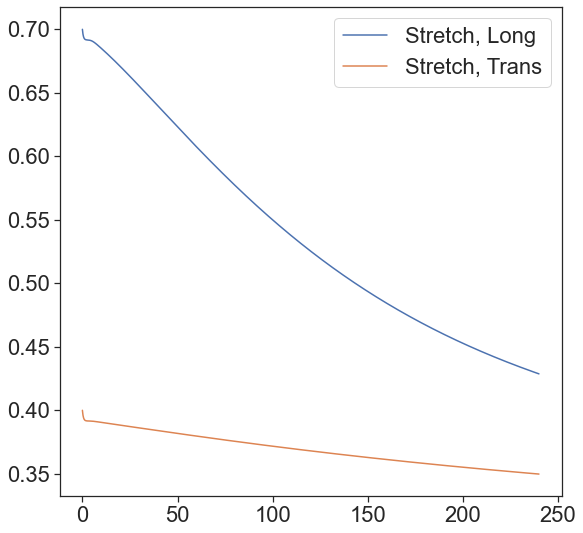

In [36]:
sns.set(font_scale=2)
sns.set_style("ticks", {'axes.grid' : False, 'font.sans-serif':'Arial'})
plt.figure(figsize=(9,9))
plt.plot(t_MA[:2400], y240_MA[:2400, node_ID.index('Stretch')], label = 'Stretch, Long')
plt.plot(t_MA[:2400], y240_MA_lo[:2400, node_ID.index('Stretch')], label = 'Stretch, Trans')
plt.legend(loc = 'best')
# plt.savefig('../figure/shortened_stretch.png', dpi = 300)
plt.show()

In [42]:
colchoices = sns.color_palette()

In [43]:
geneset = set(genes)

In [44]:
colchoices

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

### the following for defense only

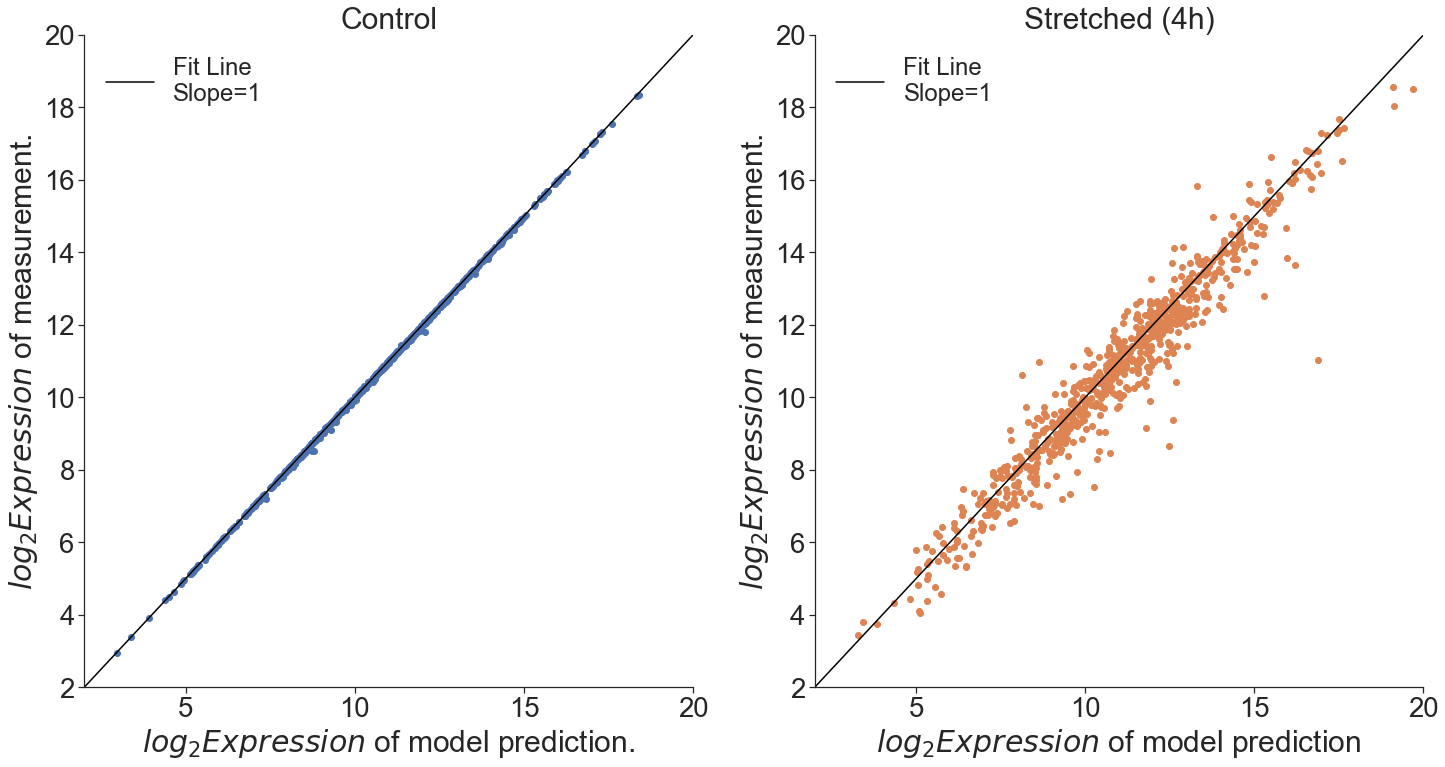

In [127]:
sns.set(font_scale=2.5)
sns.set_style("ticks", {'axes.grid' : False, 'font.sans-serif':'Arial'})
plt.figure(figsize=(24,12))
plt.subplot(1,2,1)

plt.scatter(
    np.log2(y240_MA_control[2399, with_data]),
    np.log2(np.array(y0_MA)[with_data]),
    color = colchoices[0]
)
plt.xlim((2,20))
plt.ylim((2,20))

plt.plot(
    np.arange(2, 20, 0.01), 
    np.arange(2, 20, 0.01), 
    label='Fit Line\nSlope=1',
    color = 'black'
)

plt.title('Control')
plt.ylabel(r'$log_2 Expression$ of measurement.')
plt.xlabel(r'$log_2 Expression$ of model prediction.')
plt.legend(loc = 'best', frameon = False, fontsize = 24)

plt.subplot(1,2,2)

plt.scatter(
    np.log2(y240_MA[2399, with_data]),
    np.log2(np.array(y4h_MA)[with_data]),
    color = colchoices[1]
)
plt.xlim((2,20))
plt.ylim((2,20))
plt.plot(
    np.arange(2, 20, 0.01), 
    np.arange(2, 20, 0.01), 
    label='Fit Line\nSlope=1',
    color = 'black'
)

plt.title('Stretched (4h)')
plt.ylabel(r'$log_2 Expression$ of measurement.')
plt.xlabel(r'$log_2 Expression$ of model prediction')
plt.legend(loc = 'best', frameon = False, fontsize = 24)


sns.despine()
# plt.savefig('../figure/FinalFigures_v2/FigS_def_StretchandControl_develop.png', dpi = 300)
plt.show()

In [130]:
index_byTF = []
for i in TFs:
    index_byTF.append(revi_edges[revi_edges['Start']==i]['End_Index'].tolist())

In [138]:
toplot_byTF = pd.DataFrame(columns = ['TF', 'Gene', 'log2FC'])
for i in range(len(index_byTF)):
    for j in index_byTF[i]:
        toplot_byTF.loc[len(toplot_byTF)] = [TFs[i], node_ID[j][5:], np.log2(y240_MA[2399, j]/y4h_MA[j])]

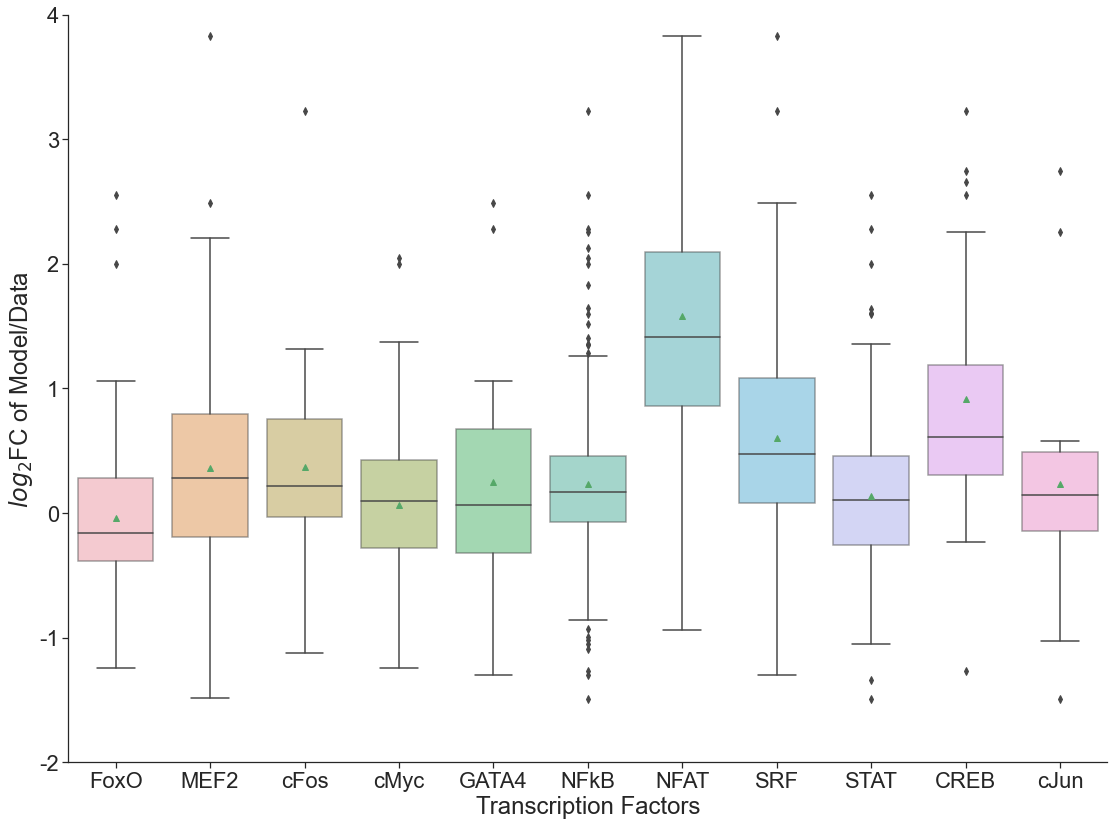

In [143]:
sns.set(font_scale=2)
sns.set_style("ticks", {'axes.grid' : False, 'font.sans-serif':'Arial'})
plt.figure(figsize=(16, 12))
sns.boxplot(
    x="TF", 
    y="log2FC", 
    data=toplot_byTF, 
    showmeans=True,
    boxprops=dict(alpha=.5)
)
plt.ylabel(r'$log_2$FC of Model/Data')
plt.xlabel('Transcription Factors')
plt.yticks(np.arange(-2,4.1,1), ('-2', '-1', '0', '1', '2', '3', '4'))
plt.ylim(-2,4)
sns.despine()
plt.tight_layout()
# plt.savefig('../figure/TestFigures/log2fc_error_boxplot.png', dpi = 300)
plt.show()

## Figure 1

### Fig 1A: Venn Diagram

In [45]:
from venn import venn

ModuleNotFoundError: No module named 'venn'

In [46]:
dataset_dict = {
    'Trans': set(
        RNA_raw[
            (
                (RNA_raw['q_value']<=0.05) &\
                (abs(RNA_raw['log2FC'])>=0.5)
            ) |\
            (
                (RNA_raw['q_value.2']<=0.05) &\
                (abs(RNA_raw['log2FC.2'])>=0.5)
            )
        ]['Row.names']
    ),
    'Long': set(
        RNA_raw[
            (
                (RNA_raw['q_value.1']<=0.05) &\
                (abs(RNA_raw['log2FC.1'])>=0.5)
            ) |\
            (
                (RNA_raw['q_value.3']<=0.05) &\
                (abs(RNA_raw['log2FC.3'])>=0.5)
            )
        ]['Row.names']
    )
}

In [47]:
a1 = [
    sns.color_palette("Paired")[1], 
    sns.color_palette("Paired")[5],
]

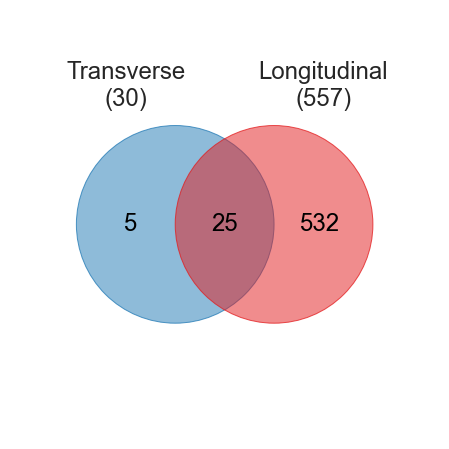

In [43]:
sns.set(font_scale=2.5)
sns.set_style("ticks", {'axes.grid' : False, 'font.sans-serif':'Arial'})
venn(
    dataset_dict,
    cmap=a1, 
    fontsize=24, 
    legend_loc=None,
    figsize = (8, 8),
    alpha = 0.5
)
sns.despine()
plt.text(0.25, 0.85, 'Transverse\n(30)', fontsize = 24, ha='center', va='center')
plt.text(0.75, 0.85, 'Longitudinal\n(557)', fontsize = 24, ha='center', va='center')
# plt.savefig('../figure/FinalFigures_v2/Fig1A.png', dpi = 300)
plt.show()

In [47]:
len(dataset_dict['Trans'].difference(dataset_dict['Long']).intersection(genes))

1

### Fig 1B: Clustering Analysis

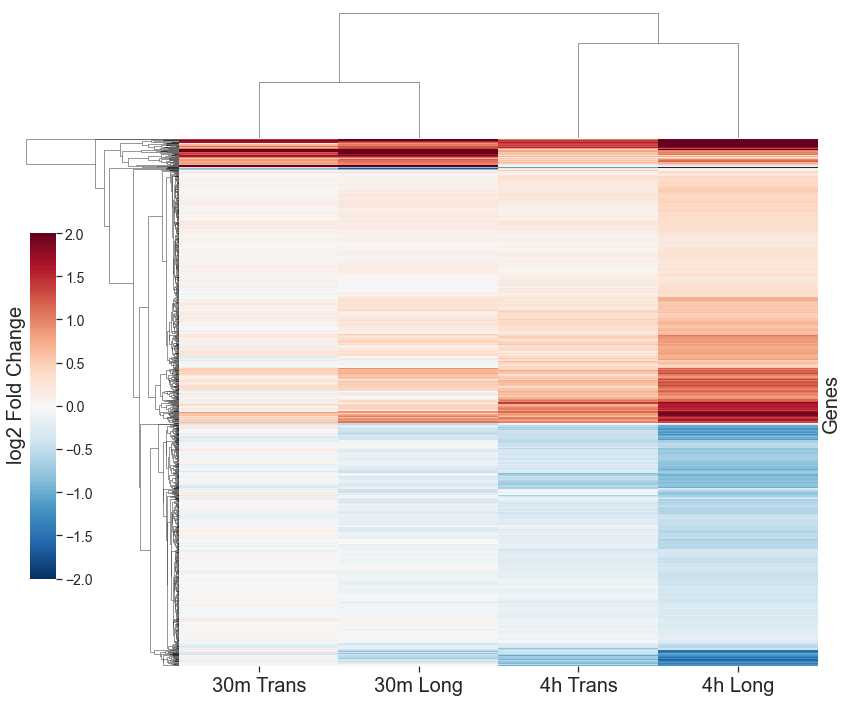

In [58]:
RNA_com_matrix = RNA_raw[
    (RNA_raw['q_value'] <= 0.05) |\
    (RNA_raw['q_value.1'] <= 0.05) |\
    (RNA_raw['q_value.2'] <= 0.05) |\
    (RNA_raw['q_value.3'] <= 0.05)
][
    ['log2FC','log2FC.1','log2FC.2','log2FC.3']
]
RNA_com_matrix = RNA_com_matrix.rename(
    columns = {
        'log2FC':'30m Trans',
        'log2FC.1':'30m Long',
        'log2FC.2':'4h Trans',
        'log2FC.3':'4h Long',
    }
)
sns.set(font_scale=2.5)
sns.set_style("ticks", {'axes.grid' : False, 'font.sans-serif':'Arial'})
ax_plot = sns.clustermap(
    RNA_com_matrix, 
    cmap="RdBu_r", 
    xticklabels=True, 
    yticklabels=False, 
    vmin=-2, 
    vmax=2, 
    figsize= (12,12),
    cbar_pos=(0.05, .3, 0.03, .4)
)
ax_plot.ax_heatmap.set_xticklabels(
    ax_plot.ax_heatmap.get_xticklabels(), 
    rotation=0, 
    fontproperties = chf, 
    size = 20)
ax_plot.ax_heatmap.set_ylabel('Genes', fontproperties = chf, size = 20) 
plt.tick_params(labelsize = 14)
plt.text(-4, 0.25, 'log2 Fold Change', fontsize = 20, ha='center', va='center', rotation = 90)
# plt.savefig('../figure/FinalFigures_v2/Fig1B_DE_clustering_v2.png', dpi = 300)
plt.show()

In [59]:
hierclusters = ax_plot.dendrogram_row.reordered_ind

In [60]:
RNA_com_matrix_indexes = RNA_com_matrix.index.tolist()

In [61]:
up_up_up_up = []
do_do_do_do = []
up_do_up_up = []
up_do_up_do = []
up_up_up_do = []
do_up_do_up = []
up_up_do_do = []
do_do_up_up = []
restgenes = []
for i in RNA_com_matrix_indexes:
    a = RNA_com_matrix.loc[i, ].values
    if 0 < a[0] < a[2] and 0 < a[1] < a[3]:
        up_up_up_up.append(i)
    elif 0 > a[0] > a[2] and 0 > a[1] > a[3]:
        do_do_do_do.append(i)
    elif a[0] > a[2] > 0 and 0 < a[1] < a[3]:
        up_do_up_up.append(i)
    elif a[0] > a[2] > 0 and a[1] > a[3] > 0:
        up_do_up_do.append(i)
    elif 0 < a[0] < a[2] and a[1] > a[3] > 0:
        up_up_up_do.append(i)
    elif a[0] < a[2] < 0 and a[1] < a[3] < 0:
        do_up_do_up.append(i)
    elif a[0] < a[2] < 0 and a[1] < a[3] < 0:
        do_up_do_up.append(i)
    elif a[0] < a[2] < 0 and a[1] < a[3] < 0:
        do_up_do_up.append(i)
    else:
        restgenes.append(i)

In [62]:
diff_count_01 = []
diff_count_02 = []
diff_count_03 = []
for i in RNA_com_matrix_indexes:
    a = RNA_com_matrix.loc[i, ].values
    if a[2]*a[3] < 0 and a[0]*a[1] < 0:
        diff_count_01.append(i)
    elif a[0]*a[1] < 0:
        diff_count_02.append(i)
    elif a[2]*a[3] < 0:
        diff_count_03.append(i)

In [63]:
RNA_com_matrix.loc[diff_count_01, ]

,30m Trans,30m Long,4h Trans,4h Long
Inpp5e,0.004386,-0.157187,0.080908,-0.281719
Pik3r4,0.005623,-0.064229,0.007969,-0.279358
Rgl1,-0.015702,0.001898,0.014766,-0.341478
Rpl7l1,-0.001989,0.053432,-0.040613,0.190791
Syn3,0.027059,-0.141420,0.012660,-0.524093
Tyw5,-0.024182,0.159513,-0.017116,0.450255


In [49]:
# RNA_full = RNA_raw[
#     ['log2FC','log2FC.1','log2FC.2','log2FC.3']
# ]
# RNA_full = RNA_full.rename(
#     columns = {
#         'log2FC':'30m Trans',
#         'log2FC.1':'30m Long',
#         'log2FC.2':'4h Trans',
#         'log2FC.3':'4h Long',
#     }
# )
# sns.set(font_scale=2.5)
# sns.set_style("ticks", {'axes.grid' : False, 'font.sans-serif':'Arial'})
# ax_plot = sns.clustermap(
#     RNA_full, 
#     cmap="RdBu_r", 
#     xticklabels=True, 
#     yticklabels=False, 
#     vmin=-2, 
#     vmax=2, 
#     figsize= (12,12),
#     cbar_pos=(0.05, .3, 0.03, .4)
# )
# ax_plot.ax_heatmap.set_xticklabels(
#     ax_plot.ax_heatmap.get_xticklabels(), 
#     rotation=0, 
#     fontproperties = chf, 
#     size = 20)
# ax_plot.ax_heatmap.set_ylabel('Genes', fontproperties = chf, size = 20) 
# plt.tick_params(labelsize = 14)
# plt.text(-4, 0.25, 'log2 Fold Change', fontsize = 20, ha='center', va='center', rotation = 90)
# # plt.savefig('../figure/FinalFigures_v2/FigS1A_DE_clustering_on_allgenes.png', dpi = 300)
# plt.show()

### Fig 1C: KEGG Enrichment Analysis

In [64]:
kegg_DE_4_L = pd.read_table('../data/UpdatedMyocyte/Raw/kegg_DE_4_L_thre.txt', sep = '\t')
kegg_DE_4_L_term = kegg_DE_4_L['Term'].tolist()
kegg_DE_4_L_term = [i.split(':')[1] for i in kegg_DE_4_L_term]
kegg_DE_4_L['Process'] = kegg_DE_4_L_term
kegg_DE_4_L_FDR = kegg_DE_4_L['FDR'].tolist()
kegg_DE_4_L_FDR = [np.log10(i) for i in kegg_DE_4_L_FDR]
kegg_DE_4_L['log10FDR'] = kegg_DE_4_L_FDR

In [65]:
kegg_DE_4_T = pd.read_table('../data/UpdatedMyocyte/Raw/kegg_DE_4_T_thre.txt', sep = '\t')
kegg_DE_4_T_term = kegg_DE_4_T['Term'].tolist()
kegg_DE_4_T_term = [i.split(':')[1] for i in kegg_DE_4_T_term]
kegg_DE_4_T['Process'] = kegg_DE_4_T_term
kegg_DE_4_T_FDR = kegg_DE_4_T['FDR'].tolist()
kegg_DE_4_T_FDR = [np.log10(i) for i in kegg_DE_4_T_FDR]
kegg_DE_4_T['log10FDR'] = kegg_DE_4_T_FDR

In [66]:
kegg_DE_30_L = pd.read_table('../data/UpdatedMyocyte/Raw/kegg_DE_30_L_thre.txt', sep = '\t')
kegg_DE_30_L_term = kegg_DE_30_L['Term'].tolist()
kegg_DE_30_L_term = [i.split(':')[1] for i in kegg_DE_30_L_term]
kegg_DE_30_L['Process'] = kegg_DE_30_L_term
kegg_DE_30_L_FDR = kegg_DE_30_L['FDR'].tolist()
kegg_DE_30_L_FDR = [np.log10(i) for i in kegg_DE_30_L_FDR]
kegg_DE_30_L['log10FDR'] = kegg_DE_30_L_FDR

In [67]:
kegg_DE_30_T = pd.read_table('../data/UpdatedMyocyte/Raw/kegg_DE_30_T_thre.txt', sep = '\t')
kegg_DE_30_T_term = kegg_DE_30_T['Term'].tolist()
kegg_DE_30_T_term = [i.split(':')[1] for i in kegg_DE_30_T_term]
kegg_DE_30_T['Process'] = kegg_DE_30_T_term
kegg_DE_30_T_FDR = kegg_DE_30_T['FDR'].tolist()
kegg_DE_30_T_FDR = [np.log10(i) for i in kegg_DE_30_T_FDR]
kegg_DE_30_T['log10FDR'] = kegg_DE_30_T_FDR

In [68]:
kegg_DE_4_L.index = kegg_DE_4_L['Process'].tolist()
kegg_DE_4_T.index = kegg_DE_4_T['Process'].tolist()
kegg_DE_30_L.index = kegg_DE_30_L['Process'].tolist()
kegg_DE_30_T.index = kegg_DE_30_T['Process'].tolist()

In [69]:
toshow = kegg_DE_4_L[kegg_DE_4_L['PValue']<=0.05].index.tolist()

In [70]:
toshow_results = pd.DataFrame(columns = ['Pathways', '30m', 'Intersection', 'Union'])
for i in toshow:
    a_30_T = set()
    a_30_L = set()
    a_4_T = set()
    a_4_L = set()
    if i in kegg_DE_30_T.index:
        if kegg_DE_30_T.loc[i, 'PValue'] <= 0.05:
            a_30_T = set(kegg_DE_30_T.loc[i, 'Genes'].split(', '))
    if i in kegg_DE_30_L.index:
        if kegg_DE_30_L.loc[i, 'PValue'] <= 0.05:
            a_30_L = set(kegg_DE_30_L.loc[i, 'Genes'].split(', '))
    if i in kegg_DE_4_T.index:
        if kegg_DE_4_T.loc[i, 'PValue'] <= 0.05:
            a_4_T = set(kegg_DE_4_T.loc[i, 'Genes'].split(', '))
    if i in kegg_DE_4_L.index:
        if kegg_DE_4_L.loc[i, 'PValue'] <= 0.05:
            a_4_L = set(kegg_DE_4_L.loc[i, 'Genes'].split(', '))
    a_30 = a_30_T.union(a_30_L)
    a_4 = a_4_T.union(a_4_L)
    a_30_only = a_30.difference(a_4)
    a_both = a_30.intersection(a_4)
    a_4h_only = a_4.difference(a_30)
    toshow_results.loc[len(toshow_results)] = [
        i, 
        len(a_30_only), 
        len(a_30_only)+len(a_both),
        len(a_30_only)+len(a_both)+len(a_4h_only),
    ]
toshow_results.index = toshow

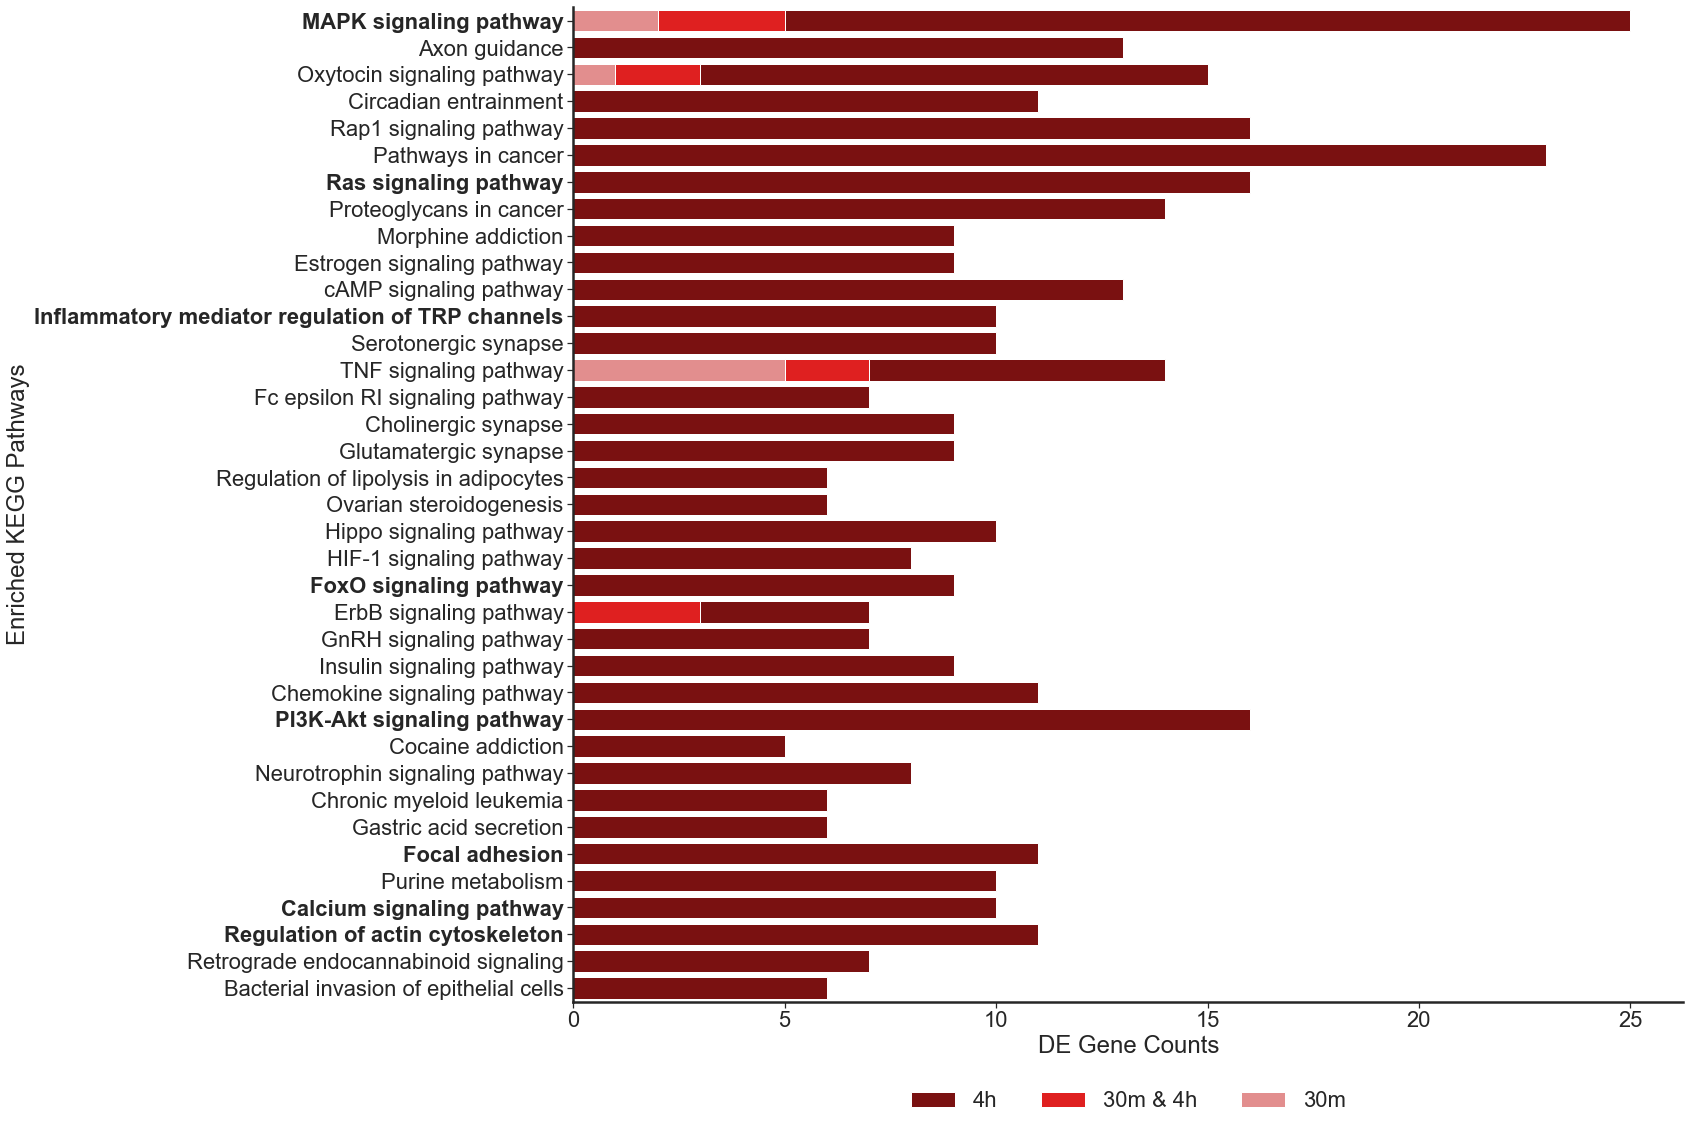

In [13]:
sns.set(font_scale=2)
sns.set_context(rc={"lines.linewidth": 5})
sns.set_style("ticks", {'axes.grid' : False, 'font.sans-serif':'Arial'})
plt.figure(figsize = (24,16))
ax = sns.barplot(
    x="Union", 
    y="Pathways", 
    color="darkred", 
    data = toshow_results, 
    orient='h',
    label = '4h'
)
ax = sns.barplot(
    x="Intersection", 
    y="Pathways", 
    color="red", 
    data = toshow_results, 
    orient='h',
    label = '30m & 4h'
)
ax = sns.barplot(
    x="30m", 
    y="Pathways", 
    color="lightcoral", 
    data = toshow_results, 
    orient='h',
    label = '30m'
)

plt.xticks(np.array([0, 5, 10, 15, 20, 25]), ('0', '5', '10', '15', '20', '25'))
ax.get_yticklabels()[toshow.index('MAPK signaling pathway')].set_fontweight('bold')
# ax.get_yticklabels()[toshow.index('MAPK signaling pathway')].set_color("red")
ax.get_yticklabels()[toshow.index('FoxO signaling pathway')].set_fontweight('bold')
ax.get_yticklabels()[toshow.index('Ras signaling pathway')].set_fontweight('bold')
ax.get_yticklabels()[toshow.index('Inflammatory mediator regulation of TRP channels')].set_fontweight('bold')
ax.get_yticklabels()[toshow.index('PI3K-Akt signaling pathway')].set_fontweight('bold')
ax.get_yticklabels()[toshow.index('Focal adhesion')].set_fontweight('bold')
ax.get_yticklabels()[toshow.index('Calcium signaling pathway')].set_fontweight('bold')
ax.get_yticklabels()[toshow.index('Regulation of actin cytoskeleton')].set_fontweight('bold')
plt.xlabel('DE Gene Counts')
plt.ylabel('Enriched KEGG Pathways')
sns.despine()
ax.spines['bottom'].set_linewidth(2.5)
ax.spines['left'].set_linewidth(2.5)
plt.legend(loc='center', bbox_to_anchor = (0.5, -0.1), ncol = 3, frameon = False)
plt.tight_layout()
# plt.savefig('../figure/FinalFigures_v2/Fig1B_KEGG.png', dpi=600)
plt.show()

In [71]:
mapkgenelist = kegg_DE_4_L.loc['FoxO signaling pathway', 'Genes'].split(', ')
mapkgenelist = list(map(lambda i: i[0]+i[1:].lower(), mapkgenelist))

In [72]:
mapkgenelist_index = list(map(lambda x: RNA_com_matrix_indexes.index(x), mapkgenelist))

In [73]:
mapkgenelist_index_reorder = list(map(lambda x: hierclusters.index(x), mapkgenelist_index))

In [74]:
mapkgenelist_index_reorder

[49, 541, 445, 1027, 333, 1021, 494, 791, 719]

### Fig 1D: PCR vs. RNA-Seq

In [75]:
oridata = pd.read_csv('~/Desktop/projects/lab/Tests/data/rna_seq_validation.csv', header = 0)

In [76]:
chf_v4 = font_manager.FontProperties(fname='/home/shulincao/Desktop/arial.ttf', size = 24)
chf_title = font_manager.FontProperties(fname='/home/shulincao/Desktop/arial.ttf', 
                                        size = 28, 
                                        weight = 'heavy')

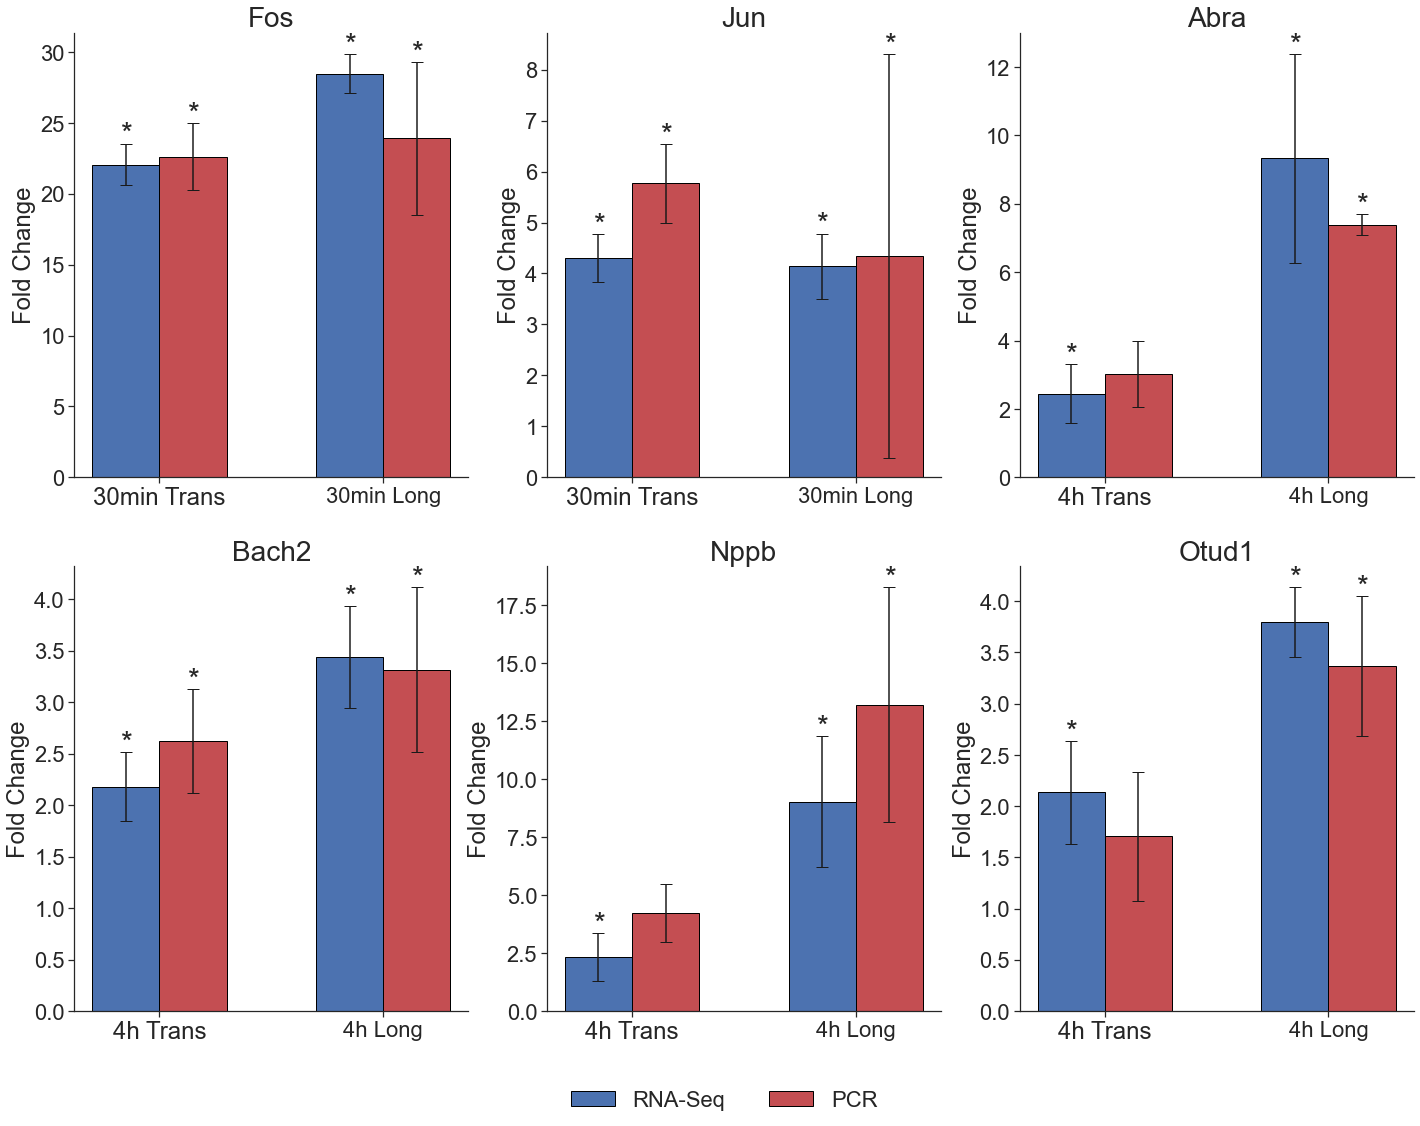

In [73]:
sns.set(font_scale=2)
sns.set_style("ticks", {'axes.grid' : False, 'font.sans-serif':'Arial'})
plt.figure(figsize=(24,18))
barWidth = 0.2

plt.subplot(2, 3, 1)
bars1 = oridata[(oridata['Gene']=='Fos') & (oridata['Type']=='RNA-Seq')]['Average'].tolist()
bars2 = oridata[(oridata['Gene']=='Fos') & (oridata['Type']=='PCR')]['Average'].tolist()
yer1 = oridata[(oridata['Gene']=='Fos') & (oridata['Type']=='RNA-Seq')]['SE'].tolist()
yer2 = oridata[(oridata['Gene']=='Fos') & (oridata['Type']=='PCR')]['SE'].tolist()
r1 = np.arange(len(bars1))*2/3
r2 = [x + barWidth for x in r1]

plt.bar(r1, bars1, width = barWidth, color = colchoices[0], edgecolor = 'black', yerr=yer1, capsize=6)
plt.bar(r2, bars2, width = barWidth, color = colchoices[3], edgecolor = 'black', yerr=yer2, capsize=6)
plt.text(r1[0], bars1[0]+yer1[0], '*', fontsize=30, horizontalalignment='center')
plt.text(r1[1], bars1[1]+yer1[1], '*', fontsize=30, horizontalalignment='center')
plt.text(r2[0], bars2[0]+yer2[0], '*', fontsize=30, horizontalalignment='center')
plt.text(r2[1], bars2[1]+yer2[1], '*', fontsize=30, horizontalalignment='center')

plt.xticks([r + barWidth/2 for r in r1], ['30min Trans', '30min Long'], fontproperties = chf_v4)
plt.ylabel('Fold Change', fontproperties = chf_v4)
plt.title('Fos', fontproperties = chf_title)

plt.subplot(2, 3, 2)
bars1 = oridata[(oridata['Gene']=='Jun') & (oridata['Type']=='RNA-Seq')]['Average'].tolist()
bars2 = oridata[(oridata['Gene']=='Jun') & (oridata['Type']=='PCR')]['Average'].tolist()
yer1 = oridata[(oridata['Gene']=='Jun') & (oridata['Type']=='RNA-Seq')]['SE'].tolist()
yer2 = oridata[(oridata['Gene']=='Jun') & (oridata['Type']=='PCR')]['SE'].tolist()
r1 = np.arange(len(bars1))*2/3
r2 = [x + barWidth for x in r1]

plt.bar(r1, bars1, width = barWidth, color = colchoices[0], edgecolor = 'black', yerr=yer1, capsize=6)
plt.bar(r2, bars2, width = barWidth, color = colchoices[3], edgecolor = 'black', yerr=yer2, capsize=6)
plt.text(r1[0], bars1[0]+yer1[0], '*', fontsize=30, horizontalalignment='center')
plt.text(r1[1], bars1[1]+yer1[1], '*', fontsize=30, horizontalalignment='center')
plt.text(r2[0], bars2[0]+yer2[0], '*', fontsize=30, horizontalalignment='center')
plt.text(r2[1], bars2[1]+yer2[1], '*', fontsize=30, horizontalalignment='center')

plt.xticks([r + barWidth/2 for r in r1], ['30min Trans', '30min Long'], fontproperties = chf_v4)
plt.ylabel('Fold Change', fontproperties = chf_v4)
plt.title('Jun', fontproperties = chf_title)

plt.subplot(2, 3, 3)
bars1 = oridata[(oridata['Gene']=='Abra') & (oridata['Type']=='RNA-Seq')]['Average'].tolist()
bars2 = oridata[(oridata['Gene']=='Abra') & (oridata['Type']=='PCR')]['Average'].tolist()
yer1 = oridata[(oridata['Gene']=='Abra') & (oridata['Type']=='RNA-Seq')]['SE'].tolist()
yer2 = oridata[(oridata['Gene']=='Abra') & (oridata['Type']=='PCR')]['SE'].tolist()
r1 = np.arange(len(bars1))*2/3
r2 = [x + barWidth for x in r1]

plt.bar(r1, bars1, width = barWidth, color = colchoices[0], edgecolor = 'black', yerr=yer1, capsize=6)
plt.bar(r2, bars2, width = barWidth, color = colchoices[3], edgecolor = 'black', yerr=yer2, capsize=6)
plt.text(r1[0], bars1[0]+yer1[0], '*', fontsize=30, horizontalalignment='center')
plt.text(r1[1], bars1[1]+yer1[1], '*', fontsize=30, horizontalalignment='center')
#plt.text(r2[0], bars2[0]+yer2[0], '*', fontsize=30, horizontalalignment='center')
plt.text(r2[1], bars2[1]+yer2[1], '*', fontsize=30, horizontalalignment='center')

plt.xticks([r + barWidth/2 for r in r1], ['4h Trans', '4h Long'], fontproperties = chf_v4)
plt.ylabel('Fold Change', fontproperties = chf_v4)
plt.title('Abra', fontproperties = chf_title)

plt.subplot(2, 3, 4)
bars1 = oridata[(oridata['Gene']=='Bach2') & (oridata['Type']=='RNA-Seq')]['Average'].tolist()
bars2 = oridata[(oridata['Gene']=='Bach2') & (oridata['Type']=='PCR')]['Average'].tolist()
yer1 = oridata[(oridata['Gene']=='Bach2') & (oridata['Type']=='RNA-Seq')]['SE'].tolist()
yer2 = oridata[(oridata['Gene']=='Bach2') & (oridata['Type']=='PCR')]['SE'].tolist()
r1 = np.arange(len(bars1))*2/3
r2 = [x + barWidth for x in r1]

plt.bar(r1, bars1, width = barWidth, color = colchoices[0], edgecolor = 'black', yerr=yer1, capsize=6)
plt.bar(r2, bars2, width = barWidth, color = colchoices[3], edgecolor = 'black', yerr=yer2, capsize=6)
plt.text(r1[0], bars1[0]+yer1[0], '*', fontsize=30, horizontalalignment='center')
plt.text(r1[1], bars1[1]+yer1[1], '*', fontsize=30, horizontalalignment='center')
plt.text(r2[0], bars2[0]+yer2[0], '*', fontsize=30, horizontalalignment='center')
plt.text(r2[1], bars2[1]+yer2[1], '*', fontsize=30, horizontalalignment='center')

plt.xticks([r + barWidth/2 for r in r1], ['4h Trans', '4h Long'], fontproperties = chf_v4)
plt.ylabel('Fold Change', fontproperties = chf_v4)
plt.title('Bach2', fontproperties = chf_title)


plt.subplot(2, 3, 5)
bars1 = oridata[(oridata['Gene']=='Nppb') & (oridata['Type']=='RNA-Seq')]['Average'].tolist()
bars2 = oridata[(oridata['Gene']=='Nppb') & (oridata['Type']=='PCR')]['Average'].tolist()
yer1 = oridata[(oridata['Gene']=='Nppb') & (oridata['Type']=='RNA-Seq')]['SE'].tolist()
yer2 = oridata[(oridata['Gene']=='Nppb') & (oridata['Type']=='PCR')]['SE'].tolist()
r1 = np.arange(len(bars1))*2/3
r2 = [x + barWidth for x in r1]

plt.bar(r1, bars1, width = barWidth, color = colchoices[0], edgecolor = 'black', yerr=yer1, capsize=6)
plt.bar(r2, bars2, width = barWidth, color = colchoices[3], edgecolor = 'black', yerr=yer2, capsize=6)
plt.text(r1[0], bars1[0]+yer1[0], '*', fontsize=30, horizontalalignment='center')
plt.text(r1[1], bars1[1]+yer1[1], '*', fontsize=30, horizontalalignment='center')
#plt.text(r2[0], bars2[0]+yer2[0], '*', fontsize=30, horizontalalignment='center')
plt.text(r2[1], bars2[1]+yer2[1], '*', fontsize=30, horizontalalignment='center')

plt.xticks([r + barWidth/2 for r in r1], ['4h Trans', '4h Long'], fontproperties = chf_v4)
plt.ylabel('Fold Change', fontproperties = chf_v4)
plt.title('Nppb', fontproperties = chf_title)

plt.subplot(2, 3, 6)
bars1 = oridata[(oridata['Gene']=='Otud1') & (oridata['Type']=='RNA-Seq')]['Average'].tolist()
bars2 = oridata[(oridata['Gene']=='Otud1') & (oridata['Type']=='PCR')]['Average'].tolist()
yer1 = oridata[(oridata['Gene']=='Otud1') & (oridata['Type']=='RNA-Seq')]['SE'].tolist()
yer2 = oridata[(oridata['Gene']=='Otud1') & (oridata['Type']=='PCR')]['SE'].tolist()
r1 = np.arange(len(bars1))*2/3
r2 = [x + barWidth for x in r1]

plt.bar(r1, bars1, width = barWidth, color = colchoices[0], edgecolor = 'black', yerr=yer1, capsize=6, label = 'RNA-Seq')
plt.bar(r2, bars2, width = barWidth, color = colchoices[3], edgecolor = 'black', yerr=yer2, capsize=6, label = 'PCR')
plt.text(r1[0], bars1[0]+yer1[0], '*', fontsize=30, horizontalalignment='center')
plt.text(r1[1], bars1[1]+yer1[1], '*', fontsize=30, horizontalalignment='center')
#plt.text(r2[0], bars2[0]+yer2[0], '*', fontsize=30, horizontalalignment='center')
plt.text(r2[1], bars2[1]+yer2[1], '*', fontsize=30, horizontalalignment='center')

plt.xticks([r + barWidth/2 for r in r1], ['4h Trans', '4h Long'], fontproperties = chf_v4)
plt.ylabel('Fold Change', fontproperties = chf_v4)
plt.title('Otud1', fontproperties = chf_title)
plt.legend(loc='center', bbox_to_anchor = (-0.75, -0.2), ncol = 2, frameon = False)
sns.despine()
# plt.savefig('../figure/FinalFigures_v2/Fig1D_PCR_vali.png', dpi = 300)
plt.show()

## Figure 2
### Long vs Trans at 30m and 4h

In [77]:
DE_30m = RNA_raw[
    (
        (RNA_raw['q_value'] <= 0.05) & \
        (abs(RNA_raw['log2FC']) >= 0.5)
    ) |\
    (
        (RNA_raw['q_value.1'] <= 0.05) & \
        (abs(RNA_raw['log2FC.1']) >= 0.5)
    )
]['Row.names'].tolist()

In [78]:
DE_4h = RNA_raw[
    (
        (RNA_raw['q_value.2'] <= 0.05) & \
        (abs(RNA_raw['log2FC.2']) >= 0.5)
    ) |\
    (
        (RNA_raw['q_value.3'] <= 0.05) & \
        (abs(RNA_raw['log2FC.3']) >= 0.5)
    )
]['Row.names'].tolist()

In [79]:
DE_4h_more = RNA_raw[
    (RNA_raw['q_value.2'] <= 0.05) |\
    (RNA_raw['q_value.3'] <= 0.05)
]['Row.names'].tolist()
DE_30m_more = RNA_raw[
    (RNA_raw['q_value'] <= 0.05) |\
    (RNA_raw['q_value.1'] <= 0.05)
]['Row.names'].tolist()

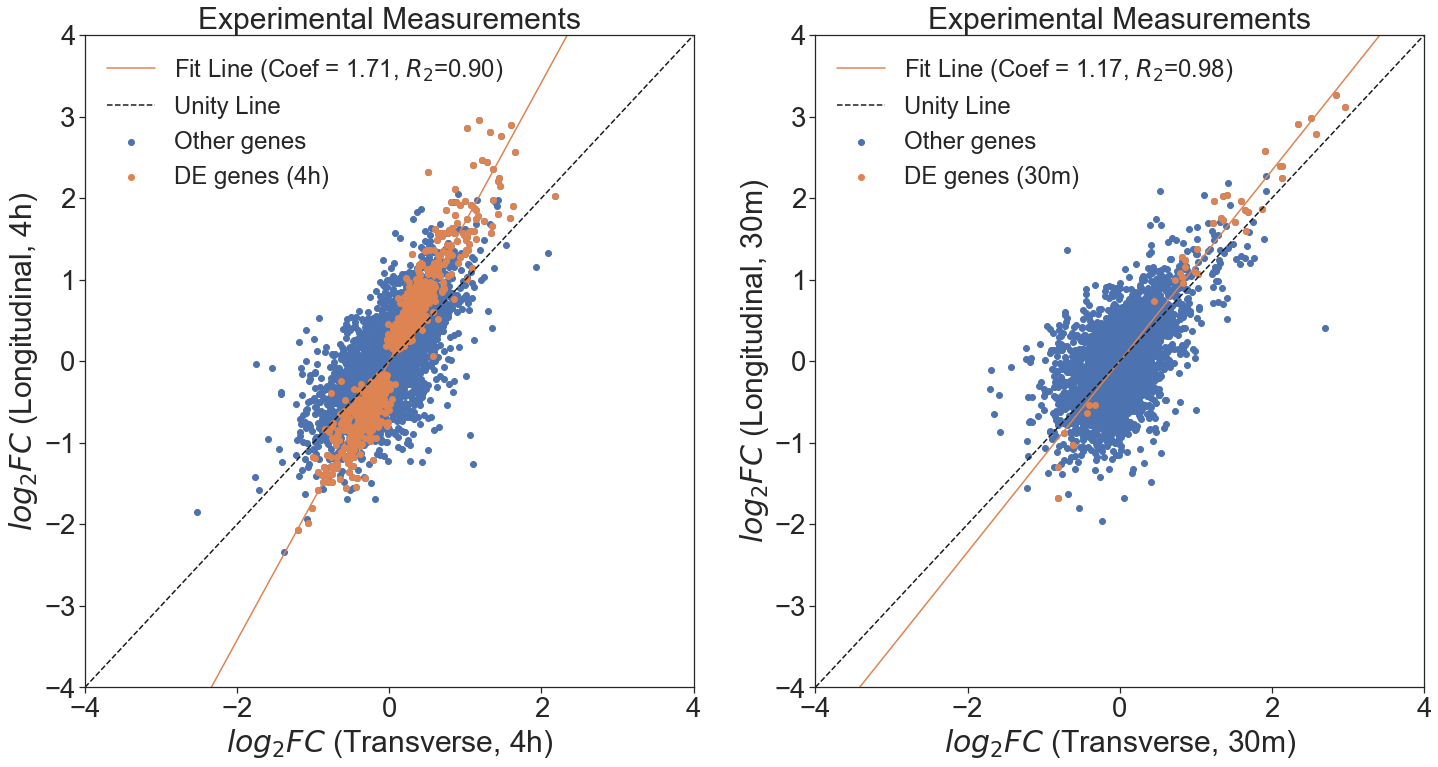

In [73]:
sns.set(font_scale=2.5)
sns.set_style("ticks", {'axes.grid' : False, 'font.sans-serif':'Arial'})
plt.figure(figsize=(24,12))
plt.subplot(1,2,1)
plt.scatter(
    RNA['log2FC.2'],
    RNA['log2FC.3'],
    label = 'Other genes'
)
plt.scatter(
    RNA.loc[DE_4h_more, 'log2FC.2'],
    RNA.loc[DE_4h_more, 'log2FC.3'],
    label = 'DE genes (4h)'
)
plt.plot(
    np.arange(-4, 4, 0.01), 
    1.71*np.arange(-4, 4, 0.01), 
    label=r'Fit Line (Coef = 1.71, $R_2$=0.90)',
    color = colchoices[1]
)

plt.plot(
    np.arange(-4, 4, 0.01), 
    np.arange(-4, 4, 0.01), 
    'k--',
    label='Unity Line'
)

plt.xlim((-4,4))
plt.ylim((-4,4))

plt.title('Experimental Measurements')
plt.xlabel(r'$log_2 FC$ (Transverse, 4h)')
plt.ylabel(r'$log_2 FC$ (Longitudinal, 4h)')
plt.legend(loc = 'upper left', frameon = False, fontsize = 24)

plt.subplot(1,2,2)
plt.scatter(
    RNA['log2FC'],
    RNA['log2FC.1'],
    label = 'Other genes'
)
plt.scatter(
    RNA.loc[DE_30m_more, 'log2FC'],
    RNA.loc[DE_30m_more, 'log2FC.1'],
    label = 'DE genes (30m)'
)
plt.plot(
    np.arange(-4, 4, 0.01), 
    1.17*np.arange(-4, 4, 0.01), 
    label=r'Fit Line (Coef = 1.17, $R_2$=0.98)',
    color = colchoices[1]
)

plt.plot(
    np.arange(-4, 4, 0.01), 
    np.arange(-4, 4, 0.01), 
    'k--',
    label='Unity Line'
)

plt.xlim((-4,4))
plt.ylim((-4,4))

plt.title('Experimental Measurements')
plt.xlabel(r'$log_2 FC$ (Transverse, 30m)')
plt.ylabel(r'$log_2 FC$ (Longitudinal, 30m)')
plt.legend(loc = 'upper left', frameon = False, fontsize = 24)
# plt.savefig('../figure/FinalFigures_v2/Fig2_TransvsLong_4h_30m_dataonly.png', dpi = 300)
plt.show()

In [74]:
X_4h = np.array([[i] for i in RNA.loc[DE_4h_more, 'log2FC.2']])
reg_4h = LinearRegression(fit_intercept = False).fit(X_4h, RNA.loc[DE_4h_more, 'log2FC.3'])
print(
    reg_4h.coef_, 
    reg_4h.intercept_ , 
    reg_4h.score(X_4h, RNA.loc[DE_4h_more, 'log2FC.3'])
)

[1.71184374] 0.0 0.8973913537146868


In [75]:
ddd = sm.OLS(
    RNA.loc[DE_4h_more, 'log2FC.3'],
    RNA.loc[DE_4h_more, 'log2FC.2']
).fit()

In [76]:
print(ddd.summary())

                                 OLS Regression Results                                
Dep. Variable:               log2FC.3   R-squared (uncentered):                   0.899
Model:                            OLS   Adj. R-squared (uncentered):              0.898
Method:                 Least Squares   F-statistic:                              8956.
Date:                Tue, 17 Aug 2021   Prob (F-statistic):                        0.00
Time:                        23:05:46   Log-Likelihood:                         -43.386
No. Observations:                1012   AIC:                                      88.77
Df Residuals:                    1011   BIC:                                      93.69
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [77]:
X_30m = np.array([[i] for i in RNA.loc[DE_30m_more, 'log2FC']])
reg_30m = LinearRegression(fit_intercept = False).fit(X_30m, RNA.loc[DE_30m_more, 'log2FC.1'])
print(
    reg_30m.coef_, 
    reg_30m.intercept_ , 
    reg_30m.score(X_30m, RNA.loc[DE_30m_more, 'log2FC.1'])
)

[1.17459559] 0.0 0.9617769919781868


In [78]:
ddd_30 = sm.OLS(
    RNA.loc[DE_30m_more, 'log2FC.1'],
    RNA.loc[DE_30m_more, 'log2FC']
).fit()

In [79]:
print(ddd_30.summary())

                                 OLS Regression Results                                
Dep. Variable:               log2FC.1   R-squared (uncentered):                   0.982
Model:                            OLS   Adj. R-squared (uncentered):              0.982
Method:                 Least Squares   F-statistic:                              2163.
Date:                Tue, 17 Aug 2021   Prob (F-statistic):                    8.90e-36
Time:                        23:05:49   Log-Likelihood:                         -2.2114
No. Observations:                  40   AIC:                                      6.423
Df Residuals:                      39   BIC:                                      8.112
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [80]:
stats.ttest_1samp(RNA.loc[DE_30m_more, 'log2FC.1']/RNA.loc[DE_30m_more, 'log2FC'], 1)

Ttest_1sampResult(statistic=8.287778970691923, pvalue=3.9263871010026504e-10)

In [81]:
stats.ttest_1samp(RNA.loc[DE_4h_more, 'log2FC.3']/RNA.loc[DE_4h_more, 'log2FC.2'], 1)

Ttest_1sampResult(statistic=10.253368843365358, pvalue=1.5488041920208635e-23)

In [82]:
stats.ttest_ind(
    RNA.loc[DE_4h_more, 'log2FC.3']/RNA.loc[DE_4h_more, 'log2FC.2'],
    RNA.loc[DE_30m_more, 'log2FC.1']/RNA.loc[DE_30m_more, 'log2FC']
)

Ttest_indResult(statistic=1.6208785196853075, pvalue=0.10534393616261316)

In [83]:
stats.ks_2samp(
    RNA.loc[DE_4h_more, 'log2FC.3']/RNA.loc[DE_4h_more, 'log2FC.2'],
    RNA.loc[DE_30m_more, 'log2FC.1']/RNA.loc[DE_30m_more, 'log2FC']
)

KstestResult(statistic=0.6874505928853755, pvalue=6.661338147750939e-16)

## Figure 3
### This figure is edited in PPT

## Figure 4
### Fig 4A: Dynamics

In [84]:
time_points = ['0', '30', '60', '90', '120', '150', '180', '210', '240', '270', '300', '330', '360', '390', '420', '450', '480', '510', '540', '570', '600', '630', '660', '690', '720']
a0 = np.arange(0,7201,300)-1
a0[0] = 0
heatmap_mat_0 = y240_MA[a0]
heatmap_mat_1 = heatmap_mat_0[:, with_data]
heatmap_mat_2 = heatmap_mat_1/heatmap_mat_1[0]
heatmap_mat_4 = np.log2(heatmap_mat_2)
arr2 = heatmap_mat_4[:,np.argsort(heatmap_mat_4[8,:])[::-1]]
arr3 = arr2.transpose()
nmin = []
nmax = []
for k in range(len(with_data)):
    nmin.append(min(arr3[k,:]))
    nmax.append(max(arr3[k,:]))
arr3_df = pd.DataFrame(arr3, columns=time_points)

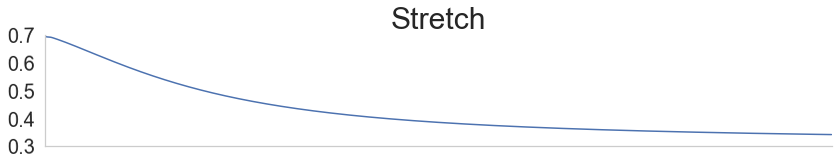

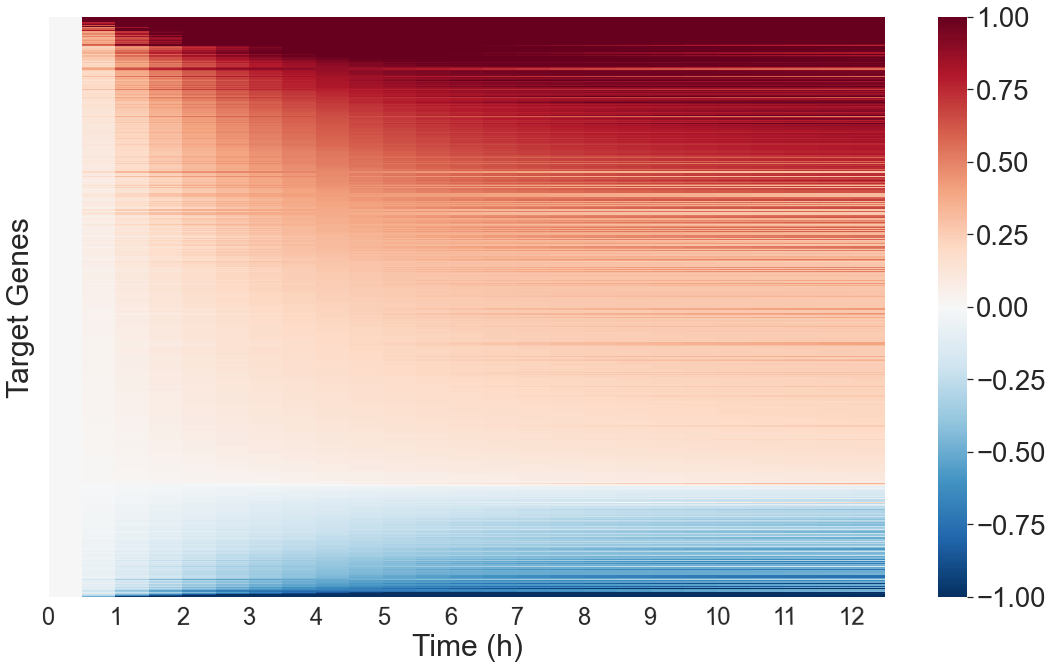

In [85]:
sns.set(font_scale=2.5)
sns.set_style("whitegrid", {'axes.grid' : False})
fig0 = plt.figure(figsize=(12.35,3))
plt.plot(t_MA[:12*60*10], y240_MA[:12*60*10,78])
plt.xlim((0,720))
plt.ylim((0.3,0.7))
plt.xticks([])

plt.title('Stretch', fontproperties =chf, fontsize = 30)
sns.despine()
plt.yticks([0.3,0.4,0.5,0.6,0.7], ('0.3', '0.4', '0.5', '0.6', '0.7'), rotation=1, fontproperties=chf, fontsize=20)
plt.tight_layout()
# plt.savefig('../figure/FinalFigures_v2/Fig4A_stretch.png', dpi = 300)
fig1 = plt.figure(figsize=(16,10))
ax = sns.heatmap(arr3_df, vmin=-1, vmax = 1, cmap="RdBu_r", center = 0)
ax.set(yticklabels=[])

ax.set_ylabel('Target Genes', fontsize = 30)
ax.set_xlabel('Time (h)', fontsize = 30)
plt.xticks(list(range(25)), ( '0', '', '1', '', '2', '', '3', '', '4', '', '5', '', '6', '', '7', '', '8', '', '9', '', '10', '', '11', '', '12'), rotation=1, fontproperties=chf, fontsize=24)
plt.tight_layout()
# plt.savefig('../figure/FinalFigures_v2/Fig4B_time_course.png', dpi = 300)
plt.show()

In [103]:
verylight = []
for i in range(len(with_data)):
    if max(abs(arr3_df.loc[i, :])) < 0.5:
        verylight.append(i)

In [104]:
len(verylight)

460

In [105]:
downgroup = []
upgroup = []
for i in range(len(with_data)):
    if min(arr3_df.loc[i, :]) < -0.5:
        downgroup.append(i)
    if max(arr3_df.loc[i, :]) > 0.5:
        upgroup.append(i)

In [107]:
len(upgroup)

266

In [121]:
def monotonic_up(expre):
    temp = expre[0]
    for i in expre:
        if i >= temp:
            temp = i
        else:
            return False
    return True
def monotonic_down(expre):
    temp = expre[0]
    for i in expre:
        if i <= temp:
            temp = i
        else:
            return False
    return True

In [122]:
mono_order_light = []
for i in verylight:
    if monotonic_up(arr3_df.loc[i, :]) or monotonic_down(arr3_df.loc[i, :]):
        mono_order_light.append(i)
mono_order_up = []
for i in upgroup:
    if monotonic_up(arr3_df.loc[i, :]) or monotonic_down(arr3_df.loc[i, :]):
        mono_order_up.append(i)
mono_order_down = []
for i in downgroup:
    if monotonic_up(arr3_df.loc[i, :]) or monotonic_down(arr3_df.loc[i, :]):
        mono_order_down.append(i)

In [115]:
higher_order_light = list(set(verylight).difference(mono_order_light))

In [129]:
higher_order_up = list(set(upgroup).difference(mono_order_up))

In [134]:
higher_order_down = list(set(downgroup).difference(mono_order_down))

In [135]:
len(higher_order_down)

28

### Alternate that used clustering rather than sorting

/home/shulincao/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


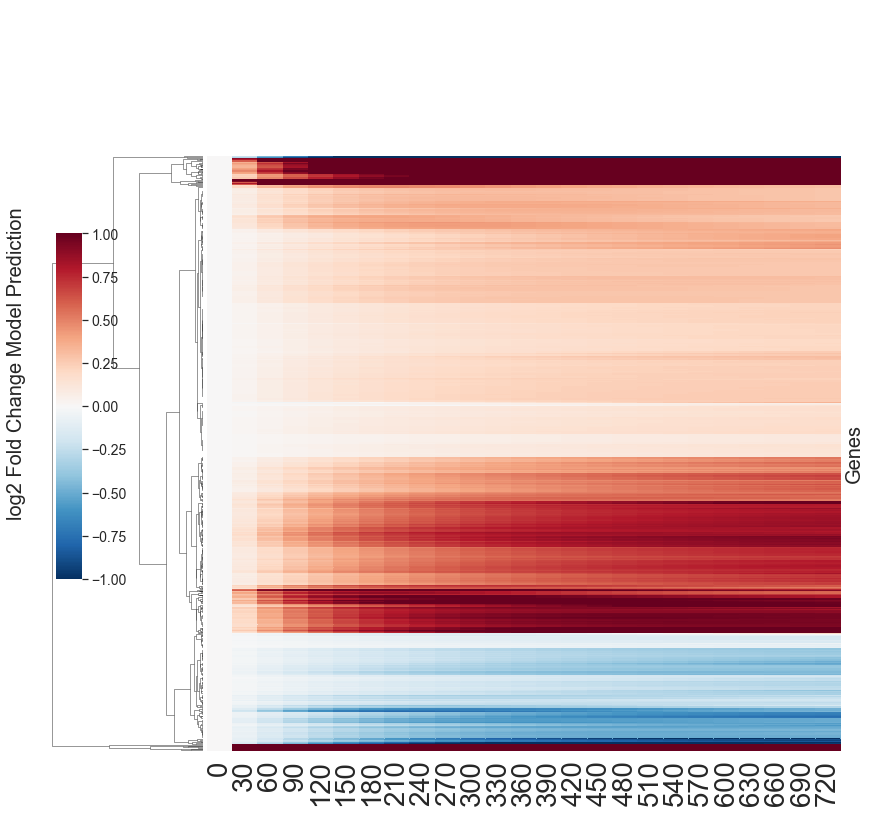

In [114]:
sns.set(font_scale=2.5)
sns.set_style("whitegrid", {'axes.grid' : False})
ax_plot = sns.clustermap(
    arr3_df, 
    cmap="RdBu_r", 
    xticklabels=True, 
    yticklabels=False, 
    vmin=-1, 
    vmax=1, 
    figsize= (12,12),
    cbar_pos=(0.05, .3, 0.03, .4),
    row_cluster = True,
    col_cluster = False
)

ax_plot.ax_heatmap.set_ylabel('Genes', fontproperties = chf, size = 20) 
plt.tick_params(labelsize = 14)
plt.text(-4, 0.25, 'log2 Fold Change Model Prediction', fontsize = 20, ha='center', va='center', rotation = 90)

plt.show()

## Figure 5

In [55]:
thre = 0.5
fdr = 0.05
tt = 10*4*60-1
a0_p = []
a0_f = []
a1_p = []
a1_f = []
a2_p = []
a2_f = []
a3_p = []
a3_f = []
a4_p = []
a4_f = []
a5_p = []
a5_f = []
a6_p = []
a6_f = []
a7_p = []
a7_f = []
a8_p = []
a8_f = []
a0_i = []
a1_i = []
a2_i = []
a3_i = []
a4_i = []
a5_i = []
a6_i = []
a7_i = []
a8_i = []
for k in with_data:
    gene = node_ID[k][5:]
    aa = np.log2(y240_MA[tt, k]/y240_MA[0, k])
    bb = np.log2(y4h_MA[k]/y0_MA[k])
    pp = RNA_raw.loc[gene, 'q_value.3']
    if bb >= 0 and pp <= fdr:
        if aa >= thre:
            a0_p.append(-np.log10(pp))
            a0_f.append(aa)
            a0_i.append(k)
        elif aa > -thre and aa < thre:
            a3_p.append(-np.log10(pp))
            a3_f.append(aa)
            a3_i.append(k)
        else:
            a6_p.append(-np.log10(pp))
            a6_f.append(aa)
            a6_i.append(k)
    elif bb < 0 and pp <= fdr:
        if aa >= thre:
            a2_p.append(np.log10(pp))
            a2_f.append(aa)
            a2_i.append(k)
        elif aa > -thre and aa < thre:
            a5_p.append(np.log10(pp))
            a5_f.append(aa)
            a5_i.append(k)
        else:
            a8_p.append(np.log10(pp))
            a8_f.append(aa)
            a8_i.append(k)
    else:
        if aa >= thre:
            if bb >= 0:
                a1_p.append(-np.log10(pp))
                a1_f.append(aa)
                a1_i.append(k)
            else:
                a1_p.append(np.log10(pp))
                a1_f.append(aa)
                a1_i.append(k)
        elif aa > -thre and aa < thre:
            if bb >= 0:
                a4_p.append(-np.log10(pp))
                a4_f.append(aa)
                a4_i.append(k)
            else:
                a4_p.append(np.log10(pp))
                a4_f.append(aa)
                a4_i.append(k)
        else:
            if bb >= 0:
                a7_p.append(-np.log10(pp))
                a7_f.append(aa)
                a7_i.append(k)
            else:
                a7_p.append(np.log10(pp))
                a7_f.append(aa)
                a7_i.append(k)

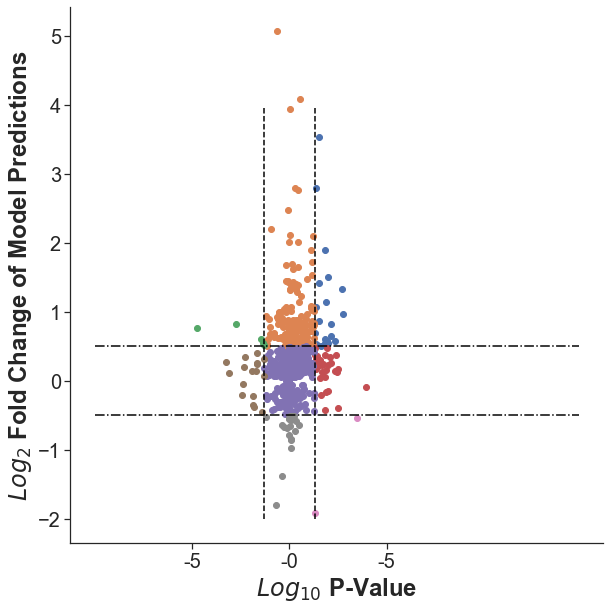

In [56]:
sns.set(font_scale=2)
sns.set_style("ticks", {'axes.grid' : False, 'font.sans-serif':'Arial'})
plt.figure(figsize=(9,9))
plt.scatter(a0_p, a0_f)
plt.scatter(a1_p, a1_f)
plt.scatter(a2_p, a2_f)
plt.scatter(a3_p, a3_f)
plt.scatter(a4_p, a4_f)
plt.scatter(a5_p, a5_f)
plt.scatter(a6_p, a6_f)
plt.scatter(a7_p, a7_f)
plt.scatter(a8_p, a8_f)

plt.plot(np.arange(-10,15,0.1), [thre]*len(np.arange(-10,15,0.1)), color = 'black', ls = '-.')
plt.plot(np.arange(-10,15,0.1), [-thre]*len(np.arange(-10,15,0.1)), color = 'black', ls = '-.')
plt.plot([np.log10(fdr)]*len(np.arange(-2,4,0.01)), np.arange(-2,4,0.01), color = 'black', ls = '--', label = 'P-value=0.05')
plt.plot([np.log10(1/fdr)]*len(np.arange(-2,4,0.01)), np.arange(-2,4,0.01), color = 'black', ls = '--')
plt.xticks(np.array([-5.,   0.,  5.]), ('-5', '-0', '-5'))
plt.xlabel(r'$Log_{10 }$'+' P-Value', weight = 'bold', fontsize = 24)
plt.ylabel(r'$Log_{2 }$'+' Fold Change of Model Predictions', weight = 'bold', fontsize = 24)
plt.tick_params(labelsize = 20)
sns.despine()
plt.tight_layout()
# plt.savefig('../figure/FinalFigures_v2/Fig6_ModelDataComparison.png', dpi = 300)
plt.show()

In [57]:
def get_stats(x):
    tp = x[0]+x[8]
    fp = x[1]+x[7]
    fn = x[3]+x[5]
    tn = x[4]
    fp_1 = x[2]+x[6]
    tpr = tp/(tp+fn+fp_1)
    ppv = tp/(tp+fp+fp_1)
    acc = (tp+tn)/np.sum(x)
    tnr = tn/(tn+fp)
    de_acc = tp/(tp+fp_1)
    return(tpr, ppv, acc, tnr, de_acc)

In [58]:
alpha = 0.05
contingency_table_stringent = []
for j in np.arange(0,5,0.01):
    mm = j
    c_1 = 0
    c_2 = 0
    c_3 = 0
    c_4 = 0
    c_5 = 0
    c_6 = 0
    c_7 = 0
    c_8 = 0
    c_9 = 0
    for i in with_data:
        gene = node_ID[i][5:]
        if RNA_raw.loc[gene, 'q_value.3']>alpha or abs(RNA_raw.loc[gene, 'log2FC.3']) < 0.5:
            if np.log2(y240_MA[tt,i]/np.array(y0_MA)[i])>=mm:
                c_2 += 1
            elif np.log2(y240_MA[tt,i]/np.array(y0_MA)[i])<=-mm:
                c_8 += 1
            else:
                c_5 += 1
        else:
            if RNA_raw.loc[gene, 'log2FC.3']>=0 and np.log2(y240_MA[tt,i]/np.array(y0_MA)[i])>=mm:
                c_1 += 1
            elif RNA_raw.loc[gene, 'log2FC.3']<=0 and np.log2(y240_MA[tt,i]/np.array(y0_MA)[i])>=mm:
                c_3 += 1
            elif RNA_raw.loc[gene, 'log2FC.3']>=0 and np.log2(y240_MA[tt,i]/np.array(y0_MA)[i])<=-mm:
                c_7 += 1
            elif RNA_raw.loc[gene, 'log2FC.3']<=0 and np.log2(y240_MA[tt,i]/np.array(y0_MA)[i])<=-mm:
                c_9 += 1
            elif RNA_raw.loc[gene, 'log2FC.3']>=0 and abs(np.log2(y240_MA[tt,i]/np.array(y0_MA)[i]))<mm:
                c_4 += 1
            else:
                c_6 += 1
    contingency_table_stringent.append([c_1, c_2, c_3, c_4, c_5, c_6, c_7, c_8, c_9])

In [67]:
get_stats(contingency_table_stringent[25])

(0.509090909090909,
 0.06422018348623854,
 0.45077720207253885,
 0.44630404463040446,
 0.717948717948718)

In [68]:
contingency_table_stringent[25]

[26, 327, 8, 9, 320, 7, 3, 70, 2]

In [71]:
DE_long_4h_inmodel = RNA_raw[
    (RNA_raw['q_value.3'] <= 0.05) & \
    (abs(RNA_raw['log2FC.3']) >= 0.5) & \
    (RNA_raw['Row.names'].isin(genes))
]['Row.names'].tolist()

In [72]:
with open('/home/shulincao/Desktop/projects/lab/myocyte/codes/genelist293.txt', 'r') as f:
    gene_sub = f.read().splitlines() 
gene_sub_index = [node_ID.index('gene_'+i) for i in gene_sub]

In [73]:
commonsubgenes = list(commongeneset.intersection(gene_sub))
commonsubgenes_index = [node_ID.index('gene_'+i) for i in commonsubgenes]

In [74]:
alpha = 0.05
contingency_table_sub = []
for i in np.arange(0,0.99,0.01):
    mm = i
    c_1 = 0
    c_2 = 0
    c_3 = 0
    c_4 = 0
    c_5 = 0
    c_6 = 0
    c_7 = 0
    c_8 = 0
    c_9 = 0
    for i in commonsubgenes_index:
        gene = node_ID[i][5:]
        if RNA_raw.loc[gene, 'q_value.3']>alpha or abs(RNA_raw.loc[gene, 'log2FC.3']) < 0.5:
            if np.log2(y240_MA[tt,i]/np.array(y0_MA)[i])>=mm:
                c_2 += 1
            elif np.log2(y240_MA[tt,i]/np.array(y0_MA)[i])<=-mm:
                c_8 += 1
            else:
                c_5 += 1
        else:
            if RNA_raw.loc[gene, 'q_value.3']>=0 and np.log2(y240_MA[tt,i]/np.array(y0_MA)[i])>=mm:
                c_1 += 1
            elif RNA_raw.loc[gene, 'q_value.3']<=0 and np.log2(y240_MA[tt,i]/np.array(y0_MA)[i])>=mm:
                c_3 += 1
            elif RNA_raw.loc[gene, 'q_value.3']>=0 and np.log2(y240_MA[tt,i]/np.array(y0_MA)[i])<=-mm:
                c_7 += 1
            elif RNA_raw.loc[gene, 'q_value.3']<=0 and np.log2(y240_MA[tt,i]/np.array(y0_MA)[i])<=-mm:
                c_9 += 1
            elif RNA_raw.loc[gene, 'q_value.3']>=0 and abs(np.log2(y240_MA[tt,i]/np.array(y0_MA)[i]))<mm:
                c_4 += 1
            else:
                c_6 += 1
    contingency_table_sub.append([c_1, c_2, c_3, c_4, c_5, c_6, c_7, c_8, c_9])

In [75]:
contingency_table_sub[25]

[13, 94, 0, 8, 158, 0, 0, 15, 0]

In [76]:
get_stats(contingency_table_sub[25])

(0.6190476190476191, 0.10655737704918032, 0.59375, 0.5917602996254682, 1.0)

### Alternate that used log2fc threshold rather than the stats

In [94]:
data_threshold = 0.5
contingency_numerical = []
for i in np.arange(0,5,0.01):
    mm = i
    c_1 = 0
    c_2 = 0
    c_3 = 0
    c_4 = 0
    c_5 = 0
    c_6 = 0
    c_7 = 0
    c_8 = 0
    c_9 = 0
    for i in with_data:
        gene = node_ID[i][5:]
        if abs(RNA_raw.loc[gene, 'log2FC.3']) < data_threshold:
            if np.log2(y240_MA[tt,i]/np.array(y0_MA)[i])>=mm:
                c_2 += 1
            elif np.log2(y240_MA[tt,i]/np.array(y0_MA)[i])<=-mm:
                c_8 += 1
            else:
                c_5 += 1
        else:
            if RNA_raw.loc[gene, 'log2FC.3'] >= data_threshold and np.log2(y240_MA[tt,i]/np.array(y0_MA)[i])>=mm:
                c_1 += 1
            elif RNA_raw.loc[gene, 'log2FC.3'] <= -data_threshold and np.log2(y240_MA[tt,i]/np.array(y0_MA)[i])>=mm:
                c_3 += 1
            elif RNA_raw.loc[gene, 'log2FC.3'] >= data_threshold and np.log2(y240_MA[tt,i]/np.array(y0_MA)[i])<=-mm:
                c_7 += 1
            elif RNA_raw.loc[gene, 'log2FC.3'] <= -data_threshold and np.log2(y240_MA[tt,i]/np.array(y0_MA)[i])<=-mm:
                c_9 += 1
            elif RNA_raw.loc[gene, 'log2FC.3'] >= data_threshold and abs(np.log2(y240_MA[tt,i]/np.array(y0_MA)[i]))<mm:
                c_4 += 1
            else:
                c_6 += 1
    contingency_numerical.append([c_1, c_2, c_3, c_4, c_5, c_6, c_7, c_8, c_9])

In [121]:
tpr = []
fpr = []
for i in contingency_table:
    tp = i[0]+i[8]+i[2]+i[6]
    fp = i[1]+i[7]
    fn = i[3]+i[5]
    tn = i[4]
    tpr.append(tp/(tp+fn))
    fpr.append(fp/(fp+tn))
tpr_stringent = []
fpr_stringent = []
for i in contingency_table_stringent:
    tp = i[0]+i[8]+i[2]+i[6]
    fp = i[1]+i[7]
    fn = i[3]+i[5]
    tn = i[4]
    tpr_stringent.append(tp/(tp+fn))
    fpr_stringent.append(fp/(fp+tn))
tpr_numerical = []
fpr_numerical = []
for i in contingency_numerical:
    tp = i[0]+i[8]+i[2]+i[6]
    fp = i[1]+i[7]
    fn = i[3]+i[5]
    tn = i[4]
    tpr_numerical.append(tp/(tp+fn))
    fpr_numerical.append(fp/(fp+tn))

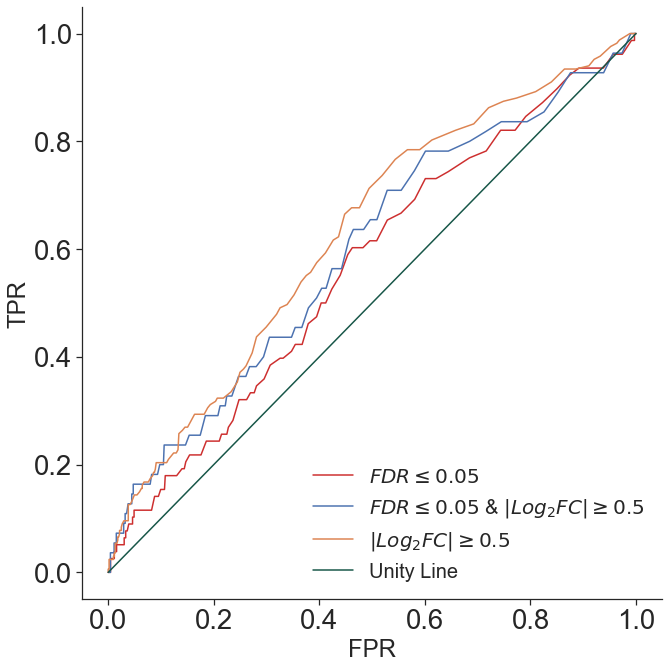

In [122]:
sns.set(font_scale=2.5)
sns.set_style("ticks", {'axes.grid' : False, 'font.sans-serif':'Arial'})
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, label = r'$FDR\leq0.05$', color = (205/255,47/255,47/255))
plt.plot(fpr_stringent, tpr_stringent, label = r'$FDR\leq0.05$ & $|Log_{2}FC|\geq0.5$')
plt.plot(fpr_numerical, tpr_numerical, label = r'$|Log_{2}FC|\geq0.5$')

#plt.plot(fpr_all, tpr_all, label = 'on All Genes')
plt.plot(np.arange(0,1.01,0.01),np.arange(0,1.01,0.01), label = 'Unity Line', color = (23/255,86/255,72/255))
plt.legend(loc='best', frameon=False, fontsize=20)
plt.xlabel('FPR', fontsize=24)
plt.ylabel('TPR', fontsize=24)
sns.despine()
plt.tight_layout()
# plt.savefig('../figure/FinalFigures/FigS4_ROC.png', dpi = 300)
plt.show()

In [63]:
a_tac = [43, 209, 3, 31, 421, 2, 2, 28, 1]
a_cyc = [15, 13, 0, 52, 616, 0, 1, 0, 0]
a_myo = [16, 182, 4, 20, 514, 13, 2, 21, 0]

In [64]:
a_agg = np.array(a_tac) + np.array(a_cyc) + np.array(a_myo)

In [66]:
get_stats(a_agg)

(0.36585365853658536,
 0.1388888888888889,
 0.7360796740606609,
 0.7739520958083832,
 0.8620689655172413)

In [69]:
a_tac_half = [49, 256, 3, 23, 299, 2, 4, 103, 1]
a_cyc_half = [31, 58, 0, 36, 567, 0, 1, 4, 0]
a_myo_half = [26, 327, 8, 9, 320, 7, 3, 70, 2]
a_agg_half = np.array(a_tac_half) + np.array(a_cyc_half) + np.array(a_myo_half)
get_stats(a_agg_half)

(0.5317073170731708,
 0.11522198731501057,
 0.5862381167949299,
 0.591816367265469,
 0.8515625)

### For defense only

['FoxO',
 'MEF2',
 'cFos',
 'cMyc',
 'GATA4',
 'NFkB',
 'NFAT',
 'SRF',
 'STAT',
 'CREB',
 'cJun']

## Enrichment of Model Genes

In [2]:
kegg_model = pd.read_table('../data/TestData/modelgenes_KEGG.txt', sep = '\t')
kegg_model_term = kegg_model['Term'].tolist()
kegg_model_term = [i.split(':')[1] for i in kegg_model_term]
kegg_model['Process'] = kegg_model_term
kegg_model_FDR = kegg_model['FDR'].tolist()
kegg_model_FDR = [np.log10(i) for i in kegg_model_FDR]
kegg_model['log10FDR'] = kegg_model_FDR

In [3]:
kegg_model.index = kegg_model['Process'].tolist()

In [4]:
modelpathways = kegg_model['Process'].tolist()

In [80]:
datapathways = kegg_DE_4_L['Process'].tolist()

In [81]:
total_same_pathways = list(set(modelpathways).intersection(set(datapathways)))

In [82]:
len(datapathways)

49

In [83]:
enrichment_dict = {
    'ModelEnrichment': set(modelpathways),
    'DataEnrichment': set(datapathways)
}

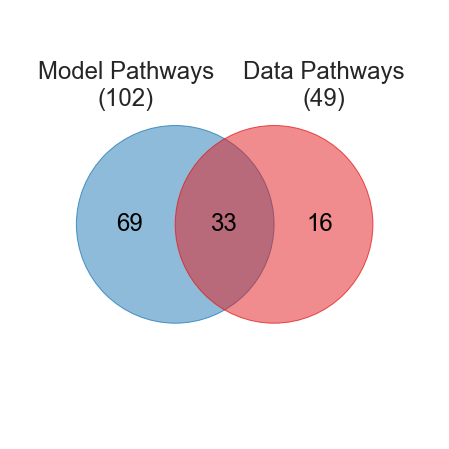

In [96]:
sns.set(font_scale=2.5)
sns.set_style("ticks", {'axes.grid' : False, 'font.sans-serif':'Arial'})
venn(
    enrichment_dict,
    cmap=a1, 
    fontsize=24, 
    legend_loc=None,
    figsize = (8, 8),
    alpha = 0.5
)
sns.despine()
plt.text(0.25, 0.85, 'Model Pathways\n({})'.format(len(modelpathways)), fontsize = 24, ha='center', va='center')
plt.text(0.75, 0.85, 'Data Pathways\n({})'.format(len(datapathways)), fontsize = 24, ha='center', va='center')
# plt.savefig('../figure/FinalFigures_v2/FigS_model_datapathways.png', dpi = 300)
plt.show()

In [84]:
common_results = pd.DataFrame(columns = ['Pathways', 'ModelOnly', 'Both', 'DataOnly'])
for i in total_same_pathways:
    gene_model = kegg_model.loc[i, 'Genes'].split(', ')
    gene_data = kegg_DE_4_L.loc[i, 'Genes'].split(', ')
    a1 = len(set(gene_model).difference(gene_data)) 
    a2 = len(set(gene_model).intersection(gene_data))
    a3 = len(set(gene_data).difference(gene_model))
    common_results.loc[len(common_results)] = [
        i, 
        a1,
        a1+a2,
        a1+a2+a3
    ]

In [85]:
common_results = common_results.sort_values(by=['DataOnly'], ascending=False)

In [86]:
common_results_index = common_results['Pathways'].tolist()

In [87]:
common_results.index = common_results_index

In [88]:
pal_blue = sns.color_palette("Blues_r", common_results.shape[0]*2)[:common_results.shape[0]]
pal_red = sns.color_palette("Reds_r", common_results.shape[0]*2)[:common_results.shape[0]]

In [89]:
common_pvalues_model = kegg_model.loc[common_results_index, 'PValue'].tolist()
common_pvalues_data = kegg_DE_4_L.loc[common_results_index, 'PValue'].tolist()
p_rank_model = [int(i)-1 for i in stats.rankdata(common_pvalues_model)]
p_rank_data = [int(i)-1 for i in stats.rankdata(common_pvalues_data)]

In [90]:
recons_pal_blue = [pal_blue[i] for i in p_rank_model]
recons_pal_red = [pal_red[i] for i in p_rank_data]

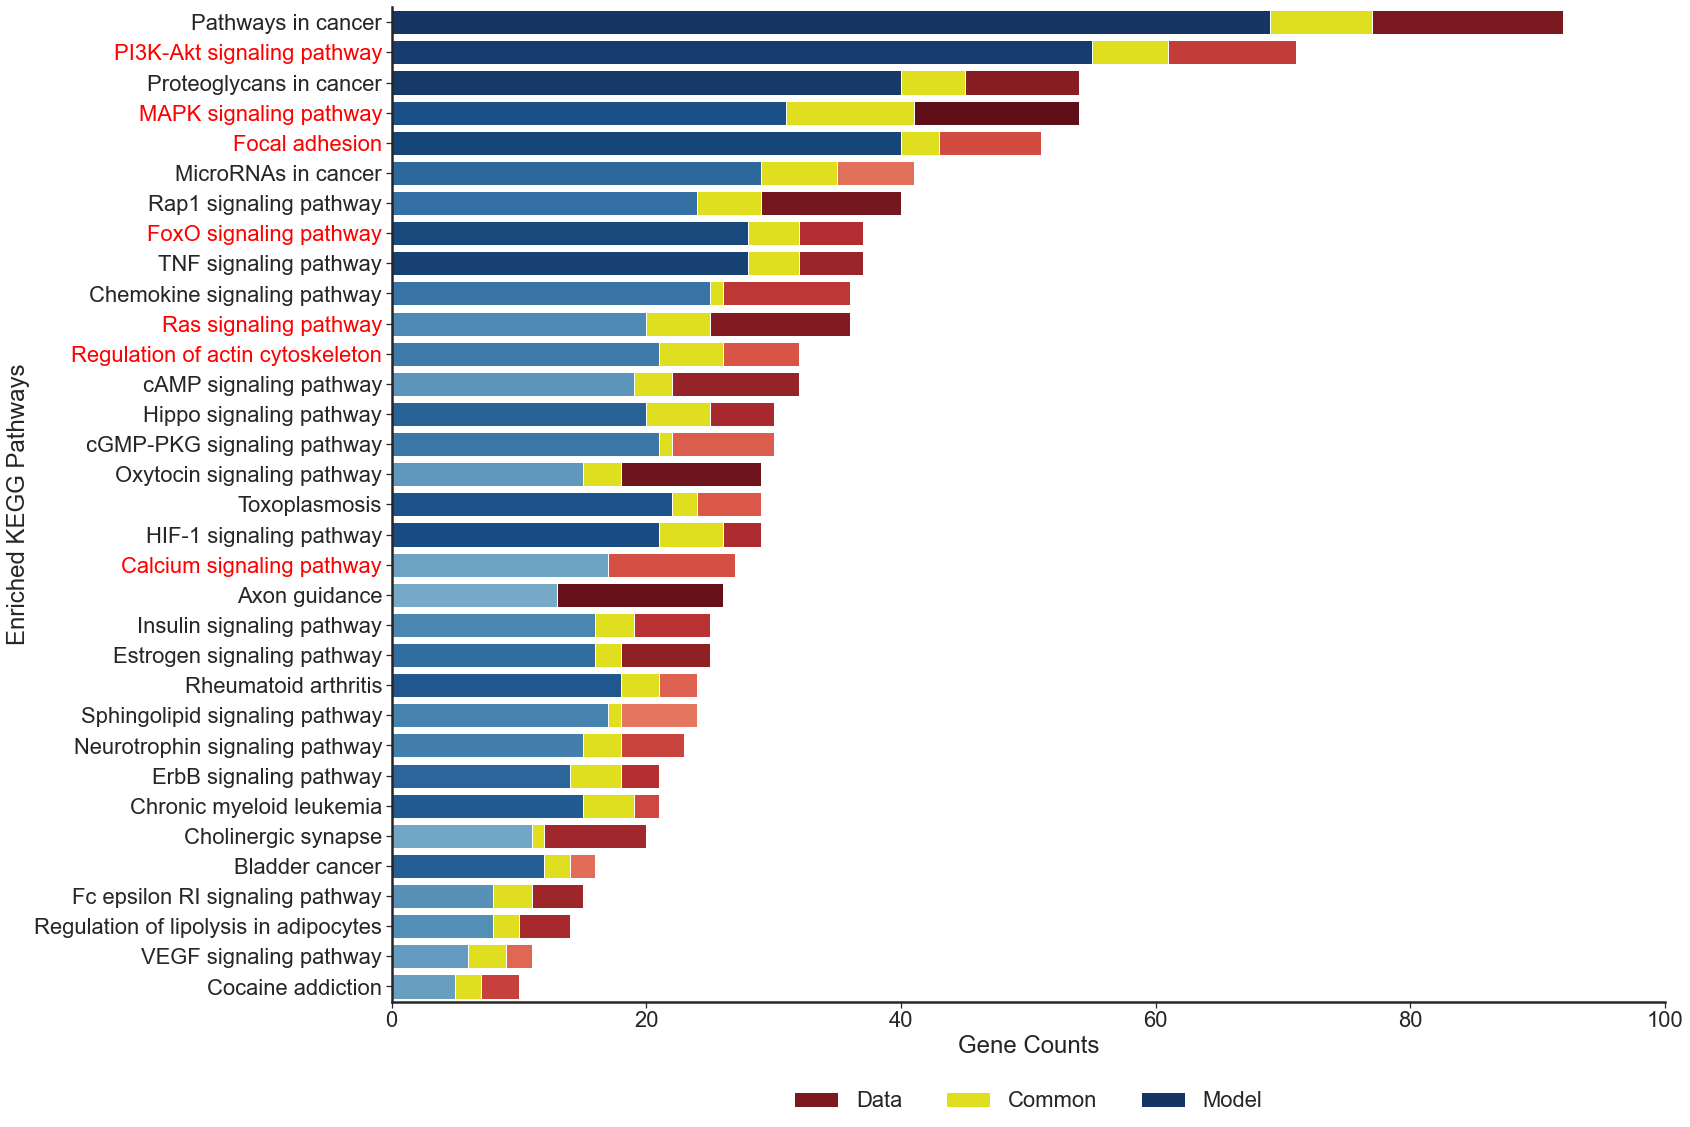

In [197]:
sns.set(font_scale=2)
sns.set_context(rc={"lines.linewidth": 5})
sns.set_style("ticks", {'axes.grid' : False, 'font.sans-serif':'Arial'})
plt.figure(figsize = (24,16))
ax = sns.barplot(
    x="DataOnly", 
    y="Pathways", 
    palette = recons_pal_red,
    data = common_results, 
    orient='h',
    label = 'Data'
)
ax = sns.barplot(
    x="Both", 
    y="Pathways", 
    color="yellow", 
    data = common_results, 
    orient='h',
    label = 'Common'
)
ax = sns.barplot(
    x="ModelOnly", 
    y="Pathways", 
    palette = recons_pal_blue,
    data = common_results, 
    orient='h',
    label = 'Model'
)

plt.xticks(np.array([0, 20, 40, 60, 80, 100]), ('0', '20', '40', '60', '80', '100'))
ax.get_yticklabels()[common_results_index.index('MAPK signaling pathway')].set_color("red")
ax.get_yticklabels()[common_results_index.index('FoxO signaling pathway')].set_color("red")
ax.get_yticklabels()[common_results_index.index('Ras signaling pathway')].set_color("red")
ax.get_yticklabels()[common_results_index.index('PI3K-Akt signaling pathway')].set_color("red")
ax.get_yticklabels()[common_results_index.index('Focal adhesion')].set_color("red")
ax.get_yticklabels()[common_results_index.index('Calcium signaling pathway')].set_color("red")
ax.get_yticklabels()[common_results_index.index('Regulation of actin cytoskeleton')].set_color("red")
plt.xlabel('Gene Counts')
plt.ylabel('Enriched KEGG Pathways')
sns.despine()
ax.spines['bottom'].set_linewidth(2.5)
ax.spines['left'].set_linewidth(2.5)
plt.legend(loc='center', bbox_to_anchor = (0.5, -0.1), ncol = 3, frameon = False)
plt.tight_layout()
# plt.savefig('../figure/FinalFigures_v2/FigS_KEGG_gene_comparison.png', dpi=600)
plt.show()

In [91]:
altered_path = pd.DataFrame(columns = ['Pathways', 'ModelOnly', 'Both', 'DataOnly'])

In [92]:
for i in toshow:
    if i in common_results_index:
        altered_path.loc[len(altered_path)] = common_results.loc[i, :].values.tolist()
    else:
        altered_path.loc[len(altered_path)] = [i, 0, 0, len(kegg_DE_4_L.loc[i, 'Genes'].split(', '))]

In [93]:
pal_blue_alt = sns.color_palette("Blues_r", altered_path.shape[0]*2)[:altered_path.shape[0]]
pal_red_alt = sns.color_palette("Reds_r", altered_path.shape[0]*2)[:altered_path.shape[0]]
common_pvalues_model_alt = [kegg_model.loc[i, 'PValue'] if i in common_results_index else 1 for i in toshow]
common_pvalues_data_alt = [kegg_DE_4_L.loc[i, 'PValue'] for i in toshow]
p_rank_model_alt = [int(i)-1 for i in stats.rankdata(common_pvalues_model_alt)]
p_rank_data_alt = [int(i)-1 for i in stats.rankdata(common_pvalues_data_alt)]

In [94]:
recons_pal_blue_alt = [pal_blue_alt[i] for i in p_rank_model_alt]
recons_pal_red_alt = [pal_red_alt[i] for i in p_rank_data_alt]

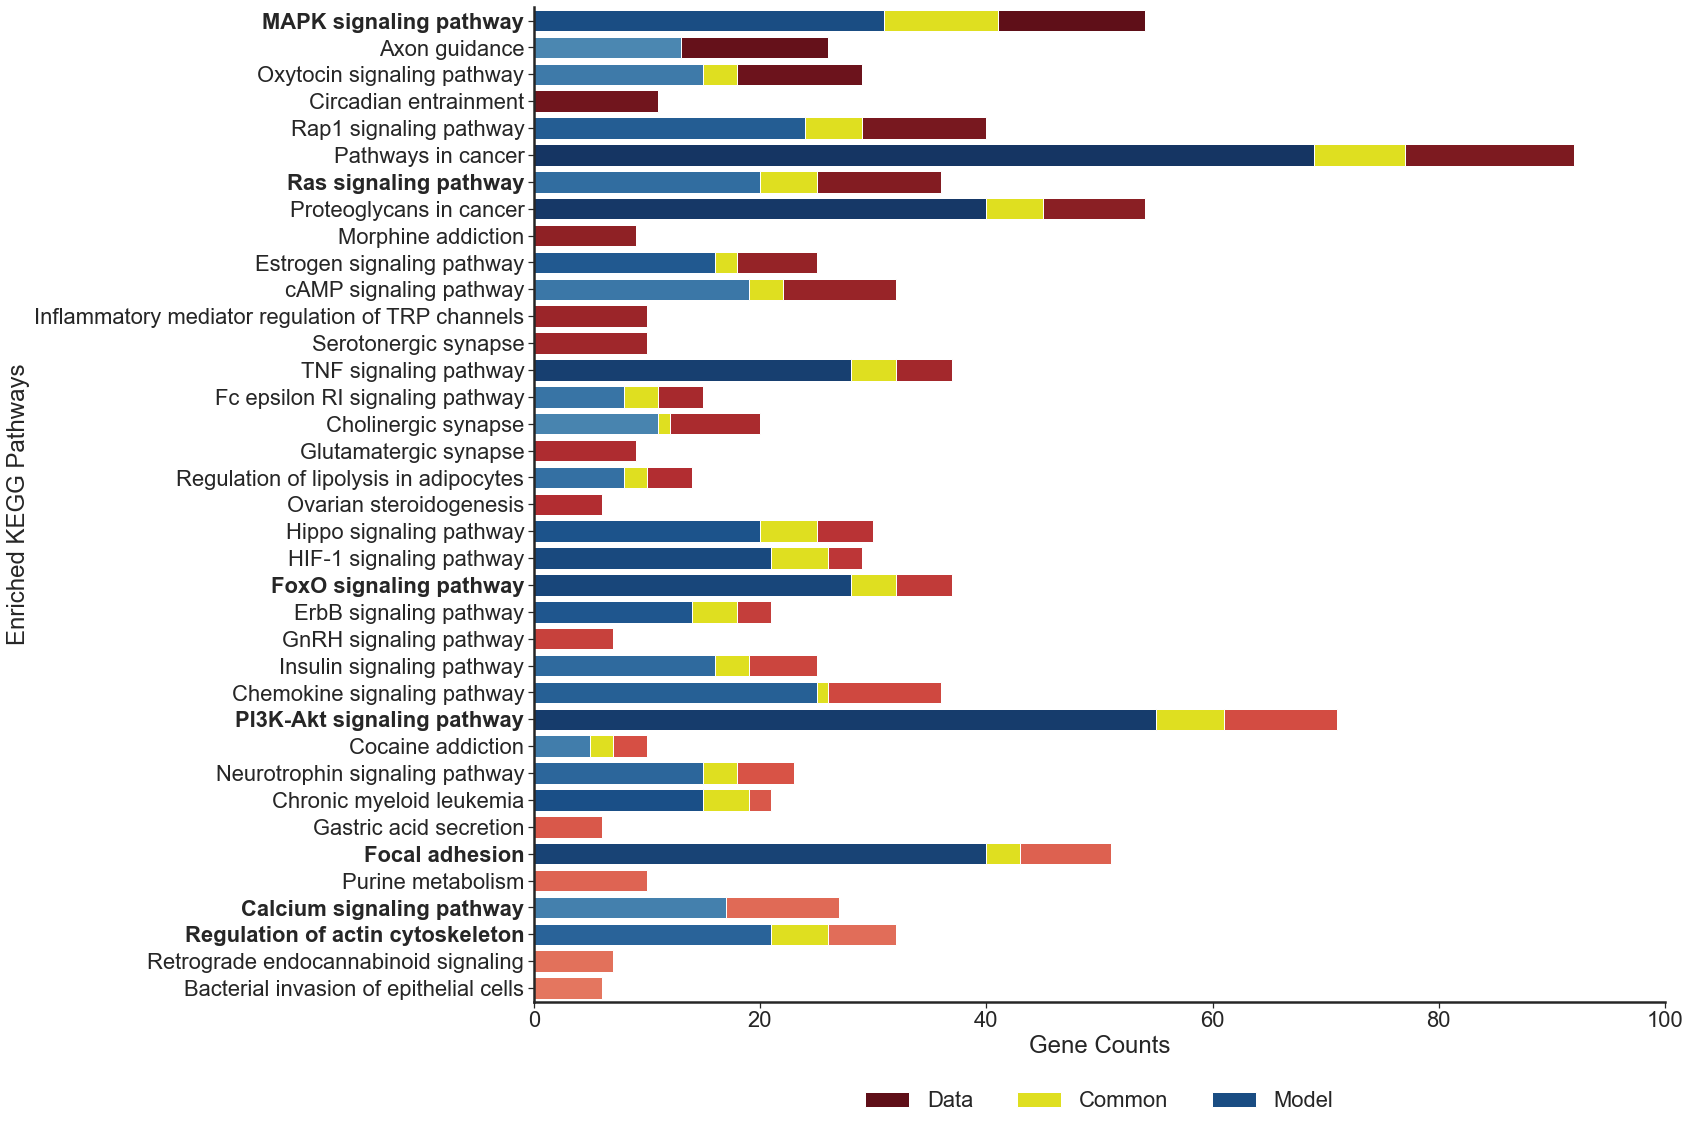

In [80]:
sns.set(font_scale=2)
sns.set_context(rc={"lines.linewidth": 5})
sns.set_style("ticks", {'axes.grid' : False, 'font.sans-serif':'Arial'})
plt.figure(figsize = (24,16))
ax = sns.barplot(
    x="DataOnly", 
    y="Pathways", 
    palette = recons_pal_red_alt,
    data = altered_path, 
    orient='h',
    label = 'Data'
)
ax = sns.barplot(
    x="Both", 
    y="Pathways", 
    color="yellow", 
    data = altered_path, 
    orient='h',
    label = 'Common'
)
ax = sns.barplot(
    x="ModelOnly", 
    y="Pathways", 
    palette = recons_pal_blue_alt,
    data = altered_path, 
    orient='h',
    label = 'Model'
)

plt.xticks(np.array([0, 20, 40, 60, 80, 100]), ('0', '20', '40', '60', '80', '100'))
ax.get_yticklabels()[toshow.index('MAPK signaling pathway')].set_fontweight('bold')
ax.get_yticklabels()[toshow.index('FoxO signaling pathway')].set_fontweight('bold')
ax.get_yticklabels()[toshow.index('Ras signaling pathway')].set_fontweight('bold')
ax.get_yticklabels()[toshow.index('PI3K-Akt signaling pathway')].set_fontweight('bold')
ax.get_yticklabels()[toshow.index('Focal adhesion')].set_fontweight('bold')
ax.get_yticklabels()[toshow.index('Calcium signaling pathway')].set_fontweight('bold')
ax.get_yticklabels()[toshow.index('Regulation of actin cytoskeleton')].set_fontweight('bold')
plt.xlabel('Gene Counts')
plt.ylabel('Enriched KEGG Pathways')
sns.despine()
ax.spines['bottom'].set_linewidth(2.5)
ax.spines['left'].set_linewidth(2.5)
plt.legend(loc='center', bbox_to_anchor = (0.5, -0.1), ncol = 3, frameon = False)
plt.tight_layout()
# plt.savefig('../figure/FinalFigures_v2/FigS_KEGG_gene_comparison_v2.png', dpi=600)
plt.show()

In [97]:
altered_path.head(10)

,Pathways,ModelOnly,Both,DataOnly
0,MAPK signaling pathway,31,41,54
1,Axon guidance,13,13,26
2,Oxytocin signaling pathway,15,18,29
3,Circadian entrainment,0,0,11
4,Rap1 signaling pathway,24,29,40
5,Pathways in cancer,69,77,92
6,Ras signaling pathway,20,25,36
7,Proteoglycans in cancer,40,45,54
8,Morphine addiction,0,0,9
9,Estrogen signaling pathway,16,18,25


In [98]:
toshow_results.head(10)

,Pathways,30m,Intersection,Union
MAPK signaling pathway,MAPK signaling pathway,2,5,25
Axon guidance,Axon guidance,0,0,13
Oxytocin signaling pathway,Oxytocin signaling pathway,1,3,15
Circadian entrainment,Circadian entrainment,0,0,11
Rap1 signaling pathway,Rap1 signaling pathway,0,0,16
Pathways in cancer,Pathways in cancer,0,0,23
Ras signaling pathway,Ras signaling pathway,0,0,16
Proteoglycans in cancer,Proteoglycans in cancer,0,0,14
Morphine addiction,Morphine addiction,0,0,9
Estrogen signaling pathway,Estrogen signaling pathway,0,0,9


In [92]:
kegg_model.loc['Calcium signaling pathway', :]

Category                                                KEGG_PATHWAY
Term                              mmu04020:Calcium signaling pathway
Count                                                             17
%                                                            2.21643
PValue                                                     0.0708252
Genes              NOS3, TNNC1, PTAFR, ATP2B4, ATP2A2, ATP2B1, EG...
List Total                                                       460
Pop Hits                                                         180
Pop Total                                                       7691
Fold Enrichment                                              1.57907
Bonferroni                                                         1
Benjamini                                                   0.180282
FDR                                                         0.125911
Process                                    Calcium signaling pathway
log10FDR                          

In [93]:
kegg_model[kegg_model['PValue'] <= 0.05].shape

(94, 15)

### the following figure is for defense only

In [78]:
defen_model = pd.DataFrame(columns = ['Pathways', 'Model', 'PValue'])
for i in kegg_model.index:
    gene_model = kegg_model.loc[i, 'Genes'].split(', ')
    defen_model.loc[len(defen_model)] = [
        i, 
        len(set(gene_model)),
        kegg_model.loc[i, 'PValue']
    ]
defen_model.index = kegg_model.index

In [85]:
toexclude = [
    'Hepatitis B',
    'Chagas disease (American trypanosomiasis)',
    'Toxoplasmosis',
    'Rheumatoid arthritis',
    'Viral carcinogenesis',
    'Measles',
    'Chronic myeloid leukemia',
    'Acute myeloid leukemia',
    'Amoebiasis',
    'Malaria',
    'Influenza A',
    'Renal cell carcinoma',
    'Melanoma',
    'Leishmaniasis',
    'Hepatitis C',
    'Pertussis',
    'Glioma',
    'Leukocyte transendothelial migration',
    'Legionellosis',
    'Platelet activation',
    'Tuberculosis',
    'Inflammatory bowel disease (IBD)',
    'Arginine and proline metabolism',
    'Aldosterone-regulated sodium reabsorption',
    'Amyotrophic lateral sclerosis (ALS)',
    'Progesterone-mediated oocyte maturation',
    'Prion diseases',
    'Antigen processing and presentation',
    'Fc gamma R-mediated phagocytosis',
    'Cocaine addiction',
    'Cholinergic synapse',
    'Protein digestion and absorption',
    'Axon guidance'
]

In [89]:
subsetpaths = []
excludepaths = []
for i in kegg_model.index:
    cc = i.lower()
    if 'cancer' not in cc and 'infection' not in cc and i not in toexclude:
        subsetpaths.append(i)
    else:
        excludepaths.append(i)

In [98]:
submodelgenes = kegg_model.loc[subsetpaths, 'Genes'].tolist()
# submodelgenes = kegg_model['Genes'].tolist()

In [99]:
submodelgene_set = set()
for i in submodelgenes:
    cc = i.split(',')
    for k in cc:
        submodelgene_set.add(k)

In [100]:
len(submodelgene_set)

301

In [104]:
defen_model.loc[subsetpaths, :]

,Pathways,Model,PValue
PI3K-Akt signaling pathway,PI3K-Akt signaling pathway,61,3.846092e-14
TNF signaling pathway,TNF signaling pathway,32,8.459317e-14
Focal adhesion,Focal adhesion,43,1.055861e-12
FoxO signaling pathway,FoxO signaling pathway,32,3.297405e-11
HIF-1 signaling pathway,HIF-1 signaling pathway,26,7.586736e-10
NF-kappa B signaling pathway,NF-kappa B signaling pathway,24,7.320809e-09
MAPK signaling pathway,MAPK signaling pathway,41,7.675727e-09
Osteoclast differentiation,Osteoclast differentiation,26,7.505370e-08
Toll-like receptor signaling pathway,Toll-like receptor signaling pathway,23,8.095723e-08
Cell cycle,Cell cycle,25,2.241492e-07


In [114]:
verified_paths = [
    'PI3K-Akt signaling pathway',
    'Focal adhesion',
    'FoxO signaling pathway',
    'NF-kappa B signaling pathway',
    'MAPK signaling pathway',
    'cGMP-PKG signaling pathway',
    'Regulation of actin cytoskeleton',
    'Jak-STAT signaling pathway',
    'Ras signaling pathway',
    'Calcium signaling pathway'
]

In [115]:
pal_blue_def_model = sns.color_palette("Blues_r", len(subsetpaths)*2)[:len(subsetpaths)]

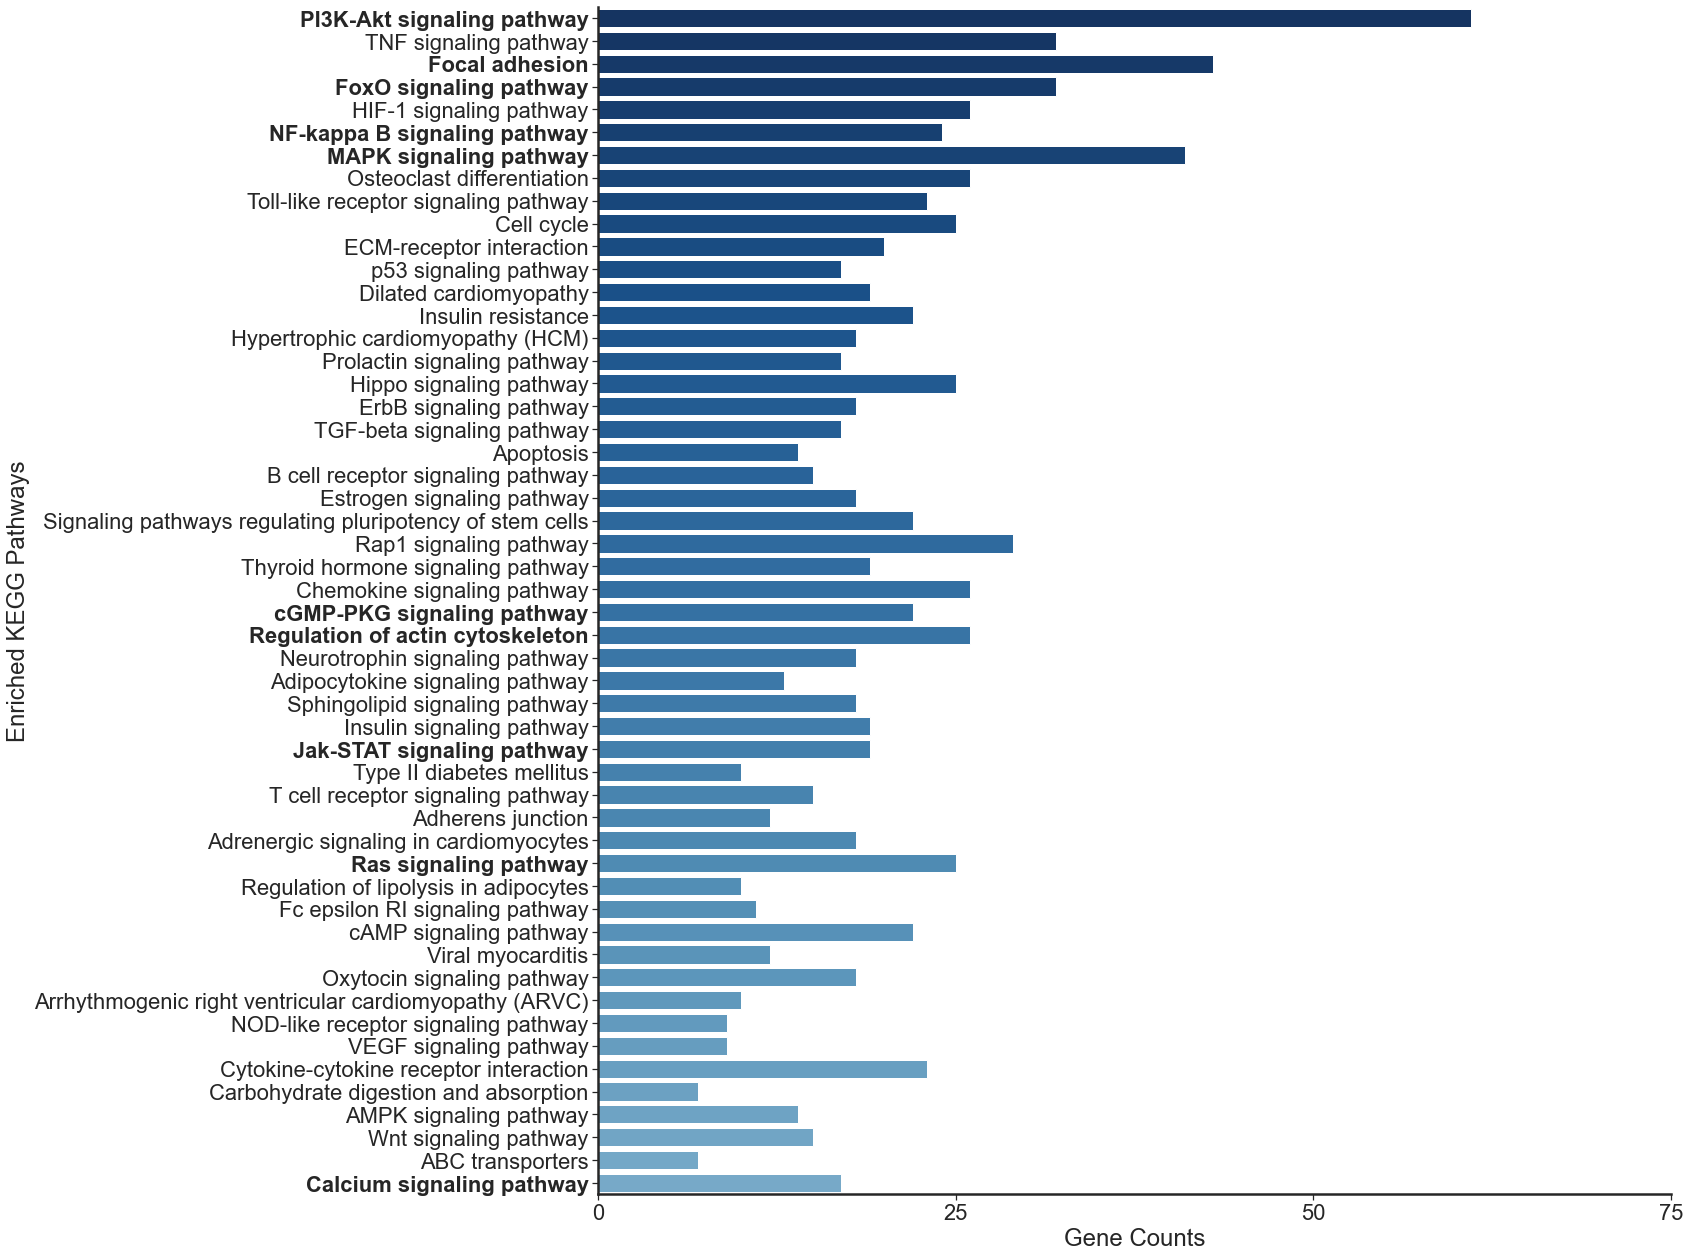

In [164]:
sns.set(font_scale=2)
sns.set_context(rc={"lines.linewidth": 5})
sns.set_style("ticks", {'axes.grid' : False, 'font.sans-serif':'Arial'})
plt.figure(figsize = (24,18))
ax = sns.barplot(
    x="Model", 
    y="Pathways", 
    palette = pal_blue_def_model,
    data = defen_model.loc[subsetpaths, :], 
    orient='h'
)
plt.xticks(np.array([0, 25, 50, 75]), ('0', '25', '50', '75'))
for i in verified_paths:
    ax.get_yticklabels()[subsetpaths.index(i)].set_fontweight('bold')

plt.xlabel('Gene Counts')
plt.ylabel('Enriched KEGG Pathways')
sns.despine()
ax.spines['bottom'].set_linewidth(2.5)
ax.spines['left'].set_linewidth(2.5)
plt.tight_layout()
# plt.savefig('../figure/FinalFigures_v2/FigS_KEGG_model_verionly_v3.png', dpi=300)
plt.show()

## Figure 6
### Fig 6A: Trans vs Long at 4h

In [45]:
model_DE_4h = list(set(DE_4h).intersection(genes))
model_DE_30m = list(set(DE_30m).intersection(genes))
model_DE_4h_index = [node_ID.index('gene_'+i) for i in model_DE_4h]
model_DE_30m_index = [node_ID.index('gene_'+i) for i in model_DE_30m]

In [46]:
model_unDE_4h_index = list(set(with_data).difference(model_DE_4h_index))
model_unDE_30m_index = list(set(with_data).difference(model_DE_30m_index))

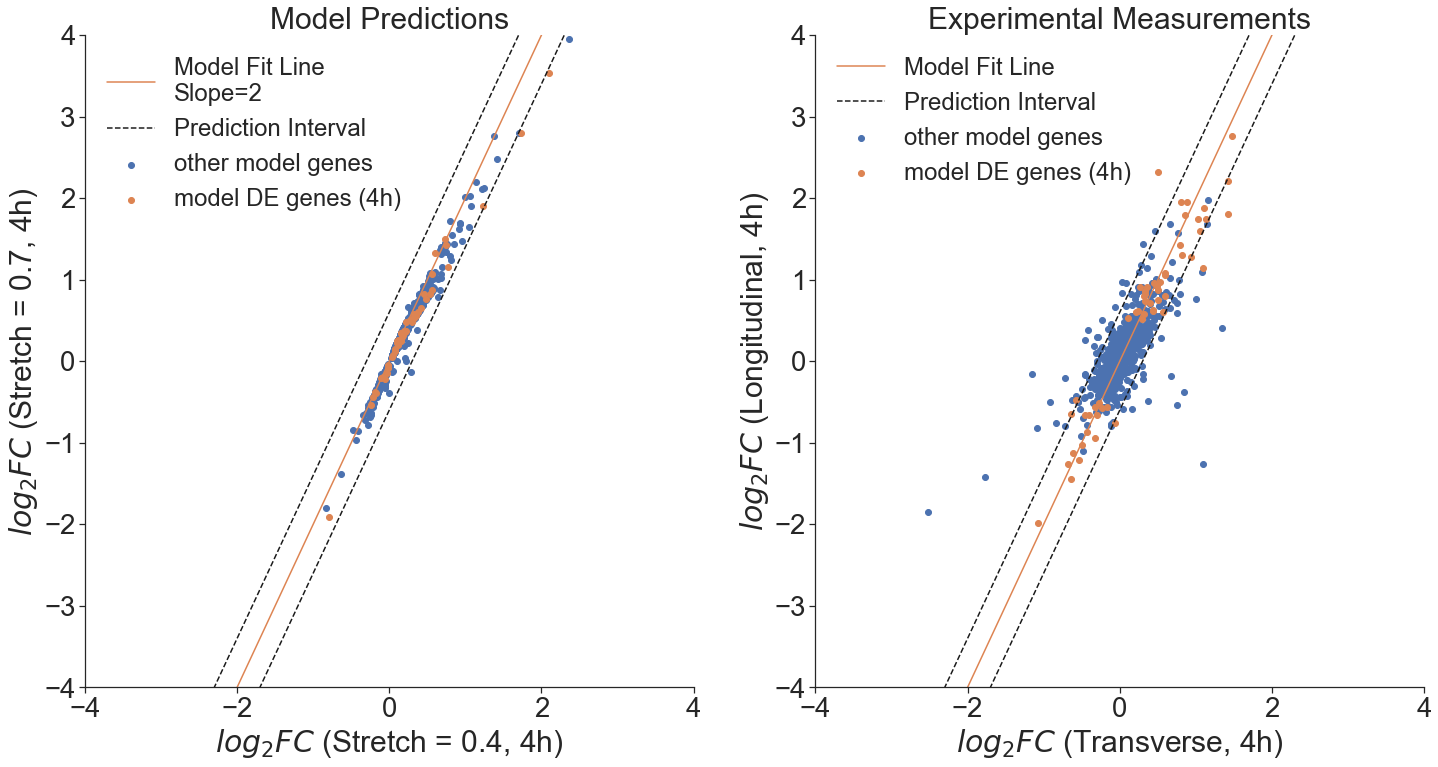

In [51]:
sns.set(font_scale=2.5)
sns.set_style("ticks", {'axes.grid' : False, 'font.sans-serif':'Arial'})
plt.figure(figsize=(24,12))
plt.subplot(1,2,1)

plt.scatter(
    np.log2(y240_MA_lo[2399, model_unDE_4h_index])-np.log2(y240_MA_lo[0, model_unDE_4h_index]),
    np.log2(y240_MA[2399, model_unDE_4h_index])-np.log2(y240_MA[0, model_unDE_4h_index]),
    label = 'other model genes'
)
plt.scatter(
    np.log2(y240_MA_lo[2399, model_DE_4h_index])-np.log2(y240_MA_lo[0, model_DE_4h_index]),
    np.log2(y240_MA[2399, model_DE_4h_index])-np.log2(y240_MA[0, model_DE_4h_index]),
    label = 'model DE genes (4h)'
)

plt.plot(
    np.arange(-4, 4, 0.01), 
    2*np.arange(-4, 4, 0.01), 
    label='Model Fit Line\nSlope=2',
    color = colchoices[1]
)
plt.plot(
    np.arange(-4, 4, 0.01), 
    2*np.arange(-4, 4, 0.01)-0.6,
    'k--',
    label='Prediction Interval'
)
plt.plot(
    np.arange(-4, 4, 0.01), 
    2*np.arange(-4, 4, 0.01)+0.6,
    'k--'
)
# plot the regression
# plt.plot(px_30, nom_30, c='black', label='Model Fit Line')
plt.xlim((-4,4))
plt.ylim((-4,4))
plt.title('Model Predictions')
plt.xlabel(r'$log_2 FC$ (Stretch = 0.4, 4h)')
plt.ylabel(r'$log_2 FC$ (Stretch = 0.7, 4h)')
plt.legend(loc = 'best', frameon = False, fontsize = 24)

plt.subplot(1,2,2)

plt.scatter(
    np.log2(y4h_MA_trans)[model_unDE_4h_index]-np.log2(y0_MA)[model_unDE_4h_index],
    np.log2(y4h_MA)[model_unDE_4h_index]-np.log2(y0_MA)[model_unDE_4h_index],
    label = 'other model genes'
)
plt.scatter(
    np.log2(y4h_MA_trans)[model_DE_4h_index]-np.log2(y0_MA)[model_DE_4h_index],
    np.log2(y4h_MA)[model_DE_4h_index]-np.log2(y0_MA)[model_DE_4h_index],
    label = 'model DE genes (4h)'
)
plt.plot(
    np.arange(-4, 4, 0.01), 
    2*np.arange(-4, 4, 0.01), 
    label='Model Fit Line',
    color = colchoices[1]
)

plt.xlim((-4,4))
plt.ylim((-4,4))

plt.plot(
    np.arange(-4, 4, 0.01), 
    2*np.arange(-4, 4, 0.01)-0.6,
    'k--',
    label='Prediction Interval'
)
plt.plot(
    np.arange(-4, 4, 0.01), 
    2*np.arange(-4, 4, 0.01)+0.6,
    'k--'
)
plt.title('Experimental Measurements')
plt.xlabel(r'$log_2 FC$ (Transverse, 4h)')
plt.ylabel(r'$log_2 FC$ (Longitudinal, 4h)')
plt.legend(loc = 'best', frameon = False, fontsize = 24)


sns.despine()
plt.savefig('../figure/FinalFigures_v2/Fig6A_TransvsLong_4h.png', dpi = 300)
plt.show()

### Fig 6B: Trans vs Long at 30min

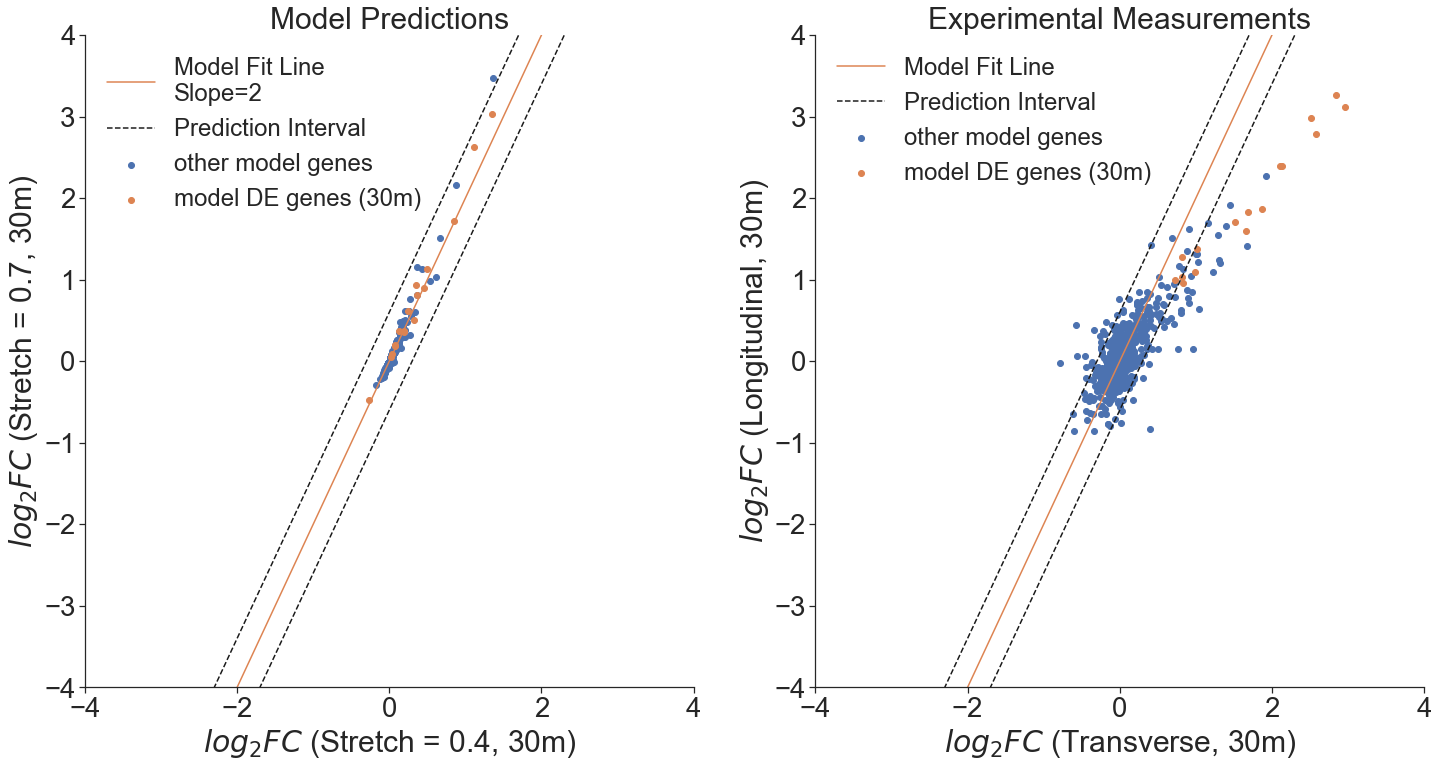

In [53]:
sns.set(font_scale=2.5)
sns.set_style("ticks", {'axes.grid' : False, 'font.sans-serif':'Arial'})
plt.figure(figsize=(24,12))
plt.subplot(1,2,1)
plt.scatter(
    np.log2(y240_MA_lo[299, model_unDE_30m_index])-np.log2(y240_MA_lo[0, model_unDE_30m_index]),
    np.log2(y240_MA[299, model_unDE_30m_index])-np.log2(y240_MA[0, model_unDE_30m_index]),
    label = 'other model genes'
)
plt.scatter(
    np.log2(y240_MA_lo[299, model_DE_30m_index])-np.log2(y240_MA_lo[0, model_DE_30m_index]),
    np.log2(y240_MA[299, model_DE_30m_index])-np.log2(y240_MA[0, model_DE_30m_index]),
    label = 'model DE genes (30m)'
)

plt.plot(
    np.arange(-4, 4, 0.01), 
    2*np.arange(-4, 4, 0.01), 
    label='Model Fit Line\nSlope=2',
    color = colchoices[1]
)
plt.plot(
    np.arange(-4, 4, 0.01), 
    2*np.arange(-4, 4, 0.01)-0.6,
    'k--',
    label='Prediction Interval'
)
plt.plot(
    np.arange(-4, 4, 0.01), 
    2*np.arange(-4, 4, 0.01)+0.6,
    'k--'
)
# plot the regression
# plt.plot(px_30, nom_30, c='black', label='Model Fit Line')
plt.xlim((-4,4))
plt.ylim((-4,4))
plt.title('Model Predictions')
plt.xlabel(r'$log_2 FC$ (Stretch = 0.4, 30m)')
plt.ylabel(r'$log_2 FC$ (Stretch = 0.7, 30m)')
plt.legend(loc = 'best', frameon = False, fontsize = 24)
plt.subplot(1,2,2)
plt.scatter(
    np.log2(y30m_MA_trans)[model_unDE_30m_index]-np.log2(y0_MA)[model_unDE_30m_index],
    np.log2(y30m_MA)[model_unDE_30m_index]-np.log2(y0_MA)[model_unDE_30m_index],
    label = 'other model genes'
)
plt.scatter(
    np.log2(y30m_MA_trans)[model_DE_30m_index]-np.log2(y0_MA)[model_DE_30m_index],
    np.log2(y30m_MA)[model_DE_30m_index]-np.log2(y0_MA)[model_DE_30m_index],
    label = 'model DE genes (30m)'
)
plt.plot(
    np.arange(-4, 4, 0.01), 
    2*np.arange(-4, 4, 0.01), 
    label='Model Fit Line',
    color = colchoices[1]
)

plt.xlim((-4,4))
plt.ylim((-4,4))

plt.plot(
    np.arange(-4, 4, 0.01), 
    2*np.arange(-4, 4, 0.01)-0.6,
    'k--',
    label='Prediction Interval'
)
plt.plot(
    np.arange(-4, 4, 0.01), 
    2*np.arange(-4, 4, 0.01)+0.6,
    'k--'
)
plt.title('Experimental Measurements')
plt.xlabel(r'$log_2 FC$ (Transverse, 30m)')
plt.ylabel(r'$log_2 FC$ (Longitudinal, 30m)')
plt.legend(loc = 'best', frameon = False, fontsize = 24)


sns.despine()
plt.savefig('../figure/FinalFigures_v2/Fig6B_TransvsLong_30m.png', dpi = 300)
plt.show()

### Fig 7A: Inhibitor Simulation

In [144]:
inpu_MA = 0.7
state1 = []
for i in range(len(y0_MA)):
    if node_ID[i]=='Stretch':
        state1.append(inpu_MA)
    elif i < count_sig:
        state1.append(yHill_ss[-1,i])
    else:
        state1.append(y0_MA[i])

Ymax[node_ID.index('AT1R')] = 0
Ymax[node_ID.index('ET1')] = 0
Ymax[node_ID.index('AngII')] = 0
ygroup1_inhi = mass_simulation(state1, t_MA, N_Constant, inpu_MA, reaction_dict, Ymax, count_sig, node_ID)
Ymax[node_ID.index('AT1R')] = 1
Ymax[node_ID.index('ET1')] = 1
Ymax[node_ID.index('AngII')] = 1

Ymax[node_ID.index('TRP')] = 0
Ymax[node_ID.index('LTCC')] = 0
Ymax[node_ID.index('NHE')] = 0
ygroup2_inhi = mass_simulation(state1, t_MA, N_Constant, inpu_MA, reaction_dict, Ymax, count_sig, node_ID)
Ymax[node_ID.index('TRP')] = 1
Ymax[node_ID.index('LTCC')] = 1
Ymax[node_ID.index('NHE')] = 1

In [145]:
inpu_MA = 0.4
state1 = []
for i in range(len(y0_MA)):
    if node_ID[i]=='Stretch':
        state1.append(inpu_MA)
    elif i < count_sig:
        state1.append(yHill_ss[-1,i])
    else:
        state1.append(y0_MA[i])

Ymax[node_ID.index('AT1R')] = 0
Ymax[node_ID.index('ET1')] = 0
Ymax[node_ID.index('AngII')] = 0
ygroup1_inhi_low = mass_simulation(state1, t_MA, N_Constant, inpu_MA, reaction_dict, Ymax, count_sig, node_ID)
Ymax[node_ID.index('AT1R')] = 1
Ymax[node_ID.index('ET1')] = 1
Ymax[node_ID.index('AngII')] = 1

Ymax[node_ID.index('TRP')] = 0
Ymax[node_ID.index('LTCC')] = 0
Ymax[node_ID.index('NHE')] = 0
ygroup2_inhi_low = mass_simulation(state1, t_MA, N_Constant, inpu_MA, reaction_dict, Ymax, count_sig, node_ID)
Ymax[node_ID.index('TRP')] = 1
Ymax[node_ID.index('LTCC')] = 1
Ymax[node_ID.index('NHE')] = 1

In [146]:
checkgenes = RNA_raw[
    (RNA_raw['Row.names'].isin(commongenes)) & \
    (
        (RNA_raw['log2FC.2']>=0.5) |\
        (RNA_raw['log2FC.3']>=0.5)
    )
]['Row.names'].tolist()

In [147]:
checkindex = [node_ID.index('gene_'+i) for i in checkgenes]

In [148]:
check_group1 = []
for j in checkindex:
    aa = np.round(ygroup1_inhi[2399, j]/y240_MA[2399, j], 2)
    if aa > 1:
        aa = 1/aa
    check_group1.append(
        1-aa
    )

check_group2 = []
for j in checkindex:
    aa = np.round(ygroup2_inhi[2399, j]/y240_MA[2399, j], 2)
    if aa > 1:
        aa = 1/aa
    check_group2.append(
        1-aa
    )

In [149]:
check_group1_low = []
for j in checkindex:
    aa = np.round(ygroup1_inhi_low[2399, j]/y240_MA[2399, j], 2)
    if aa > 1:
        aa = 1/aa
    check_group1_low.append(
        1-aa
    )

check_group2_low = []
for j in checkindex:
    aa = np.round(ygroup2_inhi_low[2399, j]/y240_MA[2399, j], 2)
    if aa > 1:
        aa = 1/aa
    check_group2_low.append(
        1-aa
    )

In [150]:
print(
    np.median(check_group1_low),
    np.median(check_group2_low),
    np.median(check_group1),
    np.median(check_group2)
)

0.52 0.18000000000000005 0.32499999999999996 0.07832144070676189


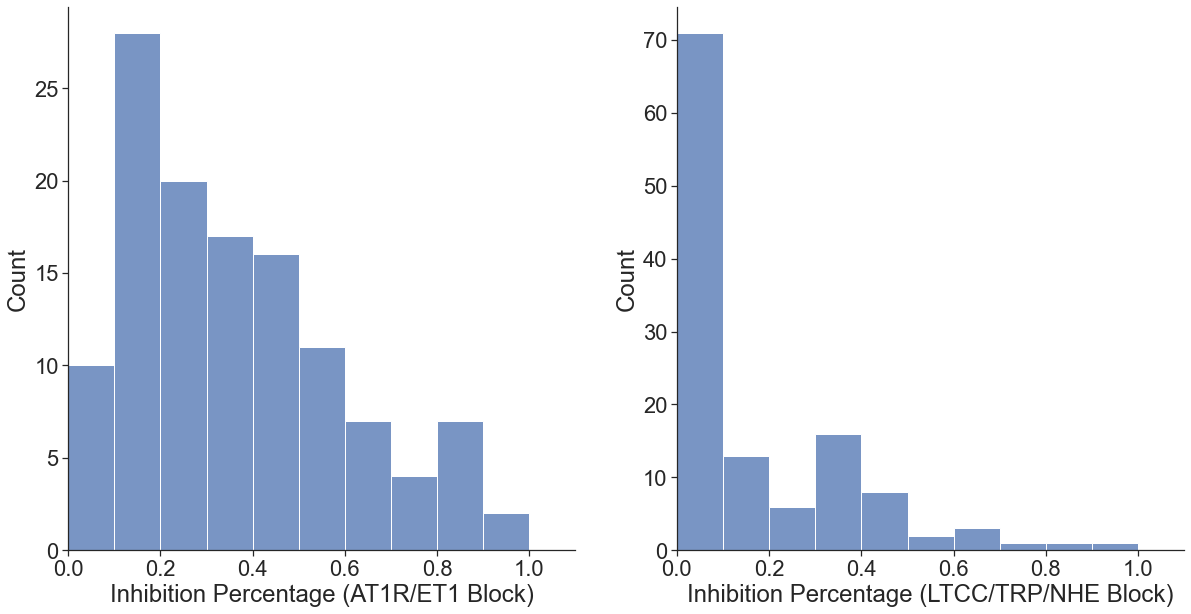

In [47]:
sns.set(font_scale=2)
sns.set_style("ticks", {'axes.grid' : False, 'font.sans-serif':'Arial'})
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
sns.histplot(check_group1, bins = np.arange(0,1.1,0.1))
plt.xlabel('Inhibition Percentage (AT1R/ET1 Block)')
plt.xlim(0, 1.1)
# plt.ylim(0, 30)
plt.subplot(1,2,2)
sns.histplot(check_group2, bins = np.arange(0,1.1,0.1))
plt.xlabel('Inhibition Percentage (LTCC/TRP/NHE Block)')
plt.xlim(0, 1.1)
# plt.ylim(0, 30)

sns.despine()
# plt.savefig('../figure/FinalFigures_v2/Fig7A_receptor_blocking_high.png', dpi = 300)
plt.show()

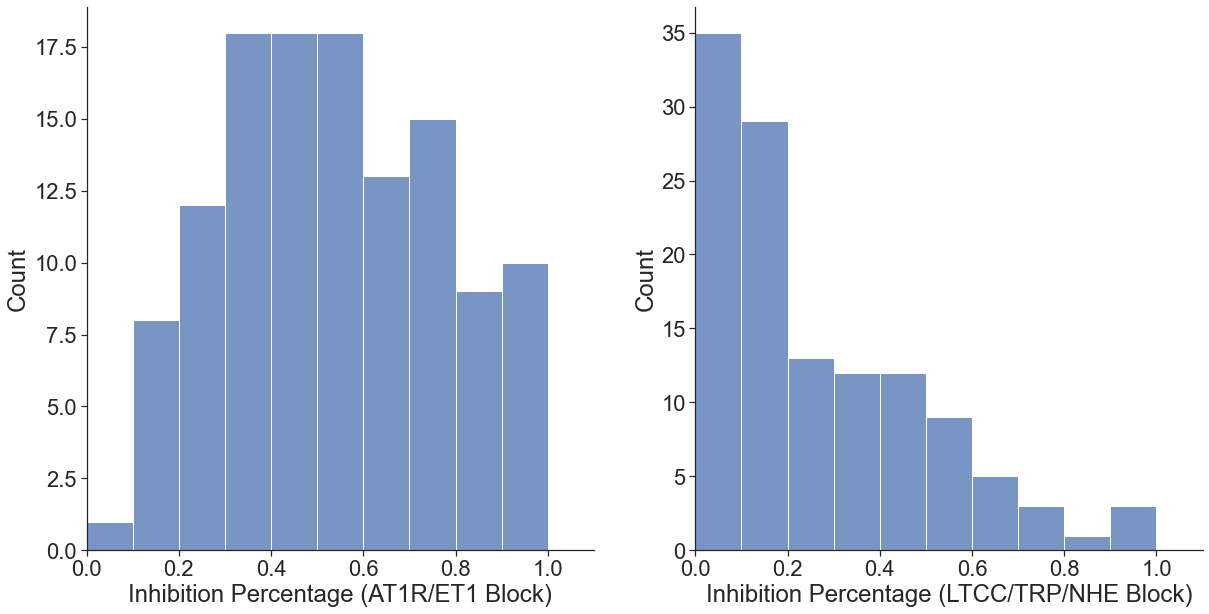

In [151]:
sns.set(font_scale=2)
sns.set_style("ticks", {'axes.grid' : False, 'font.sans-serif':'Arial'})
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
sns.histplot(check_group1_low, bins = np.arange(0,1.1,0.1))
plt.xlabel('Inhibition Percentage (AT1R/ET1 Block)')
plt.xlim(0, 1.1)
# plt.ylim(0, 30)
plt.subplot(1,2,2)
sns.histplot(check_group2_low, bins = np.arange(0,1.1,0.1))
plt.xlabel('Inhibition Percentage (LTCC/TRP/NHE Block)')
plt.xlim(0, 1.1)
# plt.ylim(0, 30)

sns.despine()
# plt.savefig('../figure/FinalFigures_v2/Fig7A_receptor_blocking_low.png', dpi = 300)
plt.show()

In [152]:
replot_inhi = pd.DataFrame(columns = ['Blocker', 'Average Inhibition'])
for i in check_group1_low:
    replot_inhi.loc[len(replot_inhi)] = ['AT1/ET1 Receptors Block', i]
for i in check_group2_low:
    replot_inhi.loc[len(replot_inhi)] = ['LTCC/TRP/NHE Receptors Block', i]

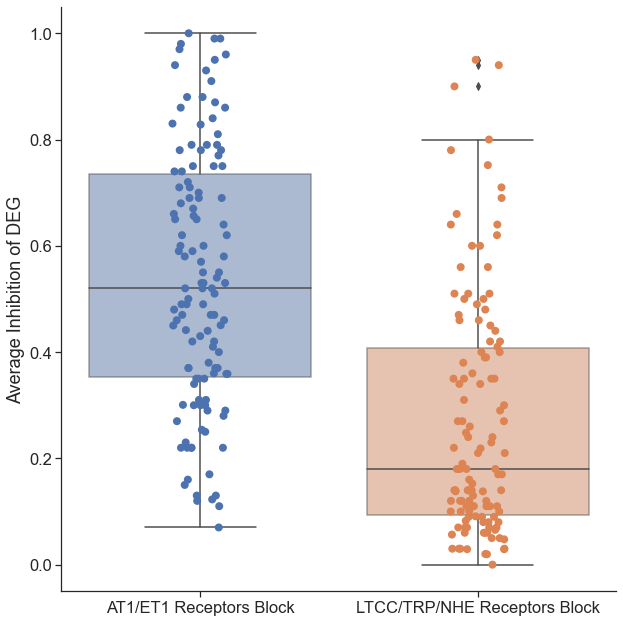

In [162]:
sns.set(font_scale=1.5)
sns.set_style("ticks", {'axes.grid' : False, 'font.sans-serif':'Arial'})
plt.figure(figsize=(9, 9))
sns.boxplot(
    x="Blocker", 
    y="Average Inhibition", 
    data=replot_inhi, 
    boxprops=dict(alpha=.5)
)
sns.stripplot(
    x="Blocker", 
    y="Average Inhibition", 
    data=replot_inhi, 
    marker = 'o',
    size = 8,
    dodge = True
)
plt.ylabel('Average Inhibition of DEG')
plt.xlabel('')
# plt.xticks(, ('-2', '-1', '0', '1', '2', '3', '4'))

sns.despine()
plt.tight_layout()
# plt.savefig('../figure/TestFigures/receptor_blocking_boxplot.png', dpi = 300)
plt.show()

In [73]:
receptor_data = pd.read_csv('/home/shulincao/Desktop/projects/lab/Shulin/data/PCR/receptor_block_processed.csv')
receptor_data['G1_Avg'] = receptor_data[['sd_g11', 'sd_g12', 'sd_g13', 'sd_g14']].mean(axis=1)
receptor_data['G2_Avg'] = receptor_data[['sd_g21', 'sd_g22', 'sd_g23', 'sd_g24']].mean(axis=1)
receptor_data['G3_Avg'] = receptor_data[['sd_g31', 'sd_g32', 'sd_g33']].mean(axis=1)
glist = ['Ctgf', 'Fosl2', 'Hbegf', 'Mafk', 'Nuak1', 'Tgfb2']
receptor_data.index = receptor_data['Gene'].tolist()
recep_conditions = receptor_data.columns.values.tolist()[:11]
processed_receptor = pd.DataFrame(columns = ['Gene', 'Blocker', 'FoldChange', 'Source', 'Order'])

In [74]:
for i in glist:
    mm = receptor_data.loc[i, recep_conditions].values.tolist()
    for j in mm[:4]:
        processed_receptor.loc[len(processed_receptor)] = [i, 'AT1R/ET1', j, 'Expt', 2]
    for j in mm[4:8]:
        processed_receptor.loc[len(processed_receptor)] = [i, 'TRP/LTCC/NHE', j, 'Expt', 1]
    for j in mm[8:]:
        processed_receptor.loc[len(processed_receptor)] = [i, 'Control', j, 'Expt', 0]
    ind = node_ID.index('gene_'+i)
    processed_receptor.loc[len(processed_receptor)] = [i, 'AT1R/ET1', np.round(ygroup1_inhi_low[2399, ind]/y240_MA_lo[0, ind], 3), 'Model', 2]
    processed_receptor.loc[len(processed_receptor)] = [i, 'TRP/LTCC/NHE', np.round(ygroup2_inhi_low[2399, ind]/y240_MA_lo[0, ind], 3), 'Model', 1]
    processed_receptor.loc[len(processed_receptor)] = [i, 'Control', np.round(y240_MA_lo[2399, ind]/y240_MA_lo[0, ind], 3), 'Model', 0]
processed_receptor_07 = pd.DataFrame(columns = ['Gene', 'Blocker', 'FoldChange', 'Source', 'Order'])
for i in glist:
    mm = receptor_data.loc[i, recep_conditions].values.tolist()
    for j in mm[:4]:
        processed_receptor_07.loc[len(processed_receptor_07)] = [i, 'AT1R/ET1', j, 'Expt', 2]
    for j in mm[4:8]:
        processed_receptor_07.loc[len(processed_receptor_07)] = [i, 'TRP/LTCC/NHE', j, 'Expt', 1]
    for j in mm[8:]:
        processed_receptor_07.loc[len(processed_receptor_07)] = [i, 'Control', j, 'Expt', 0]
    ind = node_ID.index('gene_'+i)
    processed_receptor_07.loc[len(processed_receptor_07)] = [i, 'AT1R/ET1', np.round(ygroup1_inhi[2399, ind]/y240_MA[0, ind], 3), 'Model', 2]
    processed_receptor_07.loc[len(processed_receptor_07)] = [i, 'TRP/LTCC/NHE', np.round(ygroup2_inhi[2399, ind]/y240_MA[0, ind], 3), 'Model', 1]
    processed_receptor_07.loc[len(processed_receptor_07)] = [i, 'Control', np.round(y240_MA[2399, ind]/y240_MA[0, ind], 3), 'Model', 0]

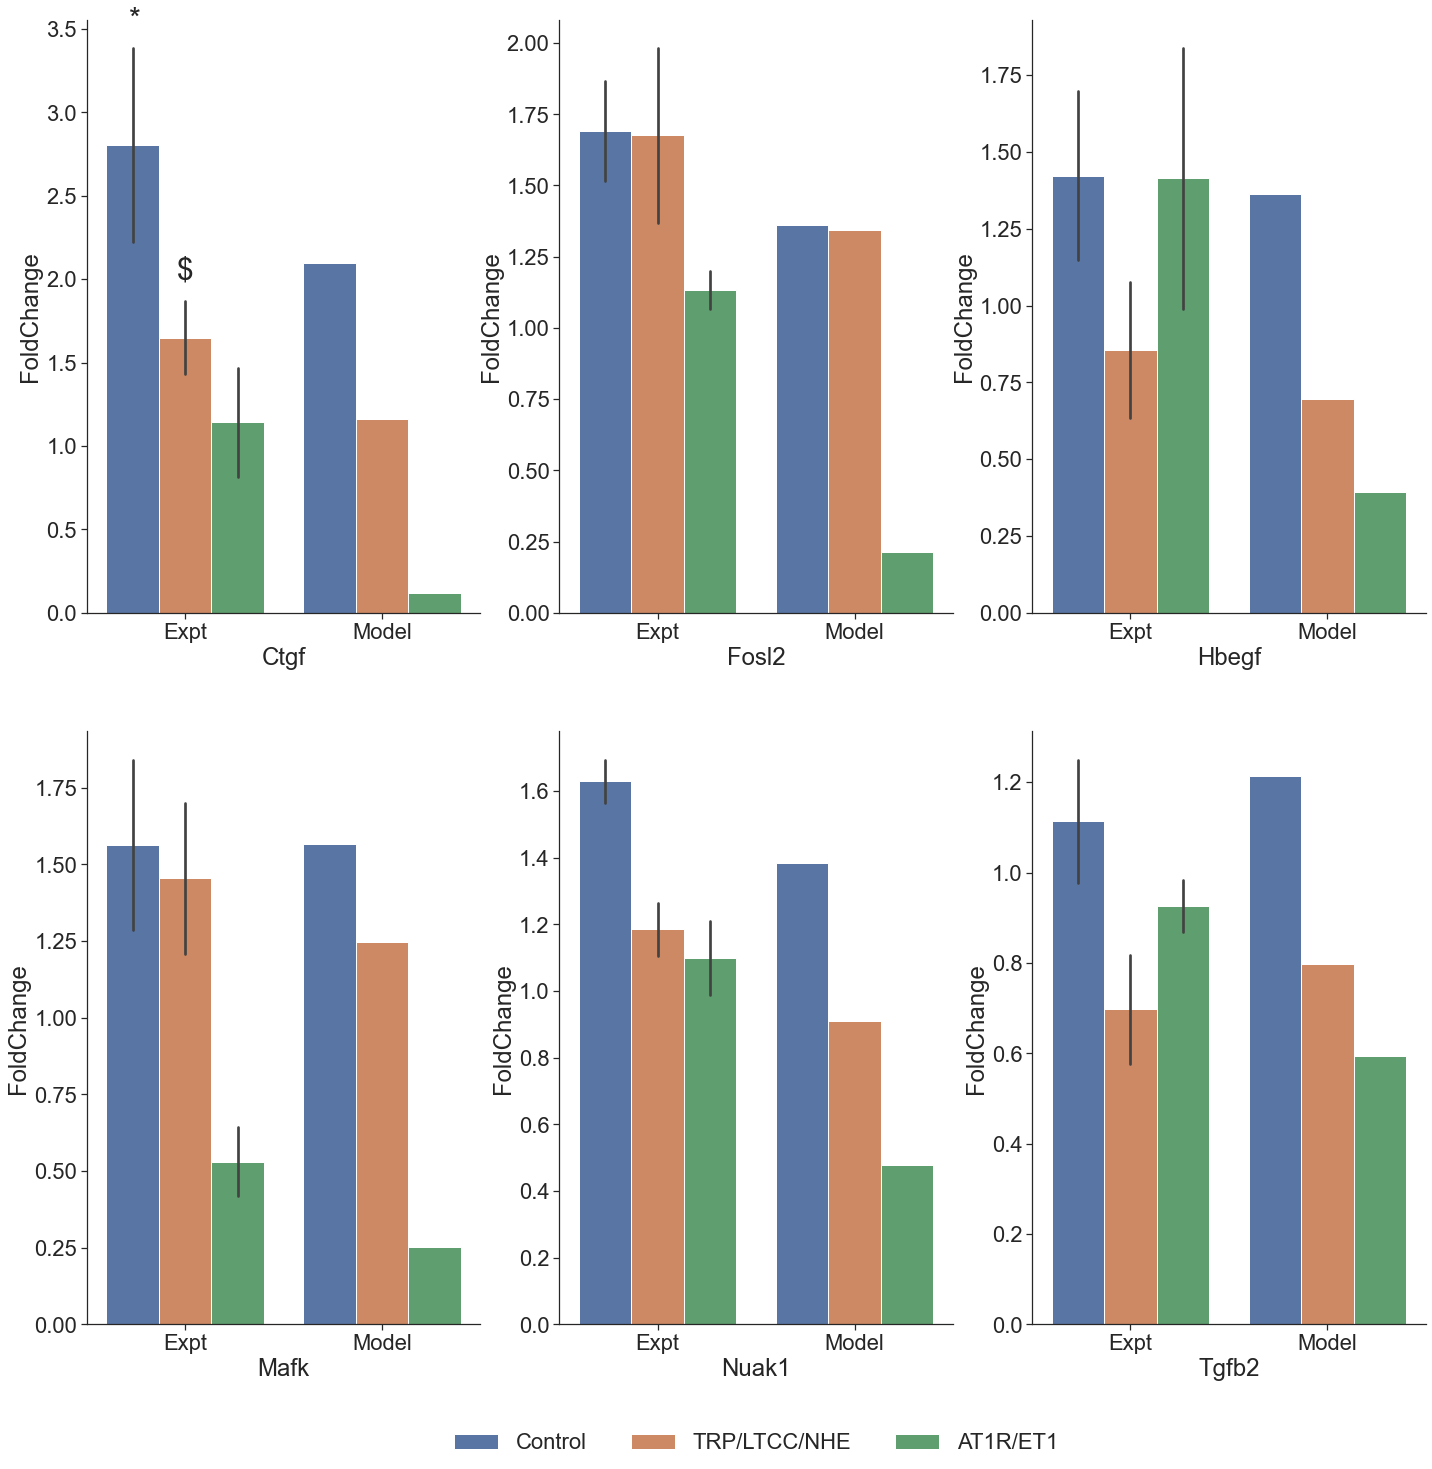

In [116]:
sns.set_style("ticks", {'axes.grid' : False, 'font.sans-serif':'Arial'})
plt.figure(figsize = (24, 24))
for i in range(len(glist)):
    plt.subplot(2, 3, i+1)
    p1 = processed_receptor[processed_receptor['Gene']==glist[i]].sort_values(by = 'Order')
    ax = sns.barplot(
        x = "Source", 
        y = "FoldChange", 
        hue = 'Blocker',
        data = p1,
        ci = 'sd'
    )
    ax.set(xlabel=glist[i])
    if i == 4:
        plt.legend(loc='center', bbox_to_anchor = (0.5, -0.2), ncol = 3, frameon = False)
    else:
        plt.legend([],[], frameon=False)
    if i == 0:
        plt.text(-0.26, 3.5, '*', fontsize=30, horizontalalignment='center')
        plt.text(0, 2, '$', fontsize=30, horizontalalignment='center')

sns.despine()
# plt.savefig('../figure/FinalFigures/Fig7B_ReceptorBlocking.png', dpi = 300)
plt.show()

In [131]:
stats.ttest_ind(receptor_data.loc['Tgfb2', ['sd_g31', 'sd_g32', 'sd_g33']].values, [1,1,1])

Ttest_indResult(statistic=1.1779176838186174, pvalue=0.30412356821185654)

In [132]:
stats.ttest_ind(
    receptor_data.loc['Tgfb2', ['sd_g31', 'sd_g32', 'sd_g33']].values, 
    receptor_data.loc['Tgfb2', ['sd_g11', 'sd_g12', 'sd_g13', 'sd_g14']].values
)

Ttest_indResult(statistic=2.097535021611916, pvalue=0.09003446263577379)

In [133]:
stats.ttest_ind(
    receptor_data.loc['Tgfb2', ['sd_g31', 'sd_g32', 'sd_g33']].values, 
    receptor_data.loc['Tgfb2', ['sd_g21', 'sd_g22', 'sd_g23', 'sd_g24']].values
)

Ttest_indResult(statistic=3.6046312947523984, pvalue=0.015467600023023956)

In [114]:
receptor_data.loc['Mafk', ['sd_g21', 'sd_g22', 'sd_g23', 'sd_g24']].values

array([1.12896511377887, 1.4401529008873302, 1.82160758276274,
       1.4244022943768102], dtype=object)

In [158]:
for j in range(len(checkindex)):
    if check_group2[j] > 0.8:
        print(
            node_ID[checkindex[j]][5:],
            check_group2[j],
            check_group1[j]
        )


Adm 0.9259259259259258 0.21999999999999997
Amotl2 0.8928571428571428 0.26
Angptl4 0.9345794392523364 0.18999999999999995
Bdnf 0.87 0.94
Btg2 0.9009009009009008 0.69
Ccl2 0.9615384615384615 0.35
Crim1 0.970873786407767 0.37
Cxcl14 0.9900990099009901 0.13
Edn1 0.9174311926605504 0.85
Efnb2 0.9174311926605504 0.22999999999999998
Flnb 0.9523809523809523 0.15000000000000002
Fosl2 0.9090909090909091 0.61
Hk2 0.9090909090909091 0.6699999999999999
Hsp90aa1 0.9615384615384615 0.37
Hspa1a 0.9523809523809523 0.15000000000000002
Hspb8 0.970873786407767 0.6451612903225806
Inhba 0.9523809523809523 0.42000000000000004
Jun 0.9009009009009008 0.25
Kctd8 0.9523809523809523 0.52
Maff 0.9523809523809523 0.14
Mafk 0.9433962264150942 0.86
Map2k3 0.970873786407767 0.30000000000000004
Myc 0.9 0.87
Plaur 0.9615384615384615 0.13
Plod2 0.970873786407767 0.25
Samd4 0.9345794392523364 0.18999999999999995
Serpine1 0.9803921568627451 0.20999999999999996
Srm 0.9803921568627451 0.5
Srxn1 0.9345794392523364 0.49
Thbs1 

In [159]:
reaction_dict['gene_Zyx']

{'STAT => gene_Zyx': [0.9, 1.4, 0.5]}

In [89]:
oldrna = pd.read_csv('/home/shulincao/Desktop/projects/lab/Shulin/data/RNA_seq/RNA_seq_all.csv')

In [153]:
oldrna[oldrna['Symbol']=='Tgfb2'].values

array([['Tgfb2', 'chr1', '188447064-188529871', True, 14.5254,
        7.645639999999999, 10.978, 11.3198, 10.5181, 51.7822,
        7.225289999999999, 23.401, 1.0477299999999998, 0.000920421,
        0.1876147701044776, 17.1274, 11.7698, 35.9704, 21.9075, 0.952583,
        1.03194e-06, 0.0001879093944, 14.5501, 24.7557, 10.9813, 17.0623,
        0.591971, 0.000451102, 0.1122051932105263, 40.0846, 28.3151,
        71.6581, 47.3181, 2.06355, 0.0, 0.0]], dtype=object)

In [154]:
15/11

1.3636363636363635

## Supplements

## Data Model Comparison

## Model vs Data at 4h for Direct Comparison

In [130]:
correct_index = []
all_single_index = []
for j in TFs:
    right_direction = 0
    total_single = 0
    kk0 = revi_edges[revi_edges['Start']==j]['End_Index'].tolist()
    kk0_modi = list(set(kk0).intersection(with_data))
    for i in kk0_modi:
        if revi_edges[revi_edges['End_Index'] == i].shape[0] == 1:
            a = np.log2(y240_MA[2399, i]/y240_MA[0, i])
            b = np.log2(y4h_MA[i]/y0_MA[i])
            total_single += 1
            if a*b > 0:
                right_direction += 1
                correct_index.append(i)
            all_single_index.append(i)
    print(j, right_direction, total_single, right_direction/total_single)

FoxO 24 46 0.5217391304347826
MEF2 43 68 0.6323529411764706
cFos 26 40 0.65
cMyc 37 54 0.6851851851851852
GATA4 7 17 0.4117647058823529
NFkB 130 229 0.5676855895196506
NFAT 2 5 0.4
SRF 29 38 0.7631578947368421
STAT 54 95 0.5684210526315789
CREB 16 24 0.6666666666666666
cJun 6 12 0.5


In [131]:
multiple_index = list(set(with_data).difference(set(all_single_index)))

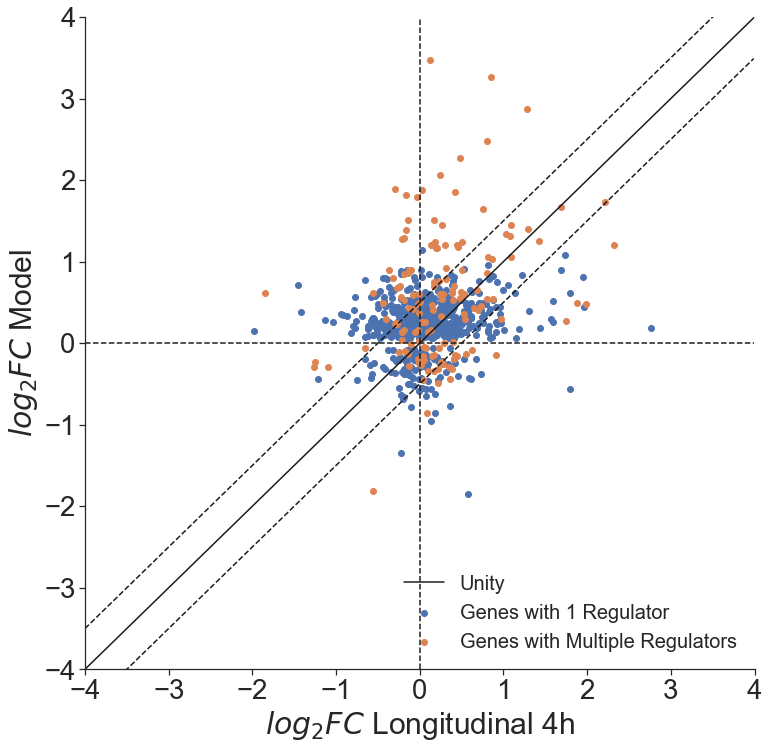

In [133]:
sns.set(font_scale=2.5)
sns.set_style("ticks", {'axes.grid' : False, 'font.sans-serif':'Arial'})
plt.figure(figsize=(12,12))

plt.scatter(
    np.log2(y4h_MA)[all_single_index]-np.log2(y0_MA)[all_single_index],
    np.log2(y240_MA[2399, all_single_index])-np.log2(y240_MA[0, all_single_index]),
    label = 'Genes with 1 Regulator'
)

plt.scatter(
    np.log2(y4h_MA)[multiple_index]-np.log2(y0_MA)[multiple_index],
    np.log2(y240_MA[2399, multiple_index])-np.log2(y240_MA[0, multiple_index]),
    label = 'Genes with Multiple Regulators'
)

plt.plot(
    np.arange(-4,4,0.01),
    [0.5]*len(np.arange(-4,4,0.01)),
    'k',
    label = 'Unity'
)

plt.plot(
    np.arange(-4,4,0.01),
    np.arange(-4,4,0.01)-0.5,
    'k--'
)

plt.plot(
    np.arange(-4,4,0.01),
    np.arange(-4,4,0.01)+0.5,
    'k--'
)

plt.plot(
    np.arange(-4,4,0.01),
    [0]*len(np.arange(-4,4,0.01)),
    'k--'
)

plt.plot(
    [0]*len(np.arange(-4,4,0.01)),
    np.arange(-4,4,0.01),
    'k--'
)

plt.xlim((-4,4))
plt.ylim((-4,4))
plt.ylabel(r'$log_2 FC$ Model')
plt.xlabel(r'$log_2 FC$ Longitudinal 4h')
plt.legend(loc = 'best', frameon = False, fontsize = 20)
sns.despine()
# plt.savefig('../figure/newdata_figures/log2comparison_all_4h_forandrew', dpi = 300)
plt.show()

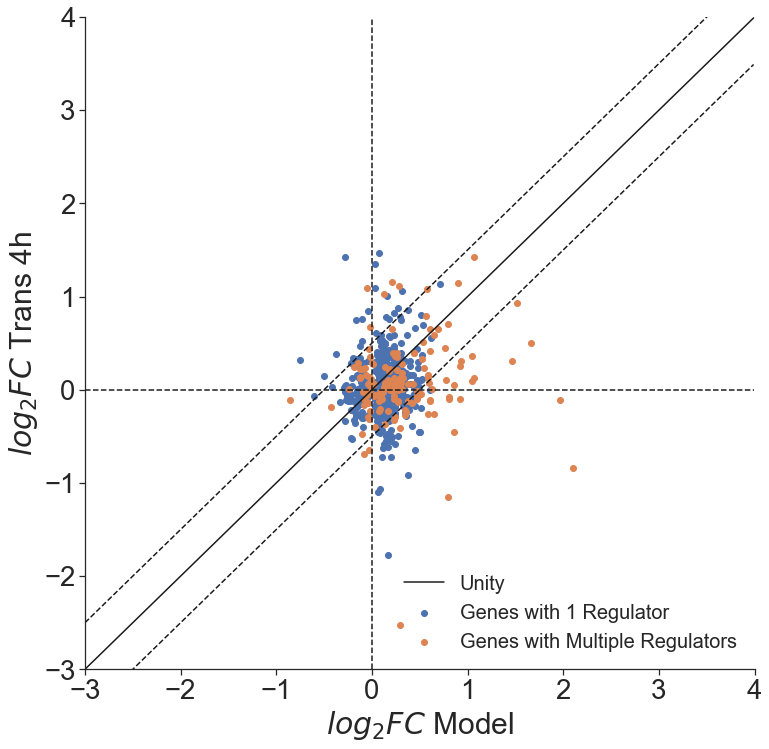

In [43]:
sns.set(font_scale=2.5)
sns.set_style("ticks", {'axes.grid' : False, 'font.sans-serif':'Arial'})
plt.figure(figsize=(12,12))

plt.scatter(
    np.log2(y240_MA_lo[2399, all_single_index])-np.log2(y240_MA[0, all_single_index]),
    np.log2(y4h_MA_trans)[all_single_index]-np.log2(y0_MA)[all_single_index],
    label = 'Genes with 1 Regulator'
)

plt.scatter(
    np.log2(y240_MA_lo[2399, multiple_index])-np.log2(y240_MA[0, multiple_index]),
    np.log2(y4h_MA_trans)[multiple_index]-np.log2(y0_MA)[multiple_index],
    label = 'Genes with Multiple Regulators'
)

plt.plot(
    np.arange(-3,4,0.01),
    np.arange(-3,4,0.01),
    'k',
    label = 'Unity'
)

plt.plot(
    np.arange(-3,4,0.01),
    np.arange(-3,4,0.01)-0.5,
    'k--'
)

plt.plot(
    np.arange(-3,4,0.01),
    np.arange(-3,4,0.01)+0.5,
    'k--'
)

plt.plot(
    np.arange(-3,4,0.01),
    [0]*len(np.arange(-3,4,0.01)),
    'k--'
)

plt.plot(
    [0]*len(np.arange(-3,4,0.01)),
    np.arange(-3,4,0.01),
    'k--'
)

plt.xlim((-3,4))
plt.ylim((-3,4))
plt.xlabel(r'$log_2 FC$ Model')
plt.ylabel(r'$log_2 FC$ Trans 4h')
plt.legend(loc = 'best', frameon = False, fontsize = 20)
sns.despine()
# plt.savefig('../figure/newdata_figures/log2comparison_all_4h_forandrew', dpi = 300)
plt.show()

In [44]:
len(correct_index)/len(all_single_index)

0.5955414012738853

In [45]:
g1above = []
g2under = []
g3inside = []
for i in with_data:
    a = np.log2(y240_MA[2399, i])-np.log2(y240_MA[0, i])
    b = np.log2(y4h_MA)[i]-np.log2(y0_MA)[i]
    if b > a+0.5 and a >= 0:
        g1above.append(i)
    elif b < a-0.5 and b >= 0:
        g2under.append(i)
    elif b > a-0.5 and a >= 0 and b < a+0.5 and b >= 0:
        g3inside.append(i)

In [46]:
collections.Counter(edges[edges['End_Index'].isin(g1above)]['Start'].tolist())

Counter({'cFos': 1,
         'NFkB': 16,
         'MEF2': 9,
         'FoxO': 1,
         'SRF': 8,
         'CREB': 1,
         'STAT': 4,
         'cJun': 2,
         'GATA4': 1})

In [47]:
collections.Counter(edges[edges['End_Index'].isin(g3inside)]['Start'].tolist())

Counter({'STAT': 53,
         'MEF2': 39,
         'SRF': 32,
         'NFkB': 142,
         'cMyc': 25,
         'cFos': 22,
         'CREB': 20,
         'FoxO': 6,
         'NFAT': 2,
         'cJun': 6,
         'GATA4': 5})

In [48]:
print(y240_MA[2399, node_ID.index('NFkB')], y240_MA[0, node_ID.index('NFkB')])

0.7053642810780139 0.5582409610997504


In [49]:
print(np.log2(y240_MA[2399, node_ID.index('NFkB')]/y240_MA[0, node_ID.index('NFkB')]))

0.3374805345464341


In [37]:
IEGs = RNA[
    (RNA['Row.names'].isin(genes)) & \
    (RNA['log2FC.3'] > 0.5) & \
    (RNA['log2FC.1'] > RNA['log2FC.3']) & \
    (RNA['log2FC.1'] > 1)
]['Row.names'].tolist()

## Data vs Model for Trans vs Long

In [54]:
X_4h = np.array([[i] for i in np.log2(y4h_MA_trans)[DEG]-np.log2(y0_MA)[DEG]])
reg_4h = LinearRegression(fit_intercept = False).fit(X_4h, np.log2(y4h_MA)[DEG]-np.log2(y0_MA)[DEG])
print(
    reg_4h.coef_, 
    reg_4h.intercept_ , 
    reg_4h.score(X_4h, np.log2(y4h_MA)[DEG]-np.log2(y0_MA)[DEG])
)

[1.68848941] 0.0 0.8912732809916013


In [68]:
ddd = sm.OLS(
    np.log2(y4h_MA)[with_data]-np.log2(y0_MA)[with_data],
    np.log2(y4h_MA_trans)[with_data]-np.log2(y0_MA)[with_data]
).fit()

In [69]:
print(ddd.t_test([1]))

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             1.2126      0.034     35.213      0.000       1.145       1.280


In [41]:
X_4h = np.array([[i] for i in np.log2(y4h_MA_trans)[with_data]-np.log2(y0_MA)[with_data]])
reg_4h = LinearRegression(fit_intercept = False).fit(X_4h, np.log2(y4h_MA)[with_data]-np.log2(y0_MA)[with_data])
print(
    reg_4h.coef_, 
    reg_4h.intercept_ , 
    reg_4h.score(X_4h, np.log2(y4h_MA)[with_data]-np.log2(y0_MA)[with_data])
)

[1.21257514] 0.0 0.5961583387261443


In [40]:
X_4h = np.array([[i] for i in np.log2(y240_MA_lo[2399, with_data]/y240_MA_lo[0, with_data])])
reg_4h = LinearRegression(fit_intercept = False).fit(X_4h, np.log2(y240_MA[2399, with_data]/y240_MA[0, with_data]))
print(
    reg_4h.coef_, 
    reg_4h.intercept_ , 
    reg_4h.score(X_4h, np.log2(y240_MA[2399, with_data]/y240_MA[0, with_data]))
)

[1.89977868] 0.0 0.9791349009546558


## Check possible outliers

In [48]:
X_train = np.array([[i] for i in np.log2(y4h_MA_trans)[with_data]-np.log2(y0_MA)[with_data]])
y_train = np.log2(y4h_MA)[with_data]-np.log2(y0_MA)[with_data]
model = sm.OLS(y_train, X_train).fit()
influence = model.get_influence()
cooks = influence.cooks_distance
meancooks = np.mean(cooks[0])
filtered_index = []
for i in range(len(with_data)):
    if cooks[0][i] >= 0.2:
        filtered_index.append(with_data[i])
stay_index = list(set(with_data).difference(set(filtered_index)))
X_4h = np.array([[i] for i in np.log2(y4h_MA_trans)[stay_index]-np.log2(y0_MA)[stay_index]])
reg_4h = LinearRegression(fit_intercept = False).fit(X_4h, np.log2(y4h_MA)[stay_index]-np.log2(y0_MA)[stay_index])
print(
    reg_4h.coef_, 
    reg_4h.intercept_ , 
    reg_4h.score(X_4h, np.log2(y4h_MA)[stay_index]-np.log2(y0_MA)[stay_index])
)

[1.347077] 0.0 0.641703060688532


## Choice of Thresholds

In [69]:
up_de_p = []
up_de_fc = []
do_de_p = []
do_de_fc = []
up_un_p = []
up_un_fc = []
do_un_p = []
do_un_fc = []
for k in with_data:
    gene = node_ID[k][5:]
    a0 = RNA_raw.loc[gene, 'log2FC.3']
    pp = RNA_raw.loc[gene, 'q_value.3']
    if pp ==0 or np.log10(pp) <= -10:
        pp = -9.99
    else:
        pp = np.log10(pp)
    if pp <= np.log10(0.05):
        if a0 >= 0:
            up_de_p.append(-pp)
            up_de_fc.append(a0)
        else:
            do_de_p.append(pp)
            do_de_fc.append(a0)
    else:
        if a0 >= 0:
            up_un_p.append(-pp)
            up_un_fc.append(a0)
        else:
            do_un_p.append(pp)
            do_un_fc.append(a0)

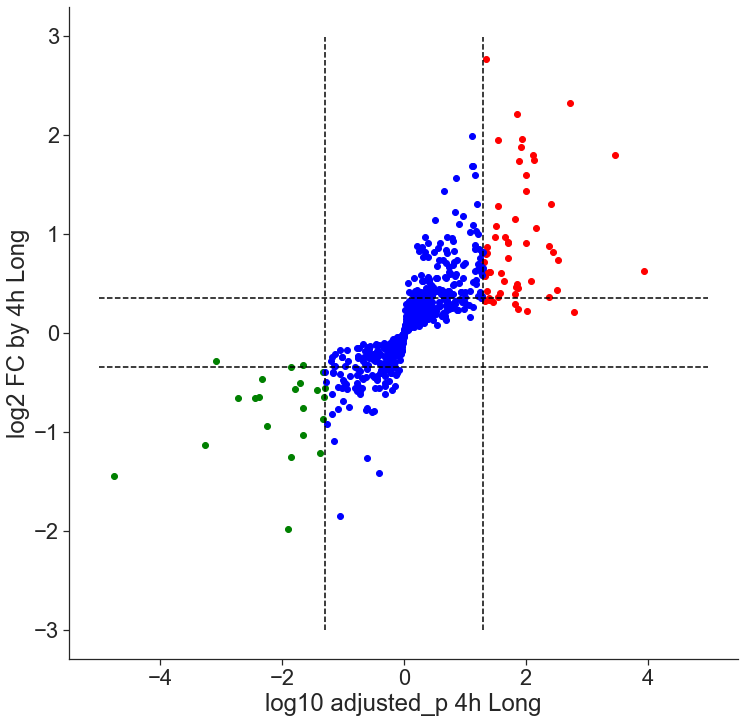

In [72]:
sns.set(font_scale=2)
sns.set_style("ticks", {'axes.grid' : False, 'font.sans-serif':'Arial'})
plt.figure(figsize=(12,12))
plt.scatter(
    up_de_p,
    up_de_fc,
    color = 'red'
)
plt.scatter(
    do_de_p,
    do_de_fc,
    color = 'green'
)
plt.scatter(
    up_un_p,
    up_un_fc,
    color = 'blue'
)
plt.scatter(
    do_un_p,
    do_un_fc,
    color = 'blue'
)
# plt.xlim(-4, 4)
# plt.ylim(-2.5, 2.5)
plt.plot([np.log10(0.05)]*len(np.arange(-3,3,0.01)), np.arange(-3,3,0.01), color = 'black', ls = '--')
plt.plot([np.log10(1/0.05)]*len(np.arange(-3,3,0.01)), np.arange(-3,3,0.01), color = 'black', ls = '--')

plt.plot(np.arange(-5,5,0.01), [0.35]*len(np.arange(-5,5,0.01)), color = 'black', ls = '--')
plt.plot(np.arange(-5,5,0.01), [-0.35]*len(np.arange(-5,5,0.01)), color = 'black', ls = '--')

plt.xlabel('log10 adjusted_p 4h Long')
plt.ylabel('log2 FC by 4h Long')
# plt.xticks(np.arange(-10,11,2), ('-10', '-8', '-6', '-4', '-2', '0', '-2', '-4', '-6', '-8', '-10'))
sns.despine()
# plt.savefig('../figure/FinalFigures/FigS2_log10_pvalues_log2FC.png', dpi = 300)
plt.show()

In [73]:
tosum = []
totalpp = []
total_tn = []
for j in np.arange(0.01, 1, 0.01):
    tr_ = 0
    fr_ = 0
    totalde = 0
    unde = 0
    fn = 0
    for k in with_data:
        gene = node_ID[k][5:]
        a0 = RNA_raw.loc[gene, 'log2FC.3']
        pp = RNA_raw.loc[gene, 'q_value.3']
        if pp <= 0.05:
            totalde += 1
            if a0 >= j or a0 <= -j:
                tr_ += 1
            else:
                fn += 1
        else:
            if a0 >= j or a0 <= -j:
                fr_ += 1
            else:
                unde += 1 
    total_tn.append(unde/(unde+fn))
    tosum.append(tr_/(tr_+fr_))
    totalpp.append(tr_/totalde)

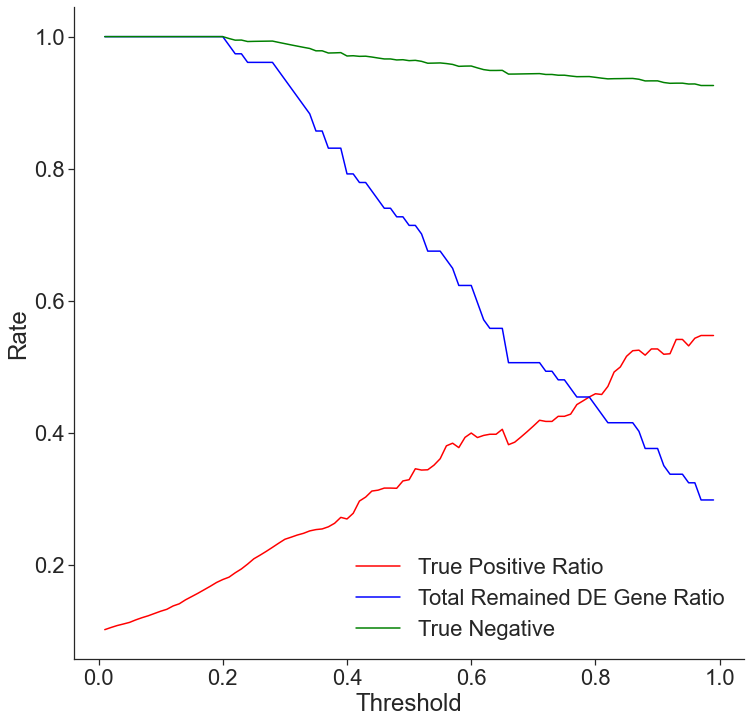

In [75]:
sns.set(font_scale=2)
sns.set_style("ticks", {'axes.grid' : False, 'font.sans-serif':'Arial'})
plt.figure(figsize=(12,12))
plt.plot(
    np.arange(0.01, 1, 0.01),
    tosum,
    color = 'red',
    label = 'True Positive Ratio'
)
plt.plot(
    np.arange(0.01, 1, 0.01),
    totalpp,
    color = 'blue',
    label = 'Total Remained DE Gene Ratio'
)
plt.plot(
    np.arange(0.01, 1, 0.01),
    total_tn,
    color = 'green',
    label = 'True Negative'
)
# plt.plot(
#     np.arange(0.01, 1, 0.01),
#     [0.95]*len(np.arange(0.01, 1, 0.01)),
#     color = 'black',
#     label = 'Threshold'
# )
# plt.plot(
#     [0.5]*len(np.arange(0.01, 1, 0.01)),
#     np.arange(0.01, 1, 0.01),
#     color = 'black',
#     label = 'Threshold'
# )
# plt.xlim(-4, 4)
# plt.ylim(-2.5, 2.5)

plt.xlabel('Threshold')
plt.ylabel('Rate')
plt.legend(loc = 'best', frameon = False)
sns.despine()
# plt.savefig('../figure/FinalFigures/FigS3_rate_threshold_data.png', dpi = 300)
plt.show()

[50, 385, 0, 18, 219, 1, 9, 90, 0]

## Check model performance on experimentally verified genes

In [125]:
with open('/home/shulincao/Desktop/projects/lab/myocyte/codes/genelist293.txt', 'r') as f:
    gene_sub = f.read().splitlines() 
gene_sub_index = [node_ID.index('gene_'+i) for i in gene_sub]

In [126]:
commonsubgenes = list(commongeneset.intersection(gene_sub))
commonsubgenes_index = [node_ID.index('gene_'+i) for i in commonsubgenes]

In [78]:
alpha = 0.05
contingency_table_sub = []
for i in np.arange(0,0.99,0.01):
    mm = i
    c_1 = 0
    c_2 = 0
    c_3 = 0
    c_4 = 0
    c_5 = 0
    c_6 = 0
    c_7 = 0
    c_8 = 0
    c_9 = 0
    for i in commonsubgenes_index:
        gene = node_ID[i][5:]
        if RNA_raw.loc[gene, 'q_value.3']>alpha:
            if np.log2(y240_MA[tt,i]/np.array(y0_MA)[i])>=mm:
                c_2 += 1
            elif np.log2(y240_MA[tt,i]/np.array(y0_MA)[i])<=-mm:
                c_8 += 1
            else:
                c_5 += 1
        else:
            if RNA_raw.loc[gene, 'q_value.3']>=0 and np.log2(y240_MA[tt,i]/np.array(y0_MA)[i])>=mm:
                c_1 += 1
            elif RNA_raw.loc[gene, 'q_value.3']<=0 and np.log2(y240_MA[tt,i]/np.array(y0_MA)[i])>=mm:
                c_3 += 1
            elif RNA_raw.loc[gene, 'q_value.3']>=0 and np.log2(y240_MA[tt,i]/np.array(y0_MA)[i])<=-mm:
                c_7 += 1
            elif RNA_raw.loc[gene, 'q_value.3']<=0 and np.log2(y240_MA[tt,i]/np.array(y0_MA)[i])<=-mm:
                c_9 += 1
            elif RNA_raw.loc[gene, 'q_value.3']>=0 and abs(np.log2(y240_MA[tt,i]/np.array(y0_MA)[i]))<mm:
                c_4 += 1
            else:
                c_6 += 1
    contingency_table_sub.append([c_1, c_2, c_3, c_4, c_5, c_6, c_7, c_8, c_9])

In [79]:
contingency_table_sub[35]

[9, 62, 0, 18, 191, 0, 0, 8, 0]

In [80]:
get_stats(contingency_table_sub[35])

(0.3333333333333333,
 0.11392405063291139,
 0.6944444444444444,
 0.7318007662835249,
 1.0)

In [127]:
data_threshold = 0.5
contingency_numerical_sub = []
for i in np.arange(0,5,0.01):
    mm = i
    c_1 = 0
    c_2 = 0
    c_3 = 0
    c_4 = 0
    c_5 = 0
    c_6 = 0
    c_7 = 0
    c_8 = 0
    c_9 = 0
    for i in commonsubgenes_index:
        gene = node_ID[i][5:]
        if abs(RNA_raw.loc[gene, 'log2FC.3']) < data_threshold:
            if np.log2(y240_MA[tt,i]/np.array(y0_MA)[i])>=mm:
                c_2 += 1
            elif np.log2(y240_MA[tt,i]/np.array(y0_MA)[i])<=-mm:
                c_8 += 1
            else:
                c_5 += 1
        else:
            if RNA_raw.loc[gene, 'log2FC.3'] >= data_threshold and np.log2(y240_MA[tt,i]/np.array(y0_MA)[i])>=mm:
                c_1 += 1
            elif RNA_raw.loc[gene, 'log2FC.3'] <= -data_threshold and np.log2(y240_MA[tt,i]/np.array(y0_MA)[i])>=mm:
                c_3 += 1
            elif RNA_raw.loc[gene, 'log2FC.3'] >= data_threshold and np.log2(y240_MA[tt,i]/np.array(y0_MA)[i])<=-mm:
                c_7 += 1
            elif RNA_raw.loc[gene, 'log2FC.3'] <= -data_threshold and np.log2(y240_MA[tt,i]/np.array(y0_MA)[i])<=-mm:
                c_9 += 1
            elif RNA_raw.loc[gene, 'log2FC.3'] >= data_threshold and abs(np.log2(y240_MA[tt,i]/np.array(y0_MA)[i]))<mm:
                c_4 += 1
            else:
                c_6 += 1
    contingency_numerical_sub.append([c_1, c_2, c_3, c_4, c_5, c_6, c_7, c_8, c_9])

In [129]:
get_stats(contingency_numerical_sub[50])

(0.22807017543859648,
 0.22413793103448276,
 0.7013888888888888,
 0.8181818181818182,
 0.8125)